# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

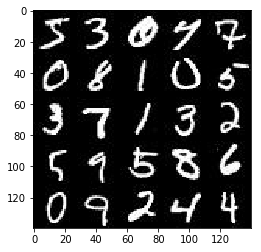

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

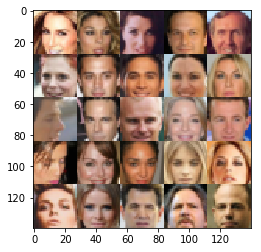

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
            
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # tf.reset_default_graph()
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(16, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Rescaling the batch image (recommandation of the review)
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, tf.convert_to_tensor(sample_z, dtype=np.float32), data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [25]:
import time
start_time = time.time()
time.sleep(2)
execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

00:00:02


Epoch 1/10... Discriminator Loss: 0.9980... Generator Loss: 0.5686
Epoch 1/10... Discriminator Loss: 0.3981... Generator Loss: 1.3873
Epoch 1/10... Discriminator Loss: 0.4768... Generator Loss: 1.3193
Epoch 1/10... Discriminator Loss: 0.4843... Generator Loss: 1.3885
Epoch 1/10... Discriminator Loss: 0.5697... Generator Loss: 1.2741
Epoch 1/10... Discriminator Loss: 0.3966... Generator Loss: 1.7087
Epoch 1/10... Discriminator Loss: 0.3929... Generator Loss: 1.4533
Epoch 1/10... Discriminator Loss: 0.3261... Generator Loss: 1.8271
Epoch 1/10... Discriminator Loss: 0.6490... Generator Loss: 0.8989
Epoch 1/10... Discriminator Loss: 0.4834... Generator Loss: 1.5303


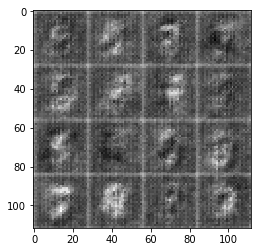

Epoch 1/10... Discriminator Loss: 0.5719... Generator Loss: 1.2001
Epoch 1/10... Discriminator Loss: 0.6428... Generator Loss: 1.4399
Epoch 1/10... Discriminator Loss: 0.8147... Generator Loss: 2.1245
Epoch 1/10... Discriminator Loss: 0.8836... Generator Loss: 0.7216
Epoch 1/10... Discriminator Loss: 0.7136... Generator Loss: 1.6170
Epoch 1/10... Discriminator Loss: 0.6413... Generator Loss: 1.4764
Epoch 1/10... Discriminator Loss: 0.9466... Generator Loss: 0.7231
Epoch 1/10... Discriminator Loss: 0.6644... Generator Loss: 1.7451
Epoch 1/10... Discriminator Loss: 0.5031... Generator Loss: 1.5619
Epoch 1/10... Discriminator Loss: 0.7537... Generator Loss: 1.9847


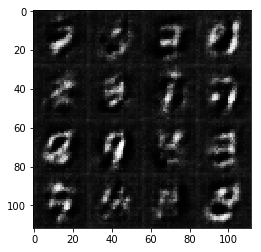

Epoch 1/10... Discriminator Loss: 0.8445... Generator Loss: 1.9839
Epoch 1/10... Discriminator Loss: 0.7219... Generator Loss: 1.0838
Epoch 1/10... Discriminator Loss: 0.7925... Generator Loss: 2.2284
Epoch 1/10... Discriminator Loss: 0.6826... Generator Loss: 1.2356
Epoch 1/10... Discriminator Loss: 0.8244... Generator Loss: 0.8894
Epoch 1/10... Discriminator Loss: 0.7871... Generator Loss: 0.8762
Epoch 1/10... Discriminator Loss: 0.7295... Generator Loss: 1.2106
Epoch 1/10... Discriminator Loss: 0.8829... Generator Loss: 0.9208
Epoch 1/10... Discriminator Loss: 0.6966... Generator Loss: 1.2591
Epoch 1/10... Discriminator Loss: 0.9055... Generator Loss: 0.7048


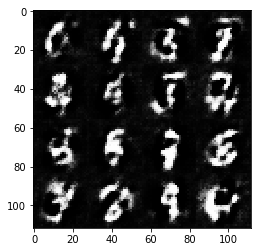

Epoch 1/10... Discriminator Loss: 0.7874... Generator Loss: 1.5855
Epoch 1/10... Discriminator Loss: 0.8320... Generator Loss: 1.2455
Epoch 1/10... Discriminator Loss: 0.8591... Generator Loss: 1.2895
Epoch 1/10... Discriminator Loss: 0.8792... Generator Loss: 0.8142
Epoch 1/10... Discriminator Loss: 0.7254... Generator Loss: 1.2536
Epoch 1/10... Discriminator Loss: 0.9041... Generator Loss: 1.5953
Epoch 1/10... Discriminator Loss: 0.6918... Generator Loss: 1.2883
Epoch 1/10... Discriminator Loss: 0.7945... Generator Loss: 1.0247
Epoch 1/10... Discriminator Loss: 0.6157... Generator Loss: 1.5637
Epoch 1/10... Discriminator Loss: 0.8229... Generator Loss: 1.0912


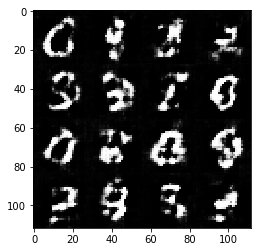

Epoch 1/10... Discriminator Loss: 1.0332... Generator Loss: 1.1175
Epoch 1/10... Discriminator Loss: 0.6263... Generator Loss: 1.1135
Epoch 1/10... Discriminator Loss: 0.6753... Generator Loss: 1.1769
Epoch 1/10... Discriminator Loss: 1.1855... Generator Loss: 0.5096
Epoch 1/10... Discriminator Loss: 0.8410... Generator Loss: 0.9940
Epoch 1/10... Discriminator Loss: 0.7429... Generator Loss: 1.6093
Epoch 1/10... Discriminator Loss: 0.6873... Generator Loss: 1.1303
Epoch 1/10... Discriminator Loss: 0.7351... Generator Loss: 1.3290
Epoch 1/10... Discriminator Loss: 0.7051... Generator Loss: 1.1372
Epoch 1/10... Discriminator Loss: 0.6707... Generator Loss: 1.2804


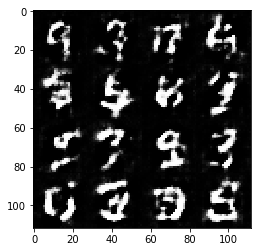

Epoch 1/10... Discriminator Loss: 0.7055... Generator Loss: 1.5937
Epoch 1/10... Discriminator Loss: 0.5896... Generator Loss: 1.4344
Epoch 1/10... Discriminator Loss: 0.5614... Generator Loss: 1.3628
Epoch 1/10... Discriminator Loss: 0.6243... Generator Loss: 1.6201
Epoch 1/10... Discriminator Loss: 0.5528... Generator Loss: 1.6234
Epoch 1/10... Discriminator Loss: 0.6659... Generator Loss: 1.3850
Epoch 1/10... Discriminator Loss: 0.5900... Generator Loss: 1.4439
Epoch 1/10... Discriminator Loss: 0.5611... Generator Loss: 1.6201
Epoch 1/10... Discriminator Loss: 0.6570... Generator Loss: 1.6297
Epoch 1/10... Discriminator Loss: 0.5187... Generator Loss: 1.2895


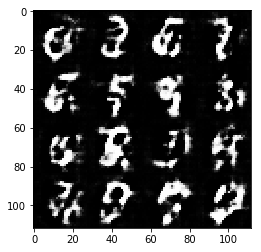

Epoch 1/10... Discriminator Loss: 0.4964... Generator Loss: 1.4811
Epoch 1/10... Discriminator Loss: 0.5637... Generator Loss: 1.2381
Epoch 1/10... Discriminator Loss: 0.5551... Generator Loss: 1.6997
Epoch 1/10... Discriminator Loss: 0.7260... Generator Loss: 1.0786
Epoch 1/10... Discriminator Loss: 0.5202... Generator Loss: 1.5712
Epoch 1/10... Discriminator Loss: 0.5321... Generator Loss: 1.4124
Epoch 1/10... Discriminator Loss: 0.5826... Generator Loss: 1.8774
Epoch 1/10... Discriminator Loss: 0.6328... Generator Loss: 1.2544
Epoch 1/10... Discriminator Loss: 0.5220... Generator Loss: 1.3820
Epoch 1/10... Discriminator Loss: 0.4921... Generator Loss: 1.6366


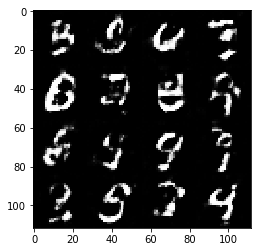

Epoch 1/10... Discriminator Loss: 0.5238... Generator Loss: 1.3045
Epoch 1/10... Discriminator Loss: 0.6325... Generator Loss: 1.2919
Epoch 1/10... Discriminator Loss: 0.5015... Generator Loss: 1.9695
Epoch 1/10... Discriminator Loss: 0.5012... Generator Loss: 1.3659
Epoch 1/10... Discriminator Loss: 0.4500... Generator Loss: 2.1717
Epoch 1/10... Discriminator Loss: 0.3507... Generator Loss: 2.4193
Epoch 1/10... Discriminator Loss: 0.5704... Generator Loss: 1.7684
Epoch 1/10... Discriminator Loss: 0.5069... Generator Loss: 1.6507
Epoch 1/10... Discriminator Loss: 0.6956... Generator Loss: 0.9952
Epoch 1/10... Discriminator Loss: 0.7232... Generator Loss: 1.2596


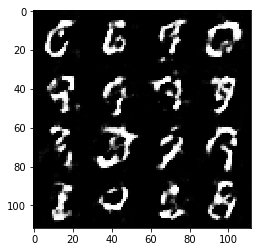

Epoch 1/10... Discriminator Loss: 0.4960... Generator Loss: 1.3083
Epoch 1/10... Discriminator Loss: 0.5817... Generator Loss: 1.1466
Epoch 1/10... Discriminator Loss: 0.8746... Generator Loss: 0.8315
Epoch 1/10... Discriminator Loss: 0.3267... Generator Loss: 2.2499
Epoch 1/10... Discriminator Loss: 0.5289... Generator Loss: 1.4582
Epoch 1/10... Discriminator Loss: 0.4329... Generator Loss: 1.6783
Epoch 1/10... Discriminator Loss: 0.9329... Generator Loss: 0.7394
Epoch 1/10... Discriminator Loss: 0.8822... Generator Loss: 0.7544
Epoch 1/10... Discriminator Loss: 0.6275... Generator Loss: 1.1144
Epoch 1/10... Discriminator Loss: 0.4007... Generator Loss: 1.6858


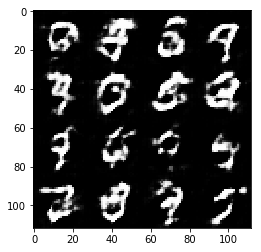

Epoch 1/10... Discriminator Loss: 0.4128... Generator Loss: 1.5296
Epoch 1/10... Discriminator Loss: 0.4606... Generator Loss: 1.6275
Epoch 1/10... Discriminator Loss: 0.8911... Generator Loss: 0.8310
Epoch 1/10... Discriminator Loss: 0.5497... Generator Loss: 1.4288
Epoch 1/10... Discriminator Loss: 0.4758... Generator Loss: 1.5777
Epoch 1/10... Discriminator Loss: 0.3865... Generator Loss: 1.9737
Epoch 1/10... Discriminator Loss: 0.6057... Generator Loss: 1.4158
Epoch 1/10... Discriminator Loss: 0.3342... Generator Loss: 1.7990
Epoch 1/10... Discriminator Loss: 0.4119... Generator Loss: 1.8225
Epoch 1/10... Discriminator Loss: 0.5979... Generator Loss: 1.2869


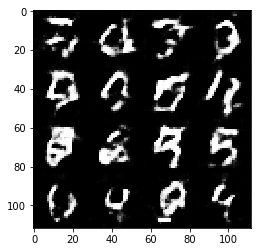

Epoch 1/10... Discriminator Loss: 0.7681... Generator Loss: 0.7424
Epoch 1/10... Discriminator Loss: 0.7096... Generator Loss: 1.7456
Epoch 1/10... Discriminator Loss: 0.5442... Generator Loss: 1.4153
Epoch 1/10... Discriminator Loss: 0.5596... Generator Loss: 1.4193
Epoch 1/10... Discriminator Loss: 0.5377... Generator Loss: 1.1716
Epoch 1/10... Discriminator Loss: 0.5285... Generator Loss: 1.5489
Epoch 1/10... Discriminator Loss: 0.4562... Generator Loss: 1.9951
Epoch 1/10... Discriminator Loss: 0.4455... Generator Loss: 1.5585
Epoch 1/10... Discriminator Loss: 0.4274... Generator Loss: 1.6680
Epoch 1/10... Discriminator Loss: 0.5672... Generator Loss: 1.4098


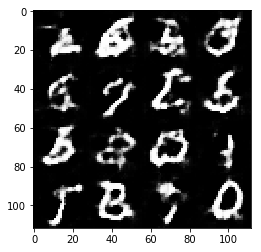

Epoch 1/10... Discriminator Loss: 0.6786... Generator Loss: 1.3865
Epoch 1/10... Discriminator Loss: 0.5867... Generator Loss: 2.1995
Epoch 1/10... Discriminator Loss: 0.5464... Generator Loss: 1.3968
Epoch 1/10... Discriminator Loss: 0.6775... Generator Loss: 2.0526
Epoch 1/10... Discriminator Loss: 0.6005... Generator Loss: 1.1757
Epoch 1/10... Discriminator Loss: 0.5972... Generator Loss: 1.2955
Epoch 1/10... Discriminator Loss: 0.7615... Generator Loss: 1.0300
Epoch 1/10... Discriminator Loss: 0.6263... Generator Loss: 1.2033
Epoch 1/10... Discriminator Loss: 0.4915... Generator Loss: 1.8262
Epoch 1/10... Discriminator Loss: 0.6337... Generator Loss: 1.1379


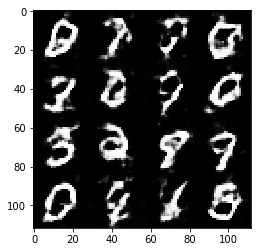

Epoch 1/10... Discriminator Loss: 0.5489... Generator Loss: 1.4313
Epoch 1/10... Discriminator Loss: 0.4570... Generator Loss: 2.1193
Epoch 1/10... Discriminator Loss: 0.5867... Generator Loss: 1.3287
Epoch 1/10... Discriminator Loss: 0.7241... Generator Loss: 1.0842
Epoch 1/10... Discriminator Loss: 0.5304... Generator Loss: 2.0404
Epoch 1/10... Discriminator Loss: 0.5044... Generator Loss: 1.8152
Epoch 1/10... Discriminator Loss: 0.9442... Generator Loss: 0.6278
Epoch 1/10... Discriminator Loss: 0.5475... Generator Loss: 2.3022
Epoch 1/10... Discriminator Loss: 0.6062... Generator Loss: 1.0897
Epoch 1/10... Discriminator Loss: 0.8371... Generator Loss: 0.8662


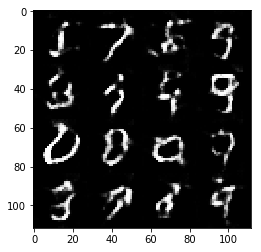

Epoch 1/10... Discriminator Loss: 0.5842... Generator Loss: 2.4191
Epoch 1/10... Discriminator Loss: 0.7519... Generator Loss: 1.2195
Epoch 1/10... Discriminator Loss: 0.6599... Generator Loss: 1.4804
Epoch 1/10... Discriminator Loss: 0.7744... Generator Loss: 2.0579
Epoch 1/10... Discriminator Loss: 0.9409... Generator Loss: 0.7793
Epoch 1/10... Discriminator Loss: 1.0201... Generator Loss: 0.6676
Epoch 1/10... Discriminator Loss: 0.6789... Generator Loss: 1.0620
Epoch 1/10... Discriminator Loss: 0.6887... Generator Loss: 1.0364
Epoch 1/10... Discriminator Loss: 0.6214... Generator Loss: 1.6307
Epoch 1/10... Discriminator Loss: 0.6597... Generator Loss: 1.1866


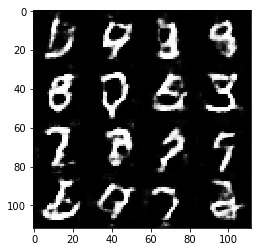

Epoch 1/10... Discriminator Loss: 0.4695... Generator Loss: 1.7527
Epoch 1/10... Discriminator Loss: 0.6757... Generator Loss: 1.0620
Epoch 1/10... Discriminator Loss: 0.8600... Generator Loss: 1.5050
Epoch 1/10... Discriminator Loss: 0.5420... Generator Loss: 1.4921
Epoch 1/10... Discriminator Loss: 0.6858... Generator Loss: 1.0744
Epoch 1/10... Discriminator Loss: 0.7525... Generator Loss: 0.9905
Epoch 1/10... Discriminator Loss: 0.8023... Generator Loss: 0.8407
Epoch 1/10... Discriminator Loss: 0.6129... Generator Loss: 1.1626
Epoch 1/10... Discriminator Loss: 0.9591... Generator Loss: 1.8167
Epoch 1/10... Discriminator Loss: 0.7246... Generator Loss: 0.9661


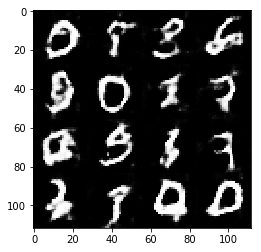

Epoch 1/10... Discriminator Loss: 0.7115... Generator Loss: 1.0888
Epoch 1/10... Discriminator Loss: 0.6095... Generator Loss: 1.4910
Epoch 1/10... Discriminator Loss: 0.6297... Generator Loss: 1.4574
Epoch 1/10... Discriminator Loss: 0.7054... Generator Loss: 0.9748
Epoch 1/10... Discriminator Loss: 1.1273... Generator Loss: 0.5215
Epoch 1/10... Discriminator Loss: 0.7342... Generator Loss: 1.7016
Epoch 1/10... Discriminator Loss: 0.8583... Generator Loss: 1.7814
Epoch 1/10... Discriminator Loss: 0.7833... Generator Loss: 1.2331
Epoch 1/10... Discriminator Loss: 0.8551... Generator Loss: 2.4055
Epoch 1/10... Discriminator Loss: 1.2166... Generator Loss: 0.4926


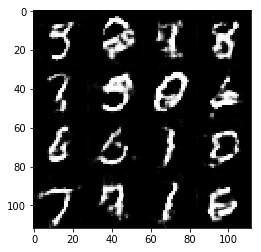

Epoch 1/10... Discriminator Loss: 0.8614... Generator Loss: 1.6397
Epoch 1/10... Discriminator Loss: 0.6935... Generator Loss: 1.0050
Epoch 1/10... Discriminator Loss: 0.7533... Generator Loss: 0.8542
Epoch 1/10... Discriminator Loss: 0.9233... Generator Loss: 0.7791
Epoch 1/10... Discriminator Loss: 0.6771... Generator Loss: 1.1780
Epoch 1/10... Discriminator Loss: 0.5368... Generator Loss: 1.8142
Epoch 1/10... Discriminator Loss: 0.9015... Generator Loss: 0.7686
Epoch 1/10... Discriminator Loss: 0.5365... Generator Loss: 1.8832
Epoch 1/10... Discriminator Loss: 0.7329... Generator Loss: 2.0298
Epoch 1/10... Discriminator Loss: 0.5517... Generator Loss: 1.2624


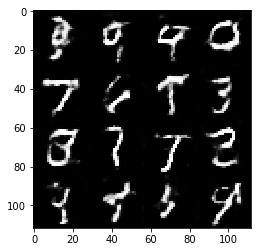

Epoch 1/10... Discriminator Loss: 0.8468... Generator Loss: 0.9029
Epoch 1/10... Discriminator Loss: 1.7141... Generator Loss: 1.7890
Epoch 1/10... Discriminator Loss: 1.3456... Generator Loss: 0.4370
Epoch 1/10... Discriminator Loss: 0.8250... Generator Loss: 1.1072
Epoch 1/10... Discriminator Loss: 0.6241... Generator Loss: 1.2435
Epoch 1/10... Discriminator Loss: 0.7695... Generator Loss: 1.1404
Epoch 1/10... Discriminator Loss: 0.5909... Generator Loss: 1.5160
Epoch 1/10... Discriminator Loss: 0.5480... Generator Loss: 1.5054
Epoch 1/10... Discriminator Loss: 0.6346... Generator Loss: 1.8196
Epoch 1/10... Discriminator Loss: 0.5479... Generator Loss: 1.4614


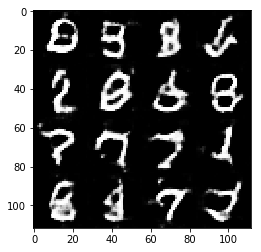

Epoch 1/10... Discriminator Loss: 1.0263... Generator Loss: 0.6710
Epoch 1/10... Discriminator Loss: 0.6087... Generator Loss: 1.3655
Epoch 1/10... Discriminator Loss: 0.9267... Generator Loss: 1.3825
Epoch 1/10... Discriminator Loss: 0.6052... Generator Loss: 1.5196
Epoch 1/10... Discriminator Loss: 0.8556... Generator Loss: 0.8862
Epoch 1/10... Discriminator Loss: 0.8581... Generator Loss: 1.0329
Epoch 1/10... Discriminator Loss: 0.6007... Generator Loss: 1.3985
Epoch 2/10... Discriminator Loss: 0.6449... Generator Loss: 1.2016
Epoch 2/10... Discriminator Loss: 0.5860... Generator Loss: 1.4014
Epoch 2/10... Discriminator Loss: 0.7788... Generator Loss: 1.1314


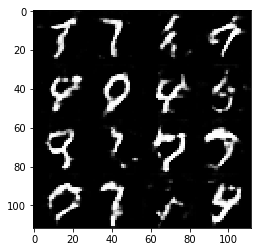

Epoch 2/10... Discriminator Loss: 0.7371... Generator Loss: 1.2171
Epoch 2/10... Discriminator Loss: 0.6100... Generator Loss: 1.1703
Epoch 2/10... Discriminator Loss: 0.8364... Generator Loss: 0.8850
Epoch 2/10... Discriminator Loss: 0.8531... Generator Loss: 0.9913
Epoch 2/10... Discriminator Loss: 0.6386... Generator Loss: 1.3690
Epoch 2/10... Discriminator Loss: 0.6686... Generator Loss: 1.7321
Epoch 2/10... Discriminator Loss: 0.8355... Generator Loss: 0.9259
Epoch 2/10... Discriminator Loss: 0.9187... Generator Loss: 0.9837
Epoch 2/10... Discriminator Loss: 0.6431... Generator Loss: 2.1639
Epoch 2/10... Discriminator Loss: 0.7269... Generator Loss: 1.6153


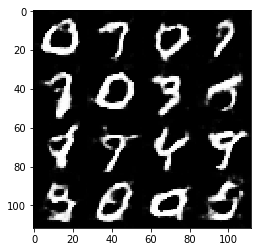

Epoch 2/10... Discriminator Loss: 0.6214... Generator Loss: 1.1041
Epoch 2/10... Discriminator Loss: 0.6062... Generator Loss: 1.5671
Epoch 2/10... Discriminator Loss: 0.6682... Generator Loss: 1.0252
Epoch 2/10... Discriminator Loss: 0.5450... Generator Loss: 1.6963
Epoch 2/10... Discriminator Loss: 0.7938... Generator Loss: 1.2665
Epoch 2/10... Discriminator Loss: 0.6043... Generator Loss: 1.1578
Epoch 2/10... Discriminator Loss: 0.5725... Generator Loss: 2.1281
Epoch 2/10... Discriminator Loss: 0.7959... Generator Loss: 0.8294
Epoch 2/10... Discriminator Loss: 1.0240... Generator Loss: 0.6032
Epoch 2/10... Discriminator Loss: 0.6680... Generator Loss: 1.8433


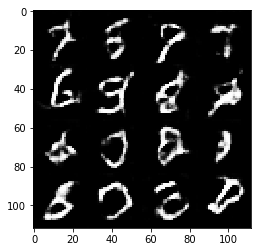

Epoch 2/10... Discriminator Loss: 0.6058... Generator Loss: 1.3584
Epoch 2/10... Discriminator Loss: 0.7398... Generator Loss: 1.5969
Epoch 2/10... Discriminator Loss: 0.4851... Generator Loss: 1.3771
Epoch 2/10... Discriminator Loss: 0.6361... Generator Loss: 1.7086
Epoch 2/10... Discriminator Loss: 0.6977... Generator Loss: 1.3394
Epoch 2/10... Discriminator Loss: 0.5833... Generator Loss: 1.4015
Epoch 2/10... Discriminator Loss: 0.7044... Generator Loss: 1.1694
Epoch 2/10... Discriminator Loss: 0.6732... Generator Loss: 1.2244
Epoch 2/10... Discriminator Loss: 0.6034... Generator Loss: 1.1416
Epoch 2/10... Discriminator Loss: 0.9527... Generator Loss: 2.2360


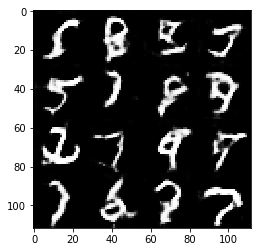

Epoch 2/10... Discriminator Loss: 0.7168... Generator Loss: 1.3519
Epoch 2/10... Discriminator Loss: 0.6956... Generator Loss: 1.1241
Epoch 2/10... Discriminator Loss: 0.7493... Generator Loss: 1.2001
Epoch 2/10... Discriminator Loss: 0.5207... Generator Loss: 1.8741
Epoch 2/10... Discriminator Loss: 0.7165... Generator Loss: 1.1341
Epoch 2/10... Discriminator Loss: 0.5320... Generator Loss: 1.3625
Epoch 2/10... Discriminator Loss: 0.5816... Generator Loss: 1.3754
Epoch 2/10... Discriminator Loss: 0.6455... Generator Loss: 1.2759
Epoch 2/10... Discriminator Loss: 0.7590... Generator Loss: 1.0339
Epoch 2/10... Discriminator Loss: 0.5826... Generator Loss: 1.2790


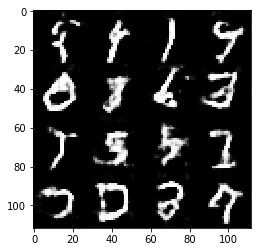

Epoch 2/10... Discriminator Loss: 0.6001... Generator Loss: 1.5490
Epoch 2/10... Discriminator Loss: 1.0458... Generator Loss: 2.3481
Epoch 2/10... Discriminator Loss: 1.2067... Generator Loss: 0.5183
Epoch 2/10... Discriminator Loss: 0.6944... Generator Loss: 1.1653
Epoch 2/10... Discriminator Loss: 0.5601... Generator Loss: 1.3209
Epoch 2/10... Discriminator Loss: 0.5422... Generator Loss: 1.7537
Epoch 2/10... Discriminator Loss: 0.6206... Generator Loss: 1.2504
Epoch 2/10... Discriminator Loss: 0.5869... Generator Loss: 1.4374
Epoch 2/10... Discriminator Loss: 0.6713... Generator Loss: 1.2411
Epoch 2/10... Discriminator Loss: 0.5390... Generator Loss: 1.2187


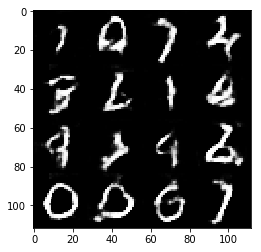

Epoch 2/10... Discriminator Loss: 0.6005... Generator Loss: 1.9260
Epoch 2/10... Discriminator Loss: 0.6760... Generator Loss: 2.0392
Epoch 2/10... Discriminator Loss: 0.6637... Generator Loss: 1.0909
Epoch 2/10... Discriminator Loss: 0.6264... Generator Loss: 1.0729
Epoch 2/10... Discriminator Loss: 0.6362... Generator Loss: 1.3965
Epoch 2/10... Discriminator Loss: 0.6316... Generator Loss: 1.6668
Epoch 2/10... Discriminator Loss: 0.8097... Generator Loss: 0.9098
Epoch 2/10... Discriminator Loss: 0.5122... Generator Loss: 1.4394
Epoch 2/10... Discriminator Loss: 0.6275... Generator Loss: 1.1739
Epoch 2/10... Discriminator Loss: 0.7233... Generator Loss: 1.1664


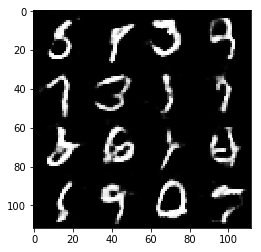

Epoch 2/10... Discriminator Loss: 0.8750... Generator Loss: 2.0494
Epoch 2/10... Discriminator Loss: 0.7099... Generator Loss: 1.7677
Epoch 2/10... Discriminator Loss: 0.5790... Generator Loss: 1.2861
Epoch 2/10... Discriminator Loss: 0.6604... Generator Loss: 1.4703
Epoch 2/10... Discriminator Loss: 1.0461... Generator Loss: 0.6227
Epoch 2/10... Discriminator Loss: 0.5404... Generator Loss: 1.4763
Epoch 2/10... Discriminator Loss: 0.5842... Generator Loss: 1.1600
Epoch 2/10... Discriminator Loss: 0.5936... Generator Loss: 1.2024
Epoch 2/10... Discriminator Loss: 0.6103... Generator Loss: 1.7275
Epoch 2/10... Discriminator Loss: 0.6718... Generator Loss: 1.0977


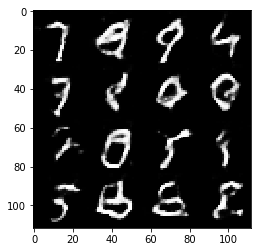

Epoch 2/10... Discriminator Loss: 0.7751... Generator Loss: 0.8974
Epoch 2/10... Discriminator Loss: 0.5457... Generator Loss: 1.7290
Epoch 2/10... Discriminator Loss: 0.5659... Generator Loss: 1.4506
Epoch 2/10... Discriminator Loss: 1.0422... Generator Loss: 0.6212
Epoch 2/10... Discriminator Loss: 0.9353... Generator Loss: 0.7357
Epoch 2/10... Discriminator Loss: 0.5565... Generator Loss: 2.3645
Epoch 2/10... Discriminator Loss: 0.7424... Generator Loss: 1.0896
Epoch 2/10... Discriminator Loss: 0.5686... Generator Loss: 1.5032
Epoch 2/10... Discriminator Loss: 0.4769... Generator Loss: 1.3907
Epoch 2/10... Discriminator Loss: 0.6458... Generator Loss: 1.6226


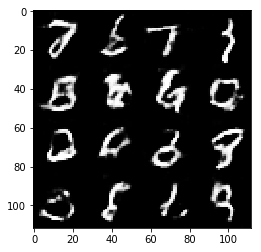

Epoch 2/10... Discriminator Loss: 0.5034... Generator Loss: 1.4111
Epoch 2/10... Discriminator Loss: 0.8271... Generator Loss: 0.7856
Epoch 2/10... Discriminator Loss: 0.6855... Generator Loss: 1.0341
Epoch 2/10... Discriminator Loss: 0.5589... Generator Loss: 1.4515
Epoch 2/10... Discriminator Loss: 0.6050... Generator Loss: 1.1253
Epoch 2/10... Discriminator Loss: 0.6529... Generator Loss: 1.0800
Epoch 2/10... Discriminator Loss: 0.5808... Generator Loss: 1.8845
Epoch 2/10... Discriminator Loss: 0.5189... Generator Loss: 2.1259
Epoch 2/10... Discriminator Loss: 0.8113... Generator Loss: 0.9596
Epoch 2/10... Discriminator Loss: 0.7217... Generator Loss: 1.1000


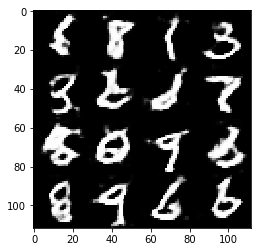

Epoch 2/10... Discriminator Loss: 0.6702... Generator Loss: 1.3029
Epoch 2/10... Discriminator Loss: 0.6495... Generator Loss: 1.9362
Epoch 2/10... Discriminator Loss: 0.6034... Generator Loss: 1.6878
Epoch 2/10... Discriminator Loss: 0.5224... Generator Loss: 1.6037
Epoch 2/10... Discriminator Loss: 0.4553... Generator Loss: 1.4237
Epoch 2/10... Discriminator Loss: 0.5907... Generator Loss: 1.1683
Epoch 2/10... Discriminator Loss: 0.5444... Generator Loss: 1.6336
Epoch 2/10... Discriminator Loss: 0.4207... Generator Loss: 1.8379
Epoch 2/10... Discriminator Loss: 0.4175... Generator Loss: 1.6923
Epoch 2/10... Discriminator Loss: 0.5283... Generator Loss: 1.9362


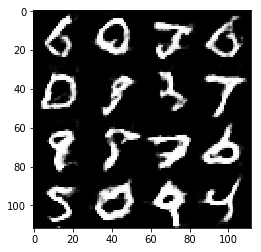

Epoch 2/10... Discriminator Loss: 0.3469... Generator Loss: 2.0164
Epoch 2/10... Discriminator Loss: 0.6908... Generator Loss: 1.1909
Epoch 2/10... Discriminator Loss: 0.5406... Generator Loss: 1.1535
Epoch 2/10... Discriminator Loss: 0.6153... Generator Loss: 1.0796
Epoch 2/10... Discriminator Loss: 0.4979... Generator Loss: 1.4830
Epoch 2/10... Discriminator Loss: 0.6133... Generator Loss: 1.2912
Epoch 2/10... Discriminator Loss: 0.6279... Generator Loss: 1.1051
Epoch 2/10... Discriminator Loss: 0.5279... Generator Loss: 1.6680
Epoch 2/10... Discriminator Loss: 0.6189... Generator Loss: 1.4993
Epoch 2/10... Discriminator Loss: 0.3906... Generator Loss: 1.9164


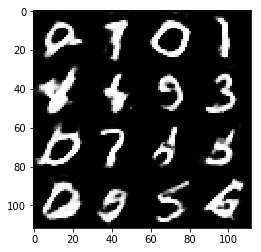

Epoch 2/10... Discriminator Loss: 0.8151... Generator Loss: 0.9675
Epoch 2/10... Discriminator Loss: 0.5380... Generator Loss: 1.6752
Epoch 2/10... Discriminator Loss: 0.6892... Generator Loss: 1.1284
Epoch 2/10... Discriminator Loss: 0.6067... Generator Loss: 1.1172
Epoch 2/10... Discriminator Loss: 0.5437... Generator Loss: 2.0734
Epoch 2/10... Discriminator Loss: 0.4424... Generator Loss: 1.4282
Epoch 2/10... Discriminator Loss: 0.5017... Generator Loss: 1.5742
Epoch 2/10... Discriminator Loss: 0.4229... Generator Loss: 1.7502
Epoch 2/10... Discriminator Loss: 1.3997... Generator Loss: 0.4171
Epoch 2/10... Discriminator Loss: 0.7415... Generator Loss: 0.9195


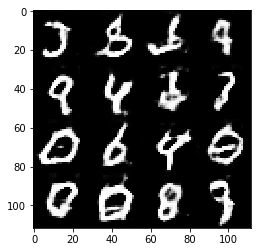

Epoch 2/10... Discriminator Loss: 0.6096... Generator Loss: 1.8250
Epoch 2/10... Discriminator Loss: 0.5007... Generator Loss: 1.3504
Epoch 2/10... Discriminator Loss: 0.5265... Generator Loss: 1.4120
Epoch 2/10... Discriminator Loss: 0.6840... Generator Loss: 0.9908
Epoch 2/10... Discriminator Loss: 0.6978... Generator Loss: 0.9714
Epoch 2/10... Discriminator Loss: 0.6395... Generator Loss: 1.1666
Epoch 2/10... Discriminator Loss: 0.6025... Generator Loss: 1.2273
Epoch 2/10... Discriminator Loss: 0.5345... Generator Loss: 1.5782
Epoch 2/10... Discriminator Loss: 0.5675... Generator Loss: 1.1873
Epoch 2/10... Discriminator Loss: 0.6511... Generator Loss: 1.9068


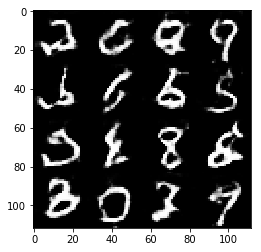

Epoch 2/10... Discriminator Loss: 0.5570... Generator Loss: 1.1698
Epoch 2/10... Discriminator Loss: 0.6455... Generator Loss: 1.8741
Epoch 2/10... Discriminator Loss: 0.6093... Generator Loss: 1.2328
Epoch 2/10... Discriminator Loss: 0.8185... Generator Loss: 2.5814
Epoch 2/10... Discriminator Loss: 0.5166... Generator Loss: 1.8611
Epoch 2/10... Discriminator Loss: 0.4439... Generator Loss: 1.6023
Epoch 2/10... Discriminator Loss: 0.4390... Generator Loss: 1.7861
Epoch 2/10... Discriminator Loss: 0.4793... Generator Loss: 1.7463
Epoch 2/10... Discriminator Loss: 0.5495... Generator Loss: 1.2646
Epoch 2/10... Discriminator Loss: 0.6297... Generator Loss: 1.0238


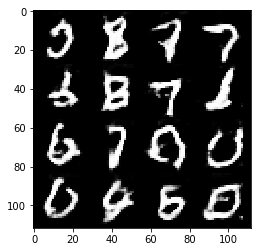

Epoch 2/10... Discriminator Loss: 0.6436... Generator Loss: 1.2434
Epoch 2/10... Discriminator Loss: 0.4285... Generator Loss: 1.5732
Epoch 2/10... Discriminator Loss: 0.5332... Generator Loss: 1.5623
Epoch 2/10... Discriminator Loss: 0.3851... Generator Loss: 2.0869
Epoch 2/10... Discriminator Loss: 0.5846... Generator Loss: 1.7578
Epoch 2/10... Discriminator Loss: 0.3932... Generator Loss: 1.8560
Epoch 2/10... Discriminator Loss: 0.6553... Generator Loss: 1.1108
Epoch 2/10... Discriminator Loss: 0.5522... Generator Loss: 1.1972
Epoch 2/10... Discriminator Loss: 0.4452... Generator Loss: 2.8657
Epoch 2/10... Discriminator Loss: 0.6541... Generator Loss: 1.5035


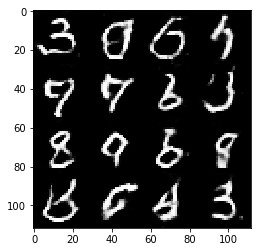

Epoch 2/10... Discriminator Loss: 0.5788... Generator Loss: 1.1432
Epoch 2/10... Discriminator Loss: 0.6357... Generator Loss: 1.5821
Epoch 2/10... Discriminator Loss: 1.0462... Generator Loss: 0.6595
Epoch 2/10... Discriminator Loss: 0.4512... Generator Loss: 1.5478
Epoch 2/10... Discriminator Loss: 0.5672... Generator Loss: 1.2861
Epoch 2/10... Discriminator Loss: 0.5526... Generator Loss: 1.2298
Epoch 2/10... Discriminator Loss: 0.3508... Generator Loss: 2.6119
Epoch 2/10... Discriminator Loss: 0.4660... Generator Loss: 1.5841
Epoch 2/10... Discriminator Loss: 0.5734... Generator Loss: 1.9102
Epoch 2/10... Discriminator Loss: 0.5069... Generator Loss: 1.8135


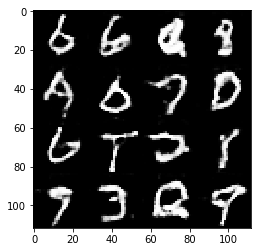

Epoch 2/10... Discriminator Loss: 0.3893... Generator Loss: 1.9408
Epoch 2/10... Discriminator Loss: 0.4979... Generator Loss: 1.6286
Epoch 2/10... Discriminator Loss: 0.4834... Generator Loss: 1.5834
Epoch 2/10... Discriminator Loss: 0.5012... Generator Loss: 1.3221
Epoch 2/10... Discriminator Loss: 0.3686... Generator Loss: 1.7895
Epoch 2/10... Discriminator Loss: 0.4766... Generator Loss: 1.5544
Epoch 2/10... Discriminator Loss: 0.3888... Generator Loss: 1.4581
Epoch 2/10... Discriminator Loss: 0.4445... Generator Loss: 1.4133
Epoch 2/10... Discriminator Loss: 0.4911... Generator Loss: 1.3991
Epoch 2/10... Discriminator Loss: 1.5500... Generator Loss: 1.5386


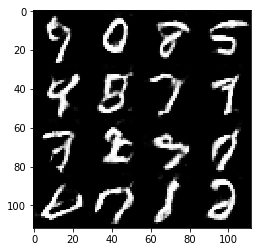

Epoch 2/10... Discriminator Loss: 0.3773... Generator Loss: 2.3925
Epoch 2/10... Discriminator Loss: 0.9548... Generator Loss: 3.3471
Epoch 2/10... Discriminator Loss: 0.3785... Generator Loss: 2.0523
Epoch 2/10... Discriminator Loss: 0.9626... Generator Loss: 0.6289
Epoch 2/10... Discriminator Loss: 0.4495... Generator Loss: 1.7369
Epoch 2/10... Discriminator Loss: 0.5908... Generator Loss: 1.3161
Epoch 2/10... Discriminator Loss: 0.4156... Generator Loss: 1.6868
Epoch 2/10... Discriminator Loss: 0.5816... Generator Loss: 1.4495
Epoch 2/10... Discriminator Loss: 0.7076... Generator Loss: 0.9624
Epoch 2/10... Discriminator Loss: 0.8805... Generator Loss: 2.7877


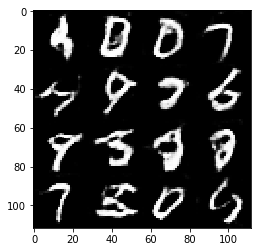

Epoch 2/10... Discriminator Loss: 0.3703... Generator Loss: 2.3943
Epoch 2/10... Discriminator Loss: 0.4828... Generator Loss: 1.4374
Epoch 2/10... Discriminator Loss: 0.4565... Generator Loss: 1.6579
Epoch 2/10... Discriminator Loss: 0.4025... Generator Loss: 1.7360
Epoch 2/10... Discriminator Loss: 0.5291... Generator Loss: 1.1589
Epoch 3/10... Discriminator Loss: 1.0979... Generator Loss: 0.8881
Epoch 3/10... Discriminator Loss: 0.6223... Generator Loss: 1.2846
Epoch 3/10... Discriminator Loss: 0.7529... Generator Loss: 0.9052
Epoch 3/10... Discriminator Loss: 0.6938... Generator Loss: 1.5396
Epoch 3/10... Discriminator Loss: 0.4653... Generator Loss: 1.7524


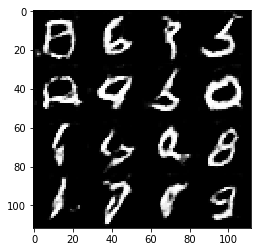

Epoch 3/10... Discriminator Loss: 0.5851... Generator Loss: 1.6589
Epoch 3/10... Discriminator Loss: 0.5531... Generator Loss: 1.3411
Epoch 3/10... Discriminator Loss: 0.4844... Generator Loss: 1.3438
Epoch 3/10... Discriminator Loss: 0.3576... Generator Loss: 2.3098
Epoch 3/10... Discriminator Loss: 0.3642... Generator Loss: 1.9039
Epoch 3/10... Discriminator Loss: 0.6070... Generator Loss: 1.2675
Epoch 3/10... Discriminator Loss: 0.3644... Generator Loss: 1.7378
Epoch 3/10... Discriminator Loss: 0.3911... Generator Loss: 1.9861
Epoch 3/10... Discriminator Loss: 0.7680... Generator Loss: 0.7896
Epoch 3/10... Discriminator Loss: 0.5654... Generator Loss: 1.3342


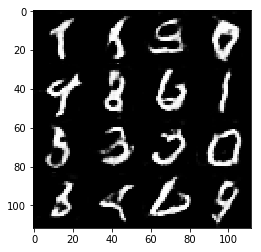

Epoch 3/10... Discriminator Loss: 0.3544... Generator Loss: 1.9723
Epoch 3/10... Discriminator Loss: 0.9468... Generator Loss: 0.6337
Epoch 3/10... Discriminator Loss: 0.4137... Generator Loss: 1.7823
Epoch 3/10... Discriminator Loss: 0.4172... Generator Loss: 1.6908
Epoch 3/10... Discriminator Loss: 0.7621... Generator Loss: 0.8773
Epoch 3/10... Discriminator Loss: 0.7565... Generator Loss: 0.9983
Epoch 3/10... Discriminator Loss: 0.3385... Generator Loss: 1.9960
Epoch 3/10... Discriminator Loss: 0.3754... Generator Loss: 1.6866
Epoch 3/10... Discriminator Loss: 0.3850... Generator Loss: 1.7673
Epoch 3/10... Discriminator Loss: 0.5897... Generator Loss: 1.1378


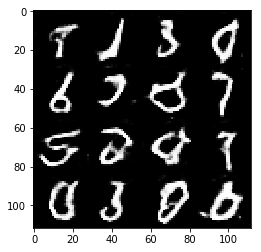

Epoch 3/10... Discriminator Loss: 0.3727... Generator Loss: 1.6746
Epoch 3/10... Discriminator Loss: 0.4605... Generator Loss: 2.0633
Epoch 3/10... Discriminator Loss: 0.4763... Generator Loss: 1.3549
Epoch 3/10... Discriminator Loss: 0.6466... Generator Loss: 1.0200
Epoch 3/10... Discriminator Loss: 0.9897... Generator Loss: 0.5497
Epoch 3/10... Discriminator Loss: 0.4527... Generator Loss: 1.5741
Epoch 3/10... Discriminator Loss: 0.6666... Generator Loss: 0.9390
Epoch 3/10... Discriminator Loss: 0.4719... Generator Loss: 1.6365
Epoch 3/10... Discriminator Loss: 0.4729... Generator Loss: 1.8038
Epoch 3/10... Discriminator Loss: 0.7700... Generator Loss: 0.8039


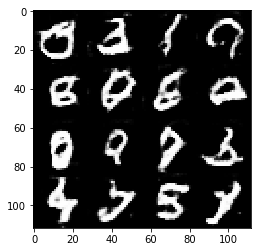

Epoch 3/10... Discriminator Loss: 0.5356... Generator Loss: 1.1731
Epoch 3/10... Discriminator Loss: 0.5836... Generator Loss: 1.2814
Epoch 3/10... Discriminator Loss: 0.5941... Generator Loss: 1.2784
Epoch 3/10... Discriminator Loss: 0.3410... Generator Loss: 2.0319
Epoch 3/10... Discriminator Loss: 0.4514... Generator Loss: 1.4078
Epoch 3/10... Discriminator Loss: 1.1019... Generator Loss: 0.5371
Epoch 3/10... Discriminator Loss: 0.3019... Generator Loss: 2.3575
Epoch 3/10... Discriminator Loss: 0.3815... Generator Loss: 1.8379
Epoch 3/10... Discriminator Loss: 1.0400... Generator Loss: 0.6129
Epoch 3/10... Discriminator Loss: 0.4353... Generator Loss: 1.8261


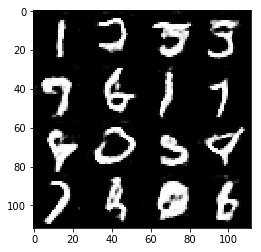

Epoch 3/10... Discriminator Loss: 0.4894... Generator Loss: 1.3631
Epoch 3/10... Discriminator Loss: 0.3222... Generator Loss: 1.9624
Epoch 3/10... Discriminator Loss: 0.6959... Generator Loss: 0.9476
Epoch 3/10... Discriminator Loss: 0.4749... Generator Loss: 1.7569
Epoch 3/10... Discriminator Loss: 0.3656... Generator Loss: 1.9213
Epoch 3/10... Discriminator Loss: 0.4664... Generator Loss: 1.7535
Epoch 3/10... Discriminator Loss: 0.3464... Generator Loss: 1.9288
Epoch 3/10... Discriminator Loss: 0.5710... Generator Loss: 1.1096
Epoch 3/10... Discriminator Loss: 0.5833... Generator Loss: 1.4563
Epoch 3/10... Discriminator Loss: 0.3057... Generator Loss: 1.8339


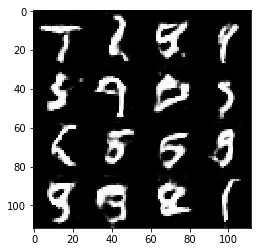

Epoch 3/10... Discriminator Loss: 0.8411... Generator Loss: 2.9367
Epoch 3/10... Discriminator Loss: 0.4135... Generator Loss: 1.9303
Epoch 3/10... Discriminator Loss: 0.4230... Generator Loss: 1.4382
Epoch 3/10... Discriminator Loss: 0.3725... Generator Loss: 1.7760
Epoch 3/10... Discriminator Loss: 0.5537... Generator Loss: 1.2289
Epoch 3/10... Discriminator Loss: 0.5753... Generator Loss: 1.1319
Epoch 3/10... Discriminator Loss: 0.5336... Generator Loss: 1.4333
Epoch 3/10... Discriminator Loss: 0.3315... Generator Loss: 1.7812
Epoch 3/10... Discriminator Loss: 1.2350... Generator Loss: 0.5382
Epoch 3/10... Discriminator Loss: 0.4581... Generator Loss: 1.3309


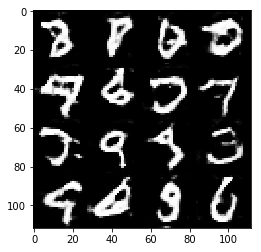

Epoch 3/10... Discriminator Loss: 0.3547... Generator Loss: 1.7557
Epoch 3/10... Discriminator Loss: 0.5764... Generator Loss: 1.5884
Epoch 3/10... Discriminator Loss: 0.4474... Generator Loss: 1.5585
Epoch 3/10... Discriminator Loss: 0.4526... Generator Loss: 1.3851
Epoch 3/10... Discriminator Loss: 0.4039... Generator Loss: 1.7277
Epoch 3/10... Discriminator Loss: 0.4369... Generator Loss: 1.5820
Epoch 3/10... Discriminator Loss: 0.5433... Generator Loss: 1.2436
Epoch 3/10... Discriminator Loss: 0.4454... Generator Loss: 1.6245
Epoch 3/10... Discriminator Loss: 0.4252... Generator Loss: 1.5187
Epoch 3/10... Discriminator Loss: 0.3258... Generator Loss: 2.3538


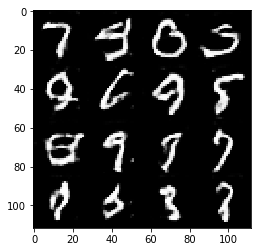

Epoch 3/10... Discriminator Loss: 0.2604... Generator Loss: 2.2442
Epoch 3/10... Discriminator Loss: 0.3625... Generator Loss: 1.8318
Epoch 3/10... Discriminator Loss: 0.3867... Generator Loss: 1.7190
Epoch 3/10... Discriminator Loss: 0.3943... Generator Loss: 2.4057
Epoch 3/10... Discriminator Loss: 0.8270... Generator Loss: 0.8780
Epoch 3/10... Discriminator Loss: 0.3742... Generator Loss: 1.5424
Epoch 3/10... Discriminator Loss: 0.4847... Generator Loss: 1.4113
Epoch 3/10... Discriminator Loss: 0.4086... Generator Loss: 2.0175
Epoch 3/10... Discriminator Loss: 0.3072... Generator Loss: 2.4257
Epoch 3/10... Discriminator Loss: 0.4094... Generator Loss: 1.5290


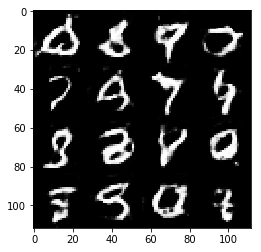

Epoch 3/10... Discriminator Loss: 0.3462... Generator Loss: 1.9677
Epoch 3/10... Discriminator Loss: 0.4378... Generator Loss: 1.4629
Epoch 3/10... Discriminator Loss: 1.5425... Generator Loss: 0.3169
Epoch 3/10... Discriminator Loss: 0.3885... Generator Loss: 2.1784
Epoch 3/10... Discriminator Loss: 0.2735... Generator Loss: 2.2047
Epoch 3/10... Discriminator Loss: 0.6031... Generator Loss: 2.0748
Epoch 3/10... Discriminator Loss: 0.3497... Generator Loss: 1.7711
Epoch 3/10... Discriminator Loss: 0.5202... Generator Loss: 1.8803
Epoch 3/10... Discriminator Loss: 0.6483... Generator Loss: 1.1271
Epoch 3/10... Discriminator Loss: 0.4188... Generator Loss: 1.9038


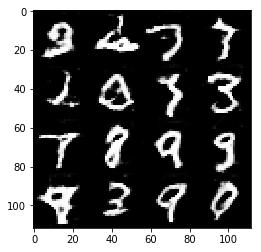

Epoch 3/10... Discriminator Loss: 0.3995... Generator Loss: 1.7484
Epoch 3/10... Discriminator Loss: 0.4993... Generator Loss: 1.4362
Epoch 3/10... Discriminator Loss: 0.4110... Generator Loss: 1.8027
Epoch 3/10... Discriminator Loss: 0.4347... Generator Loss: 1.3274
Epoch 3/10... Discriminator Loss: 0.4005... Generator Loss: 2.1104
Epoch 3/10... Discriminator Loss: 0.6319... Generator Loss: 0.9409
Epoch 3/10... Discriminator Loss: 0.4770... Generator Loss: 1.6365
Epoch 3/10... Discriminator Loss: 0.5613... Generator Loss: 1.1075
Epoch 3/10... Discriminator Loss: 0.4343... Generator Loss: 2.0272
Epoch 3/10... Discriminator Loss: 0.3211... Generator Loss: 1.8255


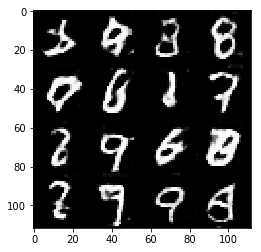

Epoch 3/10... Discriminator Loss: 0.6483... Generator Loss: 1.0280
Epoch 3/10... Discriminator Loss: 0.3267... Generator Loss: 2.0367
Epoch 3/10... Discriminator Loss: 0.3822... Generator Loss: 1.5107
Epoch 3/10... Discriminator Loss: 0.3657... Generator Loss: 1.7429
Epoch 3/10... Discriminator Loss: 0.3492... Generator Loss: 1.9189
Epoch 3/10... Discriminator Loss: 0.5578... Generator Loss: 1.2572
Epoch 3/10... Discriminator Loss: 0.6315... Generator Loss: 3.0181
Epoch 3/10... Discriminator Loss: 0.4456... Generator Loss: 1.6336
Epoch 3/10... Discriminator Loss: 0.4516... Generator Loss: 1.4613
Epoch 3/10... Discriminator Loss: 0.3616... Generator Loss: 1.7625


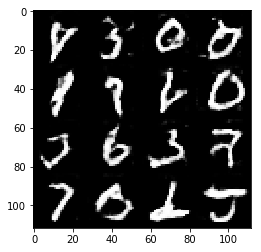

Epoch 3/10... Discriminator Loss: 0.4394... Generator Loss: 1.6373
Epoch 3/10... Discriminator Loss: 0.4850... Generator Loss: 1.3537
Epoch 3/10... Discriminator Loss: 0.5044... Generator Loss: 1.2064
Epoch 3/10... Discriminator Loss: 0.3079... Generator Loss: 2.0883
Epoch 3/10... Discriminator Loss: 0.7802... Generator Loss: 0.8466
Epoch 3/10... Discriminator Loss: 0.4191... Generator Loss: 1.9980
Epoch 3/10... Discriminator Loss: 0.3055... Generator Loss: 2.0740
Epoch 3/10... Discriminator Loss: 0.4351... Generator Loss: 1.4106
Epoch 3/10... Discriminator Loss: 0.5131... Generator Loss: 1.2079
Epoch 3/10... Discriminator Loss: 0.5334... Generator Loss: 3.3462


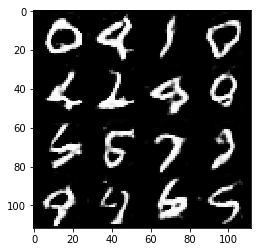

Epoch 3/10... Discriminator Loss: 0.3114... Generator Loss: 2.1779
Epoch 3/10... Discriminator Loss: 0.4379... Generator Loss: 1.5396
Epoch 3/10... Discriminator Loss: 0.2768... Generator Loss: 2.0053
Epoch 3/10... Discriminator Loss: 0.4053... Generator Loss: 1.4940
Epoch 3/10... Discriminator Loss: 1.1044... Generator Loss: 0.6556
Epoch 3/10... Discriminator Loss: 0.3772... Generator Loss: 2.6646
Epoch 3/10... Discriminator Loss: 0.8048... Generator Loss: 0.8386
Epoch 3/10... Discriminator Loss: 0.6218... Generator Loss: 0.9462
Epoch 3/10... Discriminator Loss: 0.3377... Generator Loss: 2.3198
Epoch 3/10... Discriminator Loss: 0.4111... Generator Loss: 1.7646


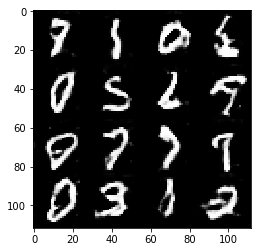

Epoch 3/10... Discriminator Loss: 0.8503... Generator Loss: 0.7728
Epoch 3/10... Discriminator Loss: 0.4223... Generator Loss: 1.7218
Epoch 3/10... Discriminator Loss: 0.3164... Generator Loss: 1.7022
Epoch 3/10... Discriminator Loss: 0.3926... Generator Loss: 1.8771
Epoch 3/10... Discriminator Loss: 0.4770... Generator Loss: 1.6101
Epoch 3/10... Discriminator Loss: 0.2576... Generator Loss: 2.0909
Epoch 3/10... Discriminator Loss: 0.4159... Generator Loss: 1.6432
Epoch 3/10... Discriminator Loss: 0.9311... Generator Loss: 4.3958
Epoch 3/10... Discriminator Loss: 0.5495... Generator Loss: 1.6482
Epoch 3/10... Discriminator Loss: 0.3671... Generator Loss: 1.7296


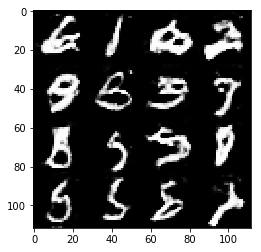

Epoch 3/10... Discriminator Loss: 0.3453... Generator Loss: 1.7363
Epoch 3/10... Discriminator Loss: 0.6110... Generator Loss: 1.0723
Epoch 3/10... Discriminator Loss: 0.2563... Generator Loss: 2.2285
Epoch 3/10... Discriminator Loss: 0.4728... Generator Loss: 1.7100
Epoch 3/10... Discriminator Loss: 0.3059... Generator Loss: 1.7917
Epoch 3/10... Discriminator Loss: 0.8108... Generator Loss: 0.7304
Epoch 3/10... Discriminator Loss: 0.4354... Generator Loss: 1.4793
Epoch 3/10... Discriminator Loss: 0.4243... Generator Loss: 1.8616
Epoch 3/10... Discriminator Loss: 0.3019... Generator Loss: 2.0954
Epoch 3/10... Discriminator Loss: 0.3287... Generator Loss: 2.0065


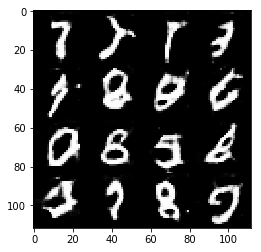

Epoch 3/10... Discriminator Loss: 0.4449... Generator Loss: 1.6114
Epoch 3/10... Discriminator Loss: 0.4687... Generator Loss: 1.9671
Epoch 3/10... Discriminator Loss: 0.4742... Generator Loss: 1.3718
Epoch 3/10... Discriminator Loss: 0.2765... Generator Loss: 2.1551
Epoch 3/10... Discriminator Loss: 0.4145... Generator Loss: 1.5135
Epoch 3/10... Discriminator Loss: 0.3362... Generator Loss: 2.1015
Epoch 3/10... Discriminator Loss: 0.4074... Generator Loss: 2.3862
Epoch 3/10... Discriminator Loss: 0.3318... Generator Loss: 1.8939
Epoch 3/10... Discriminator Loss: 0.3764... Generator Loss: 1.8197
Epoch 3/10... Discriminator Loss: 0.3226... Generator Loss: 1.7136


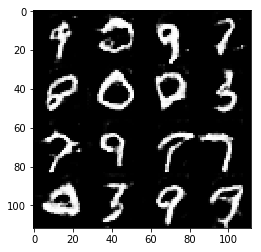

Epoch 3/10... Discriminator Loss: 0.3413... Generator Loss: 1.8265
Epoch 3/10... Discriminator Loss: 0.7373... Generator Loss: 1.0172
Epoch 3/10... Discriminator Loss: 0.3655... Generator Loss: 2.2065
Epoch 3/10... Discriminator Loss: 0.5253... Generator Loss: 1.2579
Epoch 3/10... Discriminator Loss: 0.4673... Generator Loss: 1.4833
Epoch 3/10... Discriminator Loss: 0.3844... Generator Loss: 1.8529
Epoch 3/10... Discriminator Loss: 1.4207... Generator Loss: 5.0288
Epoch 3/10... Discriminator Loss: 0.4947... Generator Loss: 2.1357
Epoch 3/10... Discriminator Loss: 6.7709... Generator Loss: 8.5432
Epoch 3/10... Discriminator Loss: 0.8779... Generator Loss: 0.9909


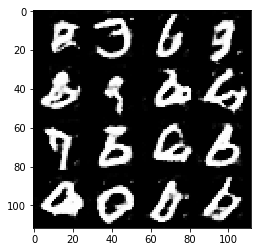

Epoch 3/10... Discriminator Loss: 0.3552... Generator Loss: 2.5224
Epoch 3/10... Discriminator Loss: 0.6204... Generator Loss: 1.1948
Epoch 3/10... Discriminator Loss: 0.4449... Generator Loss: 1.6006
Epoch 3/10... Discriminator Loss: 0.4467... Generator Loss: 1.4356
Epoch 3/10... Discriminator Loss: 0.2953... Generator Loss: 2.4993
Epoch 3/10... Discriminator Loss: 0.5478... Generator Loss: 1.3166
Epoch 3/10... Discriminator Loss: 0.3393... Generator Loss: 1.7417
Epoch 3/10... Discriminator Loss: 0.4695... Generator Loss: 1.4972
Epoch 3/10... Discriminator Loss: 0.2636... Generator Loss: 2.4877
Epoch 3/10... Discriminator Loss: 0.4166... Generator Loss: 1.7771


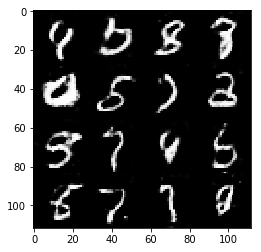

Epoch 3/10... Discriminator Loss: 0.5530... Generator Loss: 1.3472
Epoch 3/10... Discriminator Loss: 0.2533... Generator Loss: 2.3232
Epoch 4/10... Discriminator Loss: 0.4031... Generator Loss: 1.4622
Epoch 4/10... Discriminator Loss: 0.4007... Generator Loss: 1.7497
Epoch 4/10... Discriminator Loss: 0.1944... Generator Loss: 2.4206
Epoch 4/10... Discriminator Loss: 0.5155... Generator Loss: 1.2827
Epoch 4/10... Discriminator Loss: 0.3265... Generator Loss: 2.0472
Epoch 4/10... Discriminator Loss: 0.5066... Generator Loss: 1.1497
Epoch 4/10... Discriminator Loss: 0.3782... Generator Loss: 1.7309
Epoch 4/10... Discriminator Loss: 0.3176... Generator Loss: 2.7356


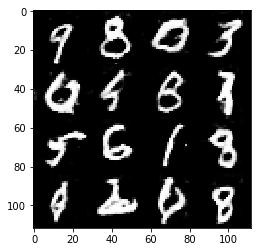

Epoch 4/10... Discriminator Loss: 0.3090... Generator Loss: 2.3146
Epoch 4/10... Discriminator Loss: 0.5112... Generator Loss: 1.2969
Epoch 4/10... Discriminator Loss: 0.4797... Generator Loss: 1.3458
Epoch 4/10... Discriminator Loss: 0.3049... Generator Loss: 2.4947
Epoch 4/10... Discriminator Loss: 0.4345... Generator Loss: 2.0577
Epoch 4/10... Discriminator Loss: 0.4851... Generator Loss: 1.4120
Epoch 4/10... Discriminator Loss: 0.4237... Generator Loss: 1.6599
Epoch 4/10... Discriminator Loss: 0.3901... Generator Loss: 1.8013
Epoch 4/10... Discriminator Loss: 0.2681... Generator Loss: 2.1274
Epoch 4/10... Discriminator Loss: 0.3862... Generator Loss: 1.6104


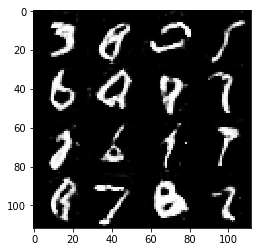

Epoch 4/10... Discriminator Loss: 0.3913... Generator Loss: 1.5970
Epoch 4/10... Discriminator Loss: 0.3748... Generator Loss: 1.5893
Epoch 4/10... Discriminator Loss: 0.5849... Generator Loss: 1.2966
Epoch 4/10... Discriminator Loss: 0.2785... Generator Loss: 2.2749
Epoch 4/10... Discriminator Loss: 0.3212... Generator Loss: 2.6388
Epoch 4/10... Discriminator Loss: 0.3846... Generator Loss: 1.7314
Epoch 4/10... Discriminator Loss: 0.3804... Generator Loss: 2.0108
Epoch 4/10... Discriminator Loss: 0.2399... Generator Loss: 2.0835
Epoch 4/10... Discriminator Loss: 0.2314... Generator Loss: 2.3629
Epoch 4/10... Discriminator Loss: 0.4648... Generator Loss: 1.4220


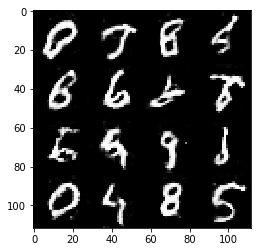

Epoch 4/10... Discriminator Loss: 0.6420... Generator Loss: 1.1203
Epoch 4/10... Discriminator Loss: 0.4969... Generator Loss: 1.3448
Epoch 4/10... Discriminator Loss: 0.3060... Generator Loss: 2.3665
Epoch 4/10... Discriminator Loss: 0.3091... Generator Loss: 1.9774
Epoch 4/10... Discriminator Loss: 0.3256... Generator Loss: 1.7903
Epoch 4/10... Discriminator Loss: 0.2796... Generator Loss: 2.1799
Epoch 4/10... Discriminator Loss: 0.2656... Generator Loss: 2.1147
Epoch 4/10... Discriminator Loss: 0.4060... Generator Loss: 1.8159
Epoch 4/10... Discriminator Loss: 0.2868... Generator Loss: 2.0100
Epoch 4/10... Discriminator Loss: 0.5017... Generator Loss: 1.5925


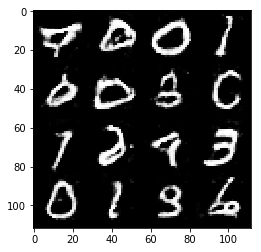

Epoch 4/10... Discriminator Loss: 0.3610... Generator Loss: 1.6670
Epoch 4/10... Discriminator Loss: 0.4309... Generator Loss: 1.5173
Epoch 4/10... Discriminator Loss: 0.3057... Generator Loss: 1.8573
Epoch 4/10... Discriminator Loss: 0.4040... Generator Loss: 1.5599
Epoch 4/10... Discriminator Loss: 0.3946... Generator Loss: 1.3957
Epoch 4/10... Discriminator Loss: 0.4405... Generator Loss: 1.6777
Epoch 4/10... Discriminator Loss: 0.4638... Generator Loss: 1.4633
Epoch 4/10... Discriminator Loss: 0.7821... Generator Loss: 1.1085
Epoch 4/10... Discriminator Loss: 0.6550... Generator Loss: 1.2378
Epoch 4/10... Discriminator Loss: 0.2562... Generator Loss: 2.3879


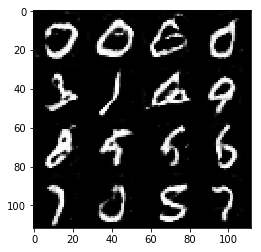

Epoch 4/10... Discriminator Loss: 0.3998... Generator Loss: 1.5976
Epoch 4/10... Discriminator Loss: 0.4769... Generator Loss: 1.4913
Epoch 4/10... Discriminator Loss: 0.3015... Generator Loss: 2.0242
Epoch 4/10... Discriminator Loss: 0.4105... Generator Loss: 1.7812
Epoch 4/10... Discriminator Loss: 0.3383... Generator Loss: 1.6470
Epoch 4/10... Discriminator Loss: 0.5245... Generator Loss: 1.2756
Epoch 4/10... Discriminator Loss: 0.3150... Generator Loss: 2.1059
Epoch 4/10... Discriminator Loss: 0.3496... Generator Loss: 1.7534
Epoch 4/10... Discriminator Loss: 0.4541... Generator Loss: 1.7175
Epoch 4/10... Discriminator Loss: 0.4001... Generator Loss: 1.9999


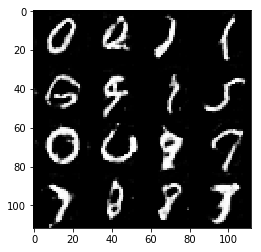

Epoch 4/10... Discriminator Loss: 0.3299... Generator Loss: 1.8970
Epoch 4/10... Discriminator Loss: 0.5838... Generator Loss: 1.2235
Epoch 4/10... Discriminator Loss: 0.4466... Generator Loss: 1.3471
Epoch 4/10... Discriminator Loss: 0.4290... Generator Loss: 1.5209
Epoch 4/10... Discriminator Loss: 0.4205... Generator Loss: 1.6712
Epoch 4/10... Discriminator Loss: 0.3716... Generator Loss: 1.9074
Epoch 4/10... Discriminator Loss: 0.3760... Generator Loss: 2.2688
Epoch 4/10... Discriminator Loss: 0.5776... Generator Loss: 2.5781
Epoch 4/10... Discriminator Loss: 1.1343... Generator Loss: 3.1438
Epoch 4/10... Discriminator Loss: 0.4015... Generator Loss: 1.8447


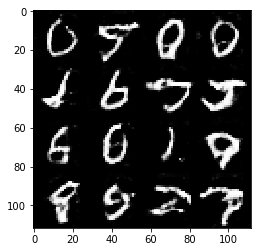

Epoch 4/10... Discriminator Loss: 0.4503... Generator Loss: 1.7640
Epoch 4/10... Discriminator Loss: 0.2757... Generator Loss: 1.9144
Epoch 4/10... Discriminator Loss: 0.3518... Generator Loss: 1.8262
Epoch 4/10... Discriminator Loss: 0.3734... Generator Loss: 1.9652
Epoch 4/10... Discriminator Loss: 0.3979... Generator Loss: 1.7191
Epoch 4/10... Discriminator Loss: 0.4487... Generator Loss: 1.4898
Epoch 4/10... Discriminator Loss: 0.3105... Generator Loss: 1.8730
Epoch 4/10... Discriminator Loss: 0.3777... Generator Loss: 1.6441
Epoch 4/10... Discriminator Loss: 0.5115... Generator Loss: 2.0461
Epoch 4/10... Discriminator Loss: 0.3663... Generator Loss: 1.7105


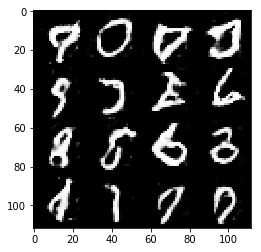

Epoch 4/10... Discriminator Loss: 0.5206... Generator Loss: 2.1369
Epoch 4/10... Discriminator Loss: 0.5960... Generator Loss: 1.1828
Epoch 4/10... Discriminator Loss: 0.4449... Generator Loss: 2.3711
Epoch 4/10... Discriminator Loss: 0.2494... Generator Loss: 2.0483
Epoch 4/10... Discriminator Loss: 0.6345... Generator Loss: 1.3768
Epoch 4/10... Discriminator Loss: 0.2757... Generator Loss: 2.2124
Epoch 4/10... Discriminator Loss: 0.3877... Generator Loss: 1.6692
Epoch 4/10... Discriminator Loss: 0.5024... Generator Loss: 1.2374
Epoch 4/10... Discriminator Loss: 0.4573... Generator Loss: 1.4072
Epoch 4/10... Discriminator Loss: 0.3164... Generator Loss: 2.0215


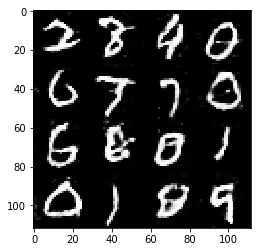

Epoch 4/10... Discriminator Loss: 0.4232... Generator Loss: 1.5962
Epoch 4/10... Discriminator Loss: 0.5787... Generator Loss: 2.6978
Epoch 4/10... Discriminator Loss: 0.2695... Generator Loss: 2.1998
Epoch 4/10... Discriminator Loss: 0.5919... Generator Loss: 1.1612
Epoch 4/10... Discriminator Loss: 0.6218... Generator Loss: 3.0913
Epoch 4/10... Discriminator Loss: 0.6674... Generator Loss: 2.7971
Epoch 4/10... Discriminator Loss: 0.5474... Generator Loss: 1.8279
Epoch 4/10... Discriminator Loss: 0.4096... Generator Loss: 1.8042
Epoch 4/10... Discriminator Loss: 0.4573... Generator Loss: 1.8043
Epoch 4/10... Discriminator Loss: 0.5123... Generator Loss: 1.3275


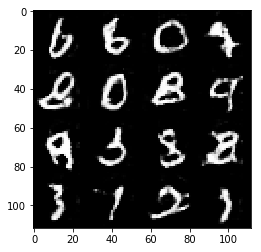

Epoch 4/10... Discriminator Loss: 0.3893... Generator Loss: 1.9902
Epoch 4/10... Discriminator Loss: 0.2879... Generator Loss: 2.1811
Epoch 4/10... Discriminator Loss: 0.3453... Generator Loss: 1.8438
Epoch 4/10... Discriminator Loss: 0.3338... Generator Loss: 2.0695
Epoch 4/10... Discriminator Loss: 0.4510... Generator Loss: 1.4085
Epoch 4/10... Discriminator Loss: 0.2520... Generator Loss: 2.9158
Epoch 4/10... Discriminator Loss: 0.5800... Generator Loss: 1.2667
Epoch 4/10... Discriminator Loss: 0.2453... Generator Loss: 2.2003
Epoch 4/10... Discriminator Loss: 0.3747... Generator Loss: 1.8768
Epoch 4/10... Discriminator Loss: 0.2758... Generator Loss: 2.3069


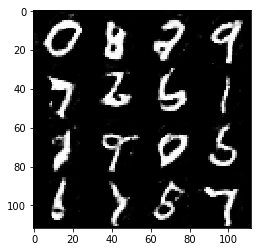

Epoch 4/10... Discriminator Loss: 0.3825... Generator Loss: 1.6534
Epoch 4/10... Discriminator Loss: 0.3909... Generator Loss: 1.6516
Epoch 4/10... Discriminator Loss: 0.6159... Generator Loss: 1.2860
Epoch 4/10... Discriminator Loss: 0.3895... Generator Loss: 1.8628
Epoch 4/10... Discriminator Loss: 0.3033... Generator Loss: 2.0031
Epoch 4/10... Discriminator Loss: 0.5427... Generator Loss: 1.7358
Epoch 4/10... Discriminator Loss: 0.3561... Generator Loss: 2.1054
Epoch 4/10... Discriminator Loss: 0.5474... Generator Loss: 1.2792
Epoch 4/10... Discriminator Loss: 0.5648... Generator Loss: 1.1841
Epoch 4/10... Discriminator Loss: 0.4729... Generator Loss: 1.5984


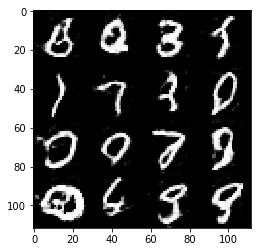

Epoch 4/10... Discriminator Loss: 0.3426... Generator Loss: 2.2339
Epoch 4/10... Discriminator Loss: 0.2623... Generator Loss: 2.1610
Epoch 4/10... Discriminator Loss: 0.4474... Generator Loss: 1.7568
Epoch 4/10... Discriminator Loss: 1.5901... Generator Loss: 0.4003
Epoch 4/10... Discriminator Loss: 0.4459... Generator Loss: 1.4112
Epoch 4/10... Discriminator Loss: 0.3742... Generator Loss: 2.0244
Epoch 4/10... Discriminator Loss: 0.4418... Generator Loss: 2.2318
Epoch 4/10... Discriminator Loss: 0.4607... Generator Loss: 1.6825
Epoch 4/10... Discriminator Loss: 0.4001... Generator Loss: 1.4605
Epoch 4/10... Discriminator Loss: 0.4036... Generator Loss: 1.6652


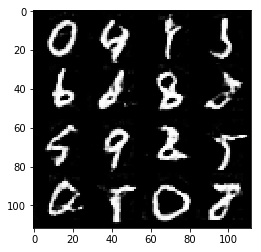

Epoch 4/10... Discriminator Loss: 0.5155... Generator Loss: 1.6764
Epoch 4/10... Discriminator Loss: 0.3690... Generator Loss: 1.7601
Epoch 4/10... Discriminator Loss: 0.4735... Generator Loss: 1.5339
Epoch 4/10... Discriminator Loss: 0.4496... Generator Loss: 1.6073
Epoch 4/10... Discriminator Loss: 0.4100... Generator Loss: 1.7362
Epoch 4/10... Discriminator Loss: 0.3643... Generator Loss: 2.0904
Epoch 4/10... Discriminator Loss: 0.5605... Generator Loss: 1.4149
Epoch 4/10... Discriminator Loss: 0.7910... Generator Loss: 0.8516
Epoch 4/10... Discriminator Loss: 0.3316... Generator Loss: 2.4452
Epoch 4/10... Discriminator Loss: 0.3312... Generator Loss: 1.7000


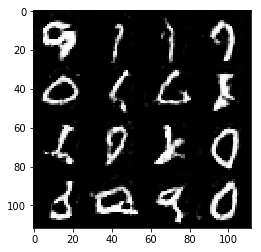

Epoch 4/10... Discriminator Loss: 0.2892... Generator Loss: 2.5241
Epoch 4/10... Discriminator Loss: 0.2792... Generator Loss: 1.9796
Epoch 4/10... Discriminator Loss: 0.3168... Generator Loss: 1.9744
Epoch 4/10... Discriminator Loss: 0.5644... Generator Loss: 1.2174
Epoch 4/10... Discriminator Loss: 0.3375... Generator Loss: 2.1096
Epoch 4/10... Discriminator Loss: 0.4076... Generator Loss: 1.5992
Epoch 4/10... Discriminator Loss: 0.3853... Generator Loss: 1.8841
Epoch 4/10... Discriminator Loss: 0.3492... Generator Loss: 2.2212
Epoch 4/10... Discriminator Loss: 0.2407... Generator Loss: 2.0494
Epoch 4/10... Discriminator Loss: 0.3719... Generator Loss: 2.0356


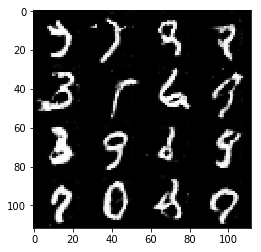

Epoch 4/10... Discriminator Loss: 0.2796... Generator Loss: 2.0991
Epoch 4/10... Discriminator Loss: 0.4482... Generator Loss: 1.3829
Epoch 4/10... Discriminator Loss: 0.5315... Generator Loss: 1.1665
Epoch 4/10... Discriminator Loss: 0.3027... Generator Loss: 3.4119
Epoch 4/10... Discriminator Loss: 0.6112... Generator Loss: 1.1473
Epoch 4/10... Discriminator Loss: 0.3145... Generator Loss: 2.6477
Epoch 4/10... Discriminator Loss: 0.4507... Generator Loss: 1.6662
Epoch 4/10... Discriminator Loss: 0.4747... Generator Loss: 1.9232
Epoch 4/10... Discriminator Loss: 0.3935... Generator Loss: 1.5240
Epoch 4/10... Discriminator Loss: 0.8256... Generator Loss: 0.8935


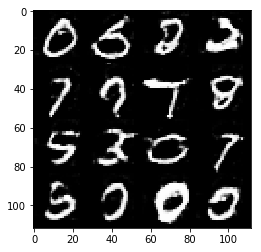

Epoch 4/10... Discriminator Loss: 0.3827... Generator Loss: 1.8296
Epoch 4/10... Discriminator Loss: 0.3968... Generator Loss: 1.8154
Epoch 4/10... Discriminator Loss: 0.4285... Generator Loss: 1.7733
Epoch 4/10... Discriminator Loss: 0.4359... Generator Loss: 1.5873
Epoch 4/10... Discriminator Loss: 0.5445... Generator Loss: 2.1990
Epoch 4/10... Discriminator Loss: 0.3314... Generator Loss: 1.8845
Epoch 4/10... Discriminator Loss: 0.3871... Generator Loss: 2.7256
Epoch 4/10... Discriminator Loss: 0.4209... Generator Loss: 1.4562
Epoch 4/10... Discriminator Loss: 0.3677... Generator Loss: 2.0586
Epoch 4/10... Discriminator Loss: 0.2868... Generator Loss: 2.0288


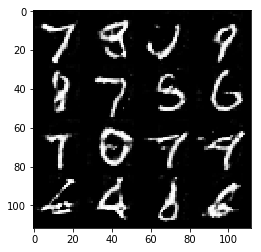

Epoch 4/10... Discriminator Loss: 0.9034... Generator Loss: 0.8779
Epoch 4/10... Discriminator Loss: 0.3363... Generator Loss: 2.2601
Epoch 4/10... Discriminator Loss: 0.4258... Generator Loss: 1.5686
Epoch 4/10... Discriminator Loss: 0.4776... Generator Loss: 1.9761
Epoch 4/10... Discriminator Loss: 0.2970... Generator Loss: 2.0829
Epoch 4/10... Discriminator Loss: 0.1645... Generator Loss: 2.8660
Epoch 4/10... Discriminator Loss: 0.6218... Generator Loss: 1.9986
Epoch 4/10... Discriminator Loss: 0.3723... Generator Loss: 1.7706
Epoch 4/10... Discriminator Loss: 0.4392... Generator Loss: 1.9238
Epoch 4/10... Discriminator Loss: 0.3539... Generator Loss: 2.2600


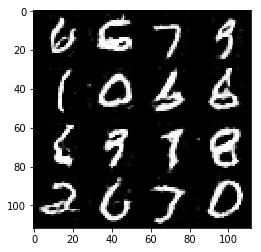

Epoch 4/10... Discriminator Loss: 0.3634... Generator Loss: 1.8436
Epoch 4/10... Discriminator Loss: 0.5168... Generator Loss: 1.2302
Epoch 4/10... Discriminator Loss: 0.7632... Generator Loss: 0.9382
Epoch 4/10... Discriminator Loss: 0.4808... Generator Loss: 1.5107
Epoch 4/10... Discriminator Loss: 0.4388... Generator Loss: 1.5144
Epoch 4/10... Discriminator Loss: 0.3402... Generator Loss: 2.5349
Epoch 4/10... Discriminator Loss: 0.3132... Generator Loss: 2.2571
Epoch 4/10... Discriminator Loss: 0.3537... Generator Loss: 1.9554
Epoch 4/10... Discriminator Loss: 0.4558... Generator Loss: 1.6594
Epoch 4/10... Discriminator Loss: 0.4118... Generator Loss: 1.5496


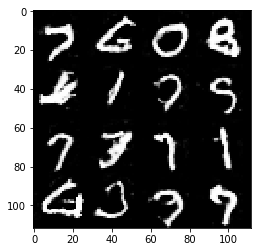

Epoch 5/10... Discriminator Loss: 0.4439... Generator Loss: 3.0105
Epoch 5/10... Discriminator Loss: 0.3815... Generator Loss: 1.6207
Epoch 5/10... Discriminator Loss: 0.4161... Generator Loss: 1.6817
Epoch 5/10... Discriminator Loss: 0.3632... Generator Loss: 1.7929
Epoch 5/10... Discriminator Loss: 0.3430... Generator Loss: 1.8380
Epoch 5/10... Discriminator Loss: 0.5440... Generator Loss: 1.2547
Epoch 5/10... Discriminator Loss: 0.5356... Generator Loss: 1.7403
Epoch 5/10... Discriminator Loss: 0.3996... Generator Loss: 1.5357
Epoch 5/10... Discriminator Loss: 0.3227... Generator Loss: 2.2113
Epoch 5/10... Discriminator Loss: 0.3215... Generator Loss: 2.0340


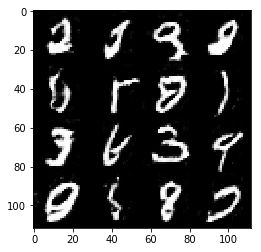

Epoch 5/10... Discriminator Loss: 0.4283... Generator Loss: 1.5152
Epoch 5/10... Discriminator Loss: 0.3708... Generator Loss: 2.1172
Epoch 5/10... Discriminator Loss: 0.4910... Generator Loss: 1.4188
Epoch 5/10... Discriminator Loss: 0.9245... Generator Loss: 0.6506
Epoch 5/10... Discriminator Loss: 0.7396... Generator Loss: 1.0268
Epoch 5/10... Discriminator Loss: 0.3267... Generator Loss: 1.8406
Epoch 5/10... Discriminator Loss: 0.4910... Generator Loss: 1.2490
Epoch 5/10... Discriminator Loss: 0.2768... Generator Loss: 2.1183
Epoch 5/10... Discriminator Loss: 0.2411... Generator Loss: 2.1138
Epoch 5/10... Discriminator Loss: 0.4970... Generator Loss: 1.2723


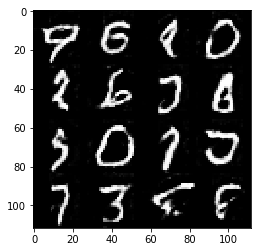

Epoch 5/10... Discriminator Loss: 0.6279... Generator Loss: 1.1183
Epoch 5/10... Discriminator Loss: 0.3180... Generator Loss: 1.8945
Epoch 5/10... Discriminator Loss: 0.3280... Generator Loss: 1.8160
Epoch 5/10... Discriminator Loss: 0.2613... Generator Loss: 2.4176
Epoch 5/10... Discriminator Loss: 0.3555... Generator Loss: 1.7034
Epoch 5/10... Discriminator Loss: 0.3185... Generator Loss: 1.7685
Epoch 5/10... Discriminator Loss: 0.5175... Generator Loss: 1.2513
Epoch 5/10... Discriminator Loss: 0.3166... Generator Loss: 1.8603
Epoch 5/10... Discriminator Loss: 0.5767... Generator Loss: 1.1163
Epoch 5/10... Discriminator Loss: 0.7460... Generator Loss: 0.9061


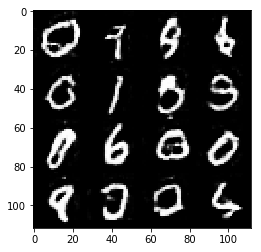

Epoch 5/10... Discriminator Loss: 0.2457... Generator Loss: 2.1994
Epoch 5/10... Discriminator Loss: 0.8319... Generator Loss: 0.8373
Epoch 5/10... Discriminator Loss: 0.4180... Generator Loss: 1.4295
Epoch 5/10... Discriminator Loss: 0.4255... Generator Loss: 1.7266
Epoch 5/10... Discriminator Loss: 0.4212... Generator Loss: 1.6037
Epoch 5/10... Discriminator Loss: 0.3937... Generator Loss: 1.7433
Epoch 5/10... Discriminator Loss: 0.4958... Generator Loss: 1.5776
Epoch 5/10... Discriminator Loss: 0.4853... Generator Loss: 1.9293
Epoch 5/10... Discriminator Loss: 0.3270... Generator Loss: 1.9860
Epoch 5/10... Discriminator Loss: 0.3998... Generator Loss: 1.5287


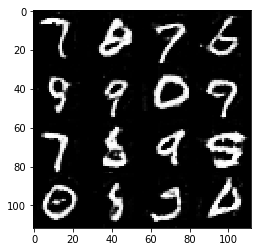

Epoch 5/10... Discriminator Loss: 0.7446... Generator Loss: 0.9035
Epoch 5/10... Discriminator Loss: 0.4680... Generator Loss: 1.9355
Epoch 5/10... Discriminator Loss: 0.2307... Generator Loss: 2.3381
Epoch 5/10... Discriminator Loss: 0.9213... Generator Loss: 0.9028
Epoch 5/10... Discriminator Loss: 0.3614... Generator Loss: 1.8550
Epoch 5/10... Discriminator Loss: 0.3909... Generator Loss: 1.7474
Epoch 5/10... Discriminator Loss: 0.3924... Generator Loss: 1.7737
Epoch 5/10... Discriminator Loss: 0.7647... Generator Loss: 0.9396
Epoch 5/10... Discriminator Loss: 0.4593... Generator Loss: 1.8170
Epoch 5/10... Discriminator Loss: 0.4292... Generator Loss: 1.6061


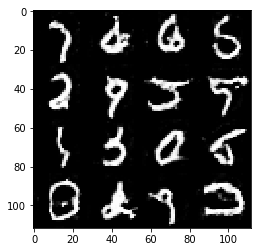

Epoch 5/10... Discriminator Loss: 0.3757... Generator Loss: 1.9033
Epoch 5/10... Discriminator Loss: 0.2505... Generator Loss: 2.0446
Epoch 5/10... Discriminator Loss: 0.4850... Generator Loss: 1.4926
Epoch 5/10... Discriminator Loss: 0.5004... Generator Loss: 1.3797
Epoch 5/10... Discriminator Loss: 0.3119... Generator Loss: 1.9408
Epoch 5/10... Discriminator Loss: 0.5736... Generator Loss: 1.3461
Epoch 5/10... Discriminator Loss: 0.3519... Generator Loss: 1.8406
Epoch 5/10... Discriminator Loss: 0.3216... Generator Loss: 2.2609
Epoch 5/10... Discriminator Loss: 0.3131... Generator Loss: 2.0035
Epoch 5/10... Discriminator Loss: 0.4145... Generator Loss: 1.7431


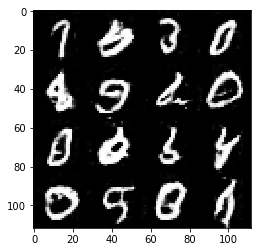

Epoch 5/10... Discriminator Loss: 0.3930... Generator Loss: 1.4384
Epoch 5/10... Discriminator Loss: 0.5855... Generator Loss: 1.1338
Epoch 5/10... Discriminator Loss: 0.3098... Generator Loss: 2.3818
Epoch 5/10... Discriminator Loss: 0.3518... Generator Loss: 2.0909
Epoch 5/10... Discriminator Loss: 0.2659... Generator Loss: 2.1450
Epoch 5/10... Discriminator Loss: 0.2877... Generator Loss: 2.0873
Epoch 5/10... Discriminator Loss: 6.7700... Generator Loss: 8.8958
Epoch 5/10... Discriminator Loss: 0.6851... Generator Loss: 1.6497
Epoch 5/10... Discriminator Loss: 0.3298... Generator Loss: 2.2364
Epoch 5/10... Discriminator Loss: 0.4412... Generator Loss: 2.0401


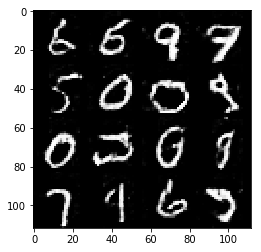

Epoch 5/10... Discriminator Loss: 0.6817... Generator Loss: 1.1323
Epoch 5/10... Discriminator Loss: 0.3411... Generator Loss: 1.9807
Epoch 5/10... Discriminator Loss: 0.3173... Generator Loss: 1.8491
Epoch 5/10... Discriminator Loss: 0.3460... Generator Loss: 1.6550
Epoch 5/10... Discriminator Loss: 0.3262... Generator Loss: 1.9087
Epoch 5/10... Discriminator Loss: 0.2652... Generator Loss: 2.9089
Epoch 5/10... Discriminator Loss: 0.3875... Generator Loss: 2.6697
Epoch 5/10... Discriminator Loss: 0.3263... Generator Loss: 2.3421
Epoch 5/10... Discriminator Loss: 0.3713... Generator Loss: 2.1479
Epoch 5/10... Discriminator Loss: 0.9005... Generator Loss: 0.8711


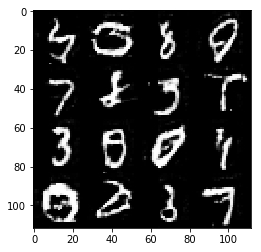

Epoch 5/10... Discriminator Loss: 0.2477... Generator Loss: 2.3076
Epoch 5/10... Discriminator Loss: 0.3192... Generator Loss: 2.0193
Epoch 5/10... Discriminator Loss: 0.4407... Generator Loss: 1.7312
Epoch 5/10... Discriminator Loss: 0.2373... Generator Loss: 2.1969
Epoch 5/10... Discriminator Loss: 0.4181... Generator Loss: 1.5239
Epoch 5/10... Discriminator Loss: 0.2626... Generator Loss: 2.2760
Epoch 5/10... Discriminator Loss: 0.4616... Generator Loss: 1.5075
Epoch 5/10... Discriminator Loss: 0.7879... Generator Loss: 0.8576
Epoch 5/10... Discriminator Loss: 0.3885... Generator Loss: 1.6018
Epoch 5/10... Discriminator Loss: 0.2520... Generator Loss: 2.6493


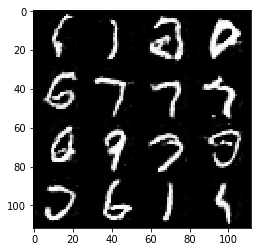

Epoch 5/10... Discriminator Loss: 0.5248... Generator Loss: 1.6435
Epoch 5/10... Discriminator Loss: 0.3602... Generator Loss: 2.1234
Epoch 5/10... Discriminator Loss: 0.7050... Generator Loss: 0.9505
Epoch 5/10... Discriminator Loss: 0.4127... Generator Loss: 1.6034
Epoch 5/10... Discriminator Loss: 0.2321... Generator Loss: 2.6349
Epoch 5/10... Discriminator Loss: 0.4081... Generator Loss: 1.5791
Epoch 5/10... Discriminator Loss: 0.4076... Generator Loss: 1.9075
Epoch 5/10... Discriminator Loss: 0.3805... Generator Loss: 2.0012
Epoch 5/10... Discriminator Loss: 0.4828... Generator Loss: 1.3947
Epoch 5/10... Discriminator Loss: 0.2451... Generator Loss: 2.5179


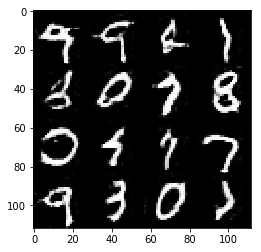

Epoch 5/10... Discriminator Loss: 0.4432... Generator Loss: 1.3571
Epoch 5/10... Discriminator Loss: 0.3947... Generator Loss: 2.0165
Epoch 5/10... Discriminator Loss: 0.3442... Generator Loss: 1.9289
Epoch 5/10... Discriminator Loss: 0.3965... Generator Loss: 1.7117
Epoch 5/10... Discriminator Loss: 0.2599... Generator Loss: 2.0885
Epoch 5/10... Discriminator Loss: 0.5332... Generator Loss: 1.2838
Epoch 5/10... Discriminator Loss: 0.3886... Generator Loss: 1.7009
Epoch 5/10... Discriminator Loss: 0.4017... Generator Loss: 2.0649
Epoch 5/10... Discriminator Loss: 0.3087... Generator Loss: 1.7980
Epoch 5/10... Discriminator Loss: 0.2220... Generator Loss: 2.8140


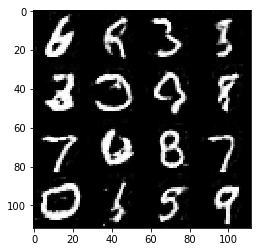

Epoch 5/10... Discriminator Loss: 0.5569... Generator Loss: 1.3113
Epoch 5/10... Discriminator Loss: 0.3300... Generator Loss: 1.8472
Epoch 5/10... Discriminator Loss: 0.3224... Generator Loss: 1.7068
Epoch 5/10... Discriminator Loss: 0.4613... Generator Loss: 1.3814
Epoch 5/10... Discriminator Loss: 0.3145... Generator Loss: 1.8318
Epoch 5/10... Discriminator Loss: 0.5120... Generator Loss: 2.1462
Epoch 5/10... Discriminator Loss: 0.3965... Generator Loss: 1.6462
Epoch 5/10... Discriminator Loss: 0.5075... Generator Loss: 1.1860
Epoch 5/10... Discriminator Loss: 0.2580... Generator Loss: 2.3745
Epoch 5/10... Discriminator Loss: 0.4917... Generator Loss: 1.3407


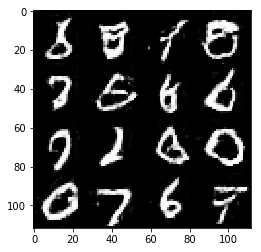

Epoch 5/10... Discriminator Loss: 0.5872... Generator Loss: 1.4234
Epoch 5/10... Discriminator Loss: 0.9174... Generator Loss: 2.9259
Epoch 5/10... Discriminator Loss: 0.3759... Generator Loss: 2.2551
Epoch 5/10... Discriminator Loss: 0.2846... Generator Loss: 1.9438
Epoch 5/10... Discriminator Loss: 0.3023... Generator Loss: 1.9079
Epoch 5/10... Discriminator Loss: 0.3331... Generator Loss: 1.9920
Epoch 5/10... Discriminator Loss: 0.4073... Generator Loss: 1.5158
Epoch 5/10... Discriminator Loss: 0.2237... Generator Loss: 2.2538
Epoch 5/10... Discriminator Loss: 0.3905... Generator Loss: 1.5992
Epoch 5/10... Discriminator Loss: 0.3917... Generator Loss: 2.3204


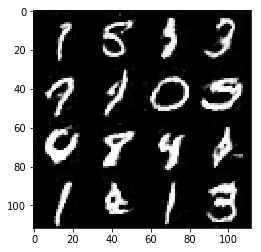

Epoch 5/10... Discriminator Loss: 0.2505... Generator Loss: 2.3364
Epoch 5/10... Discriminator Loss: 0.6644... Generator Loss: 1.0244
Epoch 5/10... Discriminator Loss: 0.3705... Generator Loss: 1.6476
Epoch 5/10... Discriminator Loss: 0.3879... Generator Loss: 1.5250
Epoch 5/10... Discriminator Loss: 0.4430... Generator Loss: 2.2367
Epoch 5/10... Discriminator Loss: 1.0325... Generator Loss: 0.7267
Epoch 5/10... Discriminator Loss: 0.2949... Generator Loss: 2.0423
Epoch 5/10... Discriminator Loss: 0.3319... Generator Loss: 1.7651
Epoch 5/10... Discriminator Loss: 0.3969... Generator Loss: 1.9693
Epoch 5/10... Discriminator Loss: 0.4177... Generator Loss: 1.5720


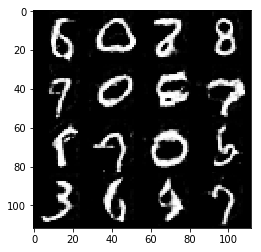

Epoch 5/10... Discriminator Loss: 0.3463... Generator Loss: 1.7038
Epoch 5/10... Discriminator Loss: 0.4414... Generator Loss: 1.4273
Epoch 5/10... Discriminator Loss: 0.3477... Generator Loss: 3.4910
Epoch 5/10... Discriminator Loss: 0.4183... Generator Loss: 2.1057
Epoch 5/10... Discriminator Loss: 0.3164... Generator Loss: 1.8070
Epoch 5/10... Discriminator Loss: 0.3020... Generator Loss: 2.0028
Epoch 5/10... Discriminator Loss: 0.8331... Generator Loss: 0.7512
Epoch 5/10... Discriminator Loss: 0.5385... Generator Loss: 1.1989
Epoch 5/10... Discriminator Loss: 0.8610... Generator Loss: 3.5519
Epoch 5/10... Discriminator Loss: 0.8185... Generator Loss: 1.0787


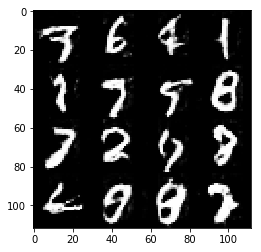

Epoch 5/10... Discriminator Loss: 0.6077... Generator Loss: 1.1674
Epoch 5/10... Discriminator Loss: 0.2821... Generator Loss: 2.2272
Epoch 5/10... Discriminator Loss: 0.4771... Generator Loss: 1.4303
Epoch 5/10... Discriminator Loss: 0.3439... Generator Loss: 2.2038
Epoch 5/10... Discriminator Loss: 0.3526... Generator Loss: 1.7802
Epoch 5/10... Discriminator Loss: 0.3036... Generator Loss: 1.8664
Epoch 5/10... Discriminator Loss: 0.3096... Generator Loss: 1.8546
Epoch 5/10... Discriminator Loss: 0.4408... Generator Loss: 1.8982
Epoch 5/10... Discriminator Loss: 0.2943... Generator Loss: 1.9570
Epoch 5/10... Discriminator Loss: 0.3766... Generator Loss: 1.9735


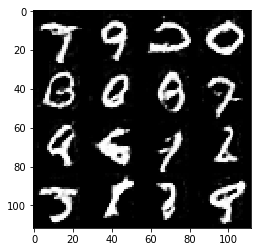

Epoch 5/10... Discriminator Loss: 0.3290... Generator Loss: 2.3782
Epoch 5/10... Discriminator Loss: 0.7091... Generator Loss: 1.0114
Epoch 5/10... Discriminator Loss: 0.3801... Generator Loss: 1.8956
Epoch 5/10... Discriminator Loss: 0.3116... Generator Loss: 2.0784
Epoch 5/10... Discriminator Loss: 0.2807... Generator Loss: 2.4006
Epoch 5/10... Discriminator Loss: 0.2364... Generator Loss: 2.7495
Epoch 5/10... Discriminator Loss: 0.5747... Generator Loss: 1.3763
Epoch 5/10... Discriminator Loss: 0.1869... Generator Loss: 3.1170
Epoch 5/10... Discriminator Loss: 0.3245... Generator Loss: 1.8473
Epoch 5/10... Discriminator Loss: 0.4060... Generator Loss: 1.4132


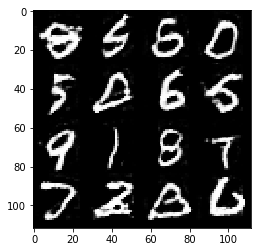

Epoch 5/10... Discriminator Loss: 0.3930... Generator Loss: 1.6099
Epoch 5/10... Discriminator Loss: 0.7039... Generator Loss: 2.4019
Epoch 5/10... Discriminator Loss: 0.4411... Generator Loss: 1.5571
Epoch 5/10... Discriminator Loss: 0.6333... Generator Loss: 2.7324
Epoch 5/10... Discriminator Loss: 0.3401... Generator Loss: 1.9068
Epoch 5/10... Discriminator Loss: 0.4210... Generator Loss: 1.5287
Epoch 5/10... Discriminator Loss: 0.8238... Generator Loss: 0.7912
Epoch 5/10... Discriminator Loss: 0.4093... Generator Loss: 1.4028
Epoch 5/10... Discriminator Loss: 0.2751... Generator Loss: 2.2365
Epoch 5/10... Discriminator Loss: 0.2466... Generator Loss: 2.6204


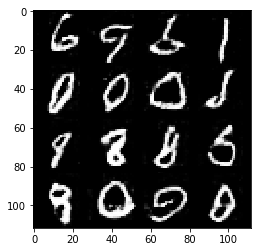

Epoch 5/10... Discriminator Loss: 0.3405... Generator Loss: 1.7781
Epoch 5/10... Discriminator Loss: 0.2970... Generator Loss: 2.0004
Epoch 5/10... Discriminator Loss: 0.4288... Generator Loss: 1.7150
Epoch 5/10... Discriminator Loss: 0.1955... Generator Loss: 2.9511
Epoch 5/10... Discriminator Loss: 0.5515... Generator Loss: 1.3575
Epoch 5/10... Discriminator Loss: 0.5208... Generator Loss: 1.5722
Epoch 5/10... Discriminator Loss: 0.3227... Generator Loss: 2.2754
Epoch 6/10... Discriminator Loss: 0.4096... Generator Loss: 1.5084
Epoch 6/10... Discriminator Loss: 0.2644... Generator Loss: 2.3755
Epoch 6/10... Discriminator Loss: 0.2515... Generator Loss: 2.1604


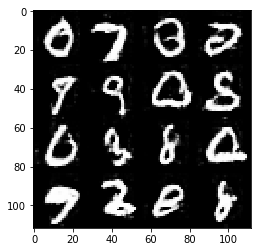

Epoch 6/10... Discriminator Loss: 0.4779... Generator Loss: 2.0696
Epoch 6/10... Discriminator Loss: 0.3866... Generator Loss: 1.8816
Epoch 6/10... Discriminator Loss: 0.5754... Generator Loss: 1.2302
Epoch 6/10... Discriminator Loss: 0.3286... Generator Loss: 2.0738
Epoch 6/10... Discriminator Loss: 0.2800... Generator Loss: 2.3486
Epoch 6/10... Discriminator Loss: 0.3633... Generator Loss: 2.2949
Epoch 6/10... Discriminator Loss: 0.3234... Generator Loss: 2.1426
Epoch 6/10... Discriminator Loss: 0.4615... Generator Loss: 1.5487
Epoch 6/10... Discriminator Loss: 2.4050... Generator Loss: 4.5662
Epoch 6/10... Discriminator Loss: 0.9423... Generator Loss: 0.8991


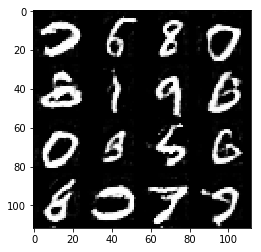

Epoch 6/10... Discriminator Loss: 0.4773... Generator Loss: 2.1340
Epoch 6/10... Discriminator Loss: 0.2626... Generator Loss: 2.5649
Epoch 6/10... Discriminator Loss: 0.6420... Generator Loss: 0.9708
Epoch 6/10... Discriminator Loss: 0.2746... Generator Loss: 2.0426
Epoch 6/10... Discriminator Loss: 0.3996... Generator Loss: 1.6533
Epoch 6/10... Discriminator Loss: 0.2339... Generator Loss: 2.1691
Epoch 6/10... Discriminator Loss: 0.2666... Generator Loss: 2.1083
Epoch 6/10... Discriminator Loss: 0.4349... Generator Loss: 1.7785
Epoch 6/10... Discriminator Loss: 0.3494... Generator Loss: 2.5380
Epoch 6/10... Discriminator Loss: 0.3202... Generator Loss: 2.3873


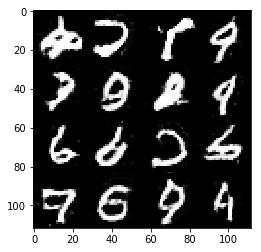

Epoch 6/10... Discriminator Loss: 0.4257... Generator Loss: 1.5101
Epoch 6/10... Discriminator Loss: 0.3699... Generator Loss: 2.1599
Epoch 6/10... Discriminator Loss: 0.3198... Generator Loss: 1.9695
Epoch 6/10... Discriminator Loss: 0.3422... Generator Loss: 1.8094
Epoch 6/10... Discriminator Loss: 0.5178... Generator Loss: 1.3800
Epoch 6/10... Discriminator Loss: 0.3177... Generator Loss: 2.1457
Epoch 6/10... Discriminator Loss: 0.3100... Generator Loss: 2.1774
Epoch 6/10... Discriminator Loss: 0.3333... Generator Loss: 1.9068
Epoch 6/10... Discriminator Loss: 0.1997... Generator Loss: 2.4400
Epoch 6/10... Discriminator Loss: 0.3758... Generator Loss: 1.6983


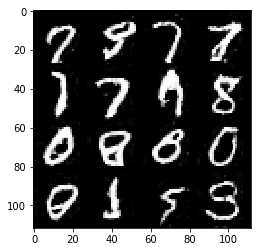

Epoch 6/10... Discriminator Loss: 0.4013... Generator Loss: 2.2572
Epoch 6/10... Discriminator Loss: 0.2587... Generator Loss: 2.8880
Epoch 6/10... Discriminator Loss: 0.4383... Generator Loss: 1.4838
Epoch 6/10... Discriminator Loss: 0.2701... Generator Loss: 2.1813
Epoch 6/10... Discriminator Loss: 0.3576... Generator Loss: 2.1436
Epoch 6/10... Discriminator Loss: 0.2538... Generator Loss: 2.5411
Epoch 6/10... Discriminator Loss: 0.3303... Generator Loss: 2.3461
Epoch 6/10... Discriminator Loss: 0.3271... Generator Loss: 1.9728
Epoch 6/10... Discriminator Loss: 0.3049... Generator Loss: 2.0406
Epoch 6/10... Discriminator Loss: 0.3364... Generator Loss: 1.8406


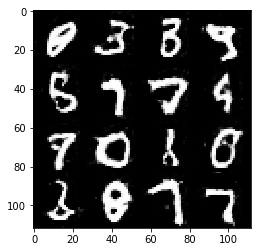

Epoch 6/10... Discriminator Loss: 0.3838... Generator Loss: 1.9174
Epoch 6/10... Discriminator Loss: 0.3154... Generator Loss: 1.8849
Epoch 6/10... Discriminator Loss: 0.4005... Generator Loss: 1.5595
Epoch 6/10... Discriminator Loss: 0.5339... Generator Loss: 1.2427
Epoch 6/10... Discriminator Loss: 0.2112... Generator Loss: 2.7995
Epoch 6/10... Discriminator Loss: 0.5137... Generator Loss: 1.3380
Epoch 6/10... Discriminator Loss: 0.5524... Generator Loss: 2.9001
Epoch 6/10... Discriminator Loss: 0.3312... Generator Loss: 1.7882
Epoch 6/10... Discriminator Loss: 0.4464... Generator Loss: 1.7439
Epoch 6/10... Discriminator Loss: 0.4004... Generator Loss: 1.5582


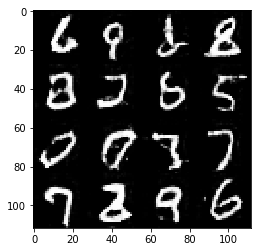

Epoch 6/10... Discriminator Loss: 0.9166... Generator Loss: 0.6459
Epoch 6/10... Discriminator Loss: 0.2290... Generator Loss: 2.5203
Epoch 6/10... Discriminator Loss: 0.3400... Generator Loss: 1.8458
Epoch 6/10... Discriminator Loss: 0.3602... Generator Loss: 2.1940
Epoch 6/10... Discriminator Loss: 0.3844... Generator Loss: 2.1969
Epoch 6/10... Discriminator Loss: 0.3679... Generator Loss: 1.8502
Epoch 6/10... Discriminator Loss: 0.5104... Generator Loss: 1.2177
Epoch 6/10... Discriminator Loss: 0.3274... Generator Loss: 2.0472
Epoch 6/10... Discriminator Loss: 0.3710... Generator Loss: 1.7660
Epoch 6/10... Discriminator Loss: 0.4232... Generator Loss: 1.9639


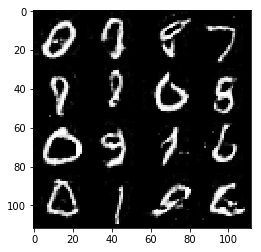

Epoch 6/10... Discriminator Loss: 0.4969... Generator Loss: 1.7832
Epoch 6/10... Discriminator Loss: 0.3116... Generator Loss: 2.2830
Epoch 6/10... Discriminator Loss: 0.2553... Generator Loss: 2.1169
Epoch 6/10... Discriminator Loss: 0.5447... Generator Loss: 1.3353
Epoch 6/10... Discriminator Loss: 0.3666... Generator Loss: 2.1205
Epoch 6/10... Discriminator Loss: 0.3716... Generator Loss: 1.7983
Epoch 6/10... Discriminator Loss: 0.2918... Generator Loss: 2.1264
Epoch 6/10... Discriminator Loss: 0.3214... Generator Loss: 2.0009
Epoch 6/10... Discriminator Loss: 0.2685... Generator Loss: 2.3541
Epoch 6/10... Discriminator Loss: 0.4431... Generator Loss: 1.5429


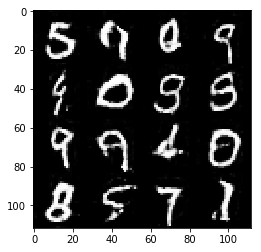

Epoch 6/10... Discriminator Loss: 0.3853... Generator Loss: 1.7050
Epoch 6/10... Discriminator Loss: 0.2328... Generator Loss: 2.3222
Epoch 6/10... Discriminator Loss: 0.2384... Generator Loss: 2.9280
Epoch 6/10... Discriminator Loss: 0.8479... Generator Loss: 1.0537
Epoch 6/10... Discriminator Loss: 0.5135... Generator Loss: 3.7934
Epoch 6/10... Discriminator Loss: 0.5669... Generator Loss: 2.0066
Epoch 6/10... Discriminator Loss: 0.7302... Generator Loss: 1.3709
Epoch 6/10... Discriminator Loss: 0.4511... Generator Loss: 3.2760
Epoch 6/10... Discriminator Loss: 0.3310... Generator Loss: 1.7692
Epoch 6/10... Discriminator Loss: 0.5607... Generator Loss: 1.2051


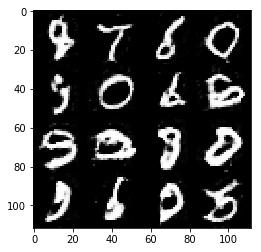

Epoch 6/10... Discriminator Loss: 0.2322... Generator Loss: 2.4830
Epoch 6/10... Discriminator Loss: 0.5128... Generator Loss: 1.4466
Epoch 6/10... Discriminator Loss: 0.4152... Generator Loss: 1.6764
Epoch 6/10... Discriminator Loss: 0.3513... Generator Loss: 2.1603
Epoch 6/10... Discriminator Loss: 0.3433... Generator Loss: 1.7734
Epoch 6/10... Discriminator Loss: 0.3762... Generator Loss: 2.0138
Epoch 6/10... Discriminator Loss: 0.3233... Generator Loss: 2.3832
Epoch 6/10... Discriminator Loss: 0.1734... Generator Loss: 2.6952
Epoch 6/10... Discriminator Loss: 0.4533... Generator Loss: 1.5295
Epoch 6/10... Discriminator Loss: 0.3270... Generator Loss: 2.5593


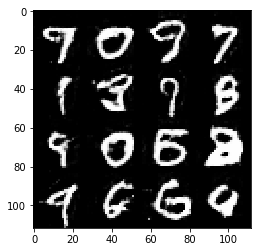

Epoch 6/10... Discriminator Loss: 0.4971... Generator Loss: 1.3681
Epoch 6/10... Discriminator Loss: 0.4670... Generator Loss: 2.0197
Epoch 6/10... Discriminator Loss: 0.3025... Generator Loss: 1.9338
Epoch 6/10... Discriminator Loss: 0.3024... Generator Loss: 2.2276
Epoch 6/10... Discriminator Loss: 0.4127... Generator Loss: 1.5394
Epoch 6/10... Discriminator Loss: 0.3820... Generator Loss: 1.5407
Epoch 6/10... Discriminator Loss: 0.4069... Generator Loss: 1.5239
Epoch 6/10... Discriminator Loss: 0.3261... Generator Loss: 1.9537
Epoch 6/10... Discriminator Loss: 0.2873... Generator Loss: 2.0111
Epoch 6/10... Discriminator Loss: 0.3514... Generator Loss: 2.2702


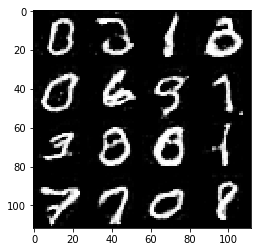

Epoch 6/10... Discriminator Loss: 0.2400... Generator Loss: 2.0699
Epoch 6/10... Discriminator Loss: 0.5739... Generator Loss: 1.1436
Epoch 6/10... Discriminator Loss: 0.2369... Generator Loss: 2.2811
Epoch 6/10... Discriminator Loss: 0.4856... Generator Loss: 1.4164
Epoch 6/10... Discriminator Loss: 0.3168... Generator Loss: 1.8511
Epoch 6/10... Discriminator Loss: 0.3631... Generator Loss: 2.4439
Epoch 6/10... Discriminator Loss: 0.3504... Generator Loss: 1.7798
Epoch 6/10... Discriminator Loss: 0.5172... Generator Loss: 1.3950
Epoch 6/10... Discriminator Loss: 0.3891... Generator Loss: 1.8846
Epoch 6/10... Discriminator Loss: 0.3140... Generator Loss: 2.4285


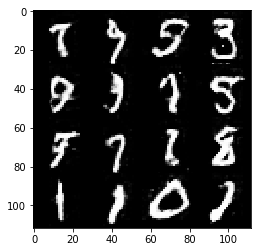

Epoch 6/10... Discriminator Loss: 0.5732... Generator Loss: 1.2540
Epoch 6/10... Discriminator Loss: 0.2934... Generator Loss: 2.1111
Epoch 6/10... Discriminator Loss: 0.3647... Generator Loss: 1.8880
Epoch 6/10... Discriminator Loss: 0.3302... Generator Loss: 1.8073
Epoch 6/10... Discriminator Loss: 0.2930... Generator Loss: 2.4754
Epoch 6/10... Discriminator Loss: 0.2666... Generator Loss: 1.9794
Epoch 6/10... Discriminator Loss: 0.2238... Generator Loss: 2.5507
Epoch 6/10... Discriminator Loss: 0.3407... Generator Loss: 1.7817
Epoch 6/10... Discriminator Loss: 0.4730... Generator Loss: 1.9602
Epoch 6/10... Discriminator Loss: 0.3443... Generator Loss: 1.7483


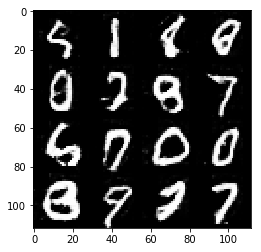

Epoch 6/10... Discriminator Loss: 0.2437... Generator Loss: 2.6168
Epoch 6/10... Discriminator Loss: 0.4184... Generator Loss: 1.6745
Epoch 6/10... Discriminator Loss: 0.3491... Generator Loss: 2.0069
Epoch 6/10... Discriminator Loss: 0.2868... Generator Loss: 2.0028
Epoch 6/10... Discriminator Loss: 0.4265... Generator Loss: 1.4715
Epoch 6/10... Discriminator Loss: 0.4680... Generator Loss: 1.4883
Epoch 6/10... Discriminator Loss: 0.3585... Generator Loss: 2.0668
Epoch 6/10... Discriminator Loss: 2.1044... Generator Loss: 3.6295
Epoch 6/10... Discriminator Loss: 3.4392... Generator Loss: 0.0953
Epoch 6/10... Discriminator Loss: 0.6622... Generator Loss: 2.1582


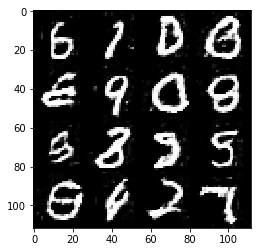

Epoch 6/10... Discriminator Loss: 1.5608... Generator Loss: 0.4791
Epoch 6/10... Discriminator Loss: 0.5273... Generator Loss: 2.3832
Epoch 6/10... Discriminator Loss: 0.5687... Generator Loss: 1.3445
Epoch 6/10... Discriminator Loss: 0.4551... Generator Loss: 1.8922
Epoch 6/10... Discriminator Loss: 0.5277... Generator Loss: 2.3484
Epoch 6/10... Discriminator Loss: 0.3906... Generator Loss: 3.2465
Epoch 6/10... Discriminator Loss: 0.3808... Generator Loss: 1.8803
Epoch 6/10... Discriminator Loss: 0.3037... Generator Loss: 2.2290
Epoch 6/10... Discriminator Loss: 0.4862... Generator Loss: 1.3959
Epoch 6/10... Discriminator Loss: 0.4000... Generator Loss: 1.8614


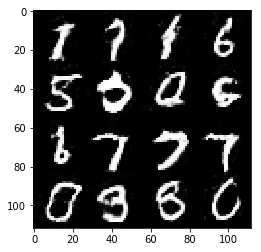

Epoch 6/10... Discriminator Loss: 0.4243... Generator Loss: 1.5800
Epoch 6/10... Discriminator Loss: 0.2654... Generator Loss: 2.2198
Epoch 6/10... Discriminator Loss: 0.4349... Generator Loss: 1.8738
Epoch 6/10... Discriminator Loss: 0.3010... Generator Loss: 2.8048
Epoch 6/10... Discriminator Loss: 0.4513... Generator Loss: 2.5784
Epoch 6/10... Discriminator Loss: 0.3144... Generator Loss: 2.2177
Epoch 6/10... Discriminator Loss: 0.4351... Generator Loss: 1.8026
Epoch 6/10... Discriminator Loss: 0.6180... Generator Loss: 1.0888
Epoch 6/10... Discriminator Loss: 0.2072... Generator Loss: 3.5350
Epoch 6/10... Discriminator Loss: 0.5150... Generator Loss: 1.3329


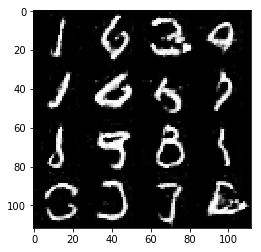

Epoch 6/10... Discriminator Loss: 0.4108... Generator Loss: 1.8718
Epoch 6/10... Discriminator Loss: 0.5811... Generator Loss: 1.4146
Epoch 6/10... Discriminator Loss: 0.4489... Generator Loss: 1.9786
Epoch 6/10... Discriminator Loss: 0.3414... Generator Loss: 1.8240
Epoch 6/10... Discriminator Loss: 0.5350... Generator Loss: 1.2374
Epoch 6/10... Discriminator Loss: 0.4497... Generator Loss: 1.8401
Epoch 6/10... Discriminator Loss: 0.3346... Generator Loss: 2.3344
Epoch 6/10... Discriminator Loss: 0.2453... Generator Loss: 3.0219
Epoch 6/10... Discriminator Loss: 0.4272... Generator Loss: 1.6305
Epoch 6/10... Discriminator Loss: 0.3107... Generator Loss: 2.4796


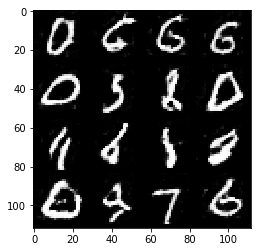

Epoch 6/10... Discriminator Loss: 0.4803... Generator Loss: 1.4836
Epoch 6/10... Discriminator Loss: 0.2849... Generator Loss: 2.3851
Epoch 6/10... Discriminator Loss: 0.4031... Generator Loss: 1.5892
Epoch 6/10... Discriminator Loss: 0.3258... Generator Loss: 2.2394
Epoch 6/10... Discriminator Loss: 0.2506... Generator Loss: 2.1034
Epoch 6/10... Discriminator Loss: 0.5103... Generator Loss: 1.4221
Epoch 6/10... Discriminator Loss: 0.2654... Generator Loss: 2.1574
Epoch 6/10... Discriminator Loss: 0.5098... Generator Loss: 1.5002
Epoch 6/10... Discriminator Loss: 0.5730... Generator Loss: 1.1429
Epoch 6/10... Discriminator Loss: 0.2063... Generator Loss: 2.6918


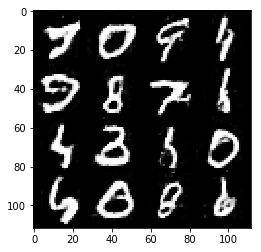

Epoch 6/10... Discriminator Loss: 0.1671... Generator Loss: 2.8057
Epoch 6/10... Discriminator Loss: 0.5252... Generator Loss: 1.2685
Epoch 6/10... Discriminator Loss: 0.3180... Generator Loss: 1.8859
Epoch 6/10... Discriminator Loss: 0.4305... Generator Loss: 1.5133
Epoch 6/10... Discriminator Loss: 0.3449... Generator Loss: 1.8840
Epoch 6/10... Discriminator Loss: 0.3582... Generator Loss: 1.6236
Epoch 6/10... Discriminator Loss: 0.3587... Generator Loss: 2.1935
Epoch 6/10... Discriminator Loss: 0.5895... Generator Loss: 1.2302
Epoch 6/10... Discriminator Loss: 0.5854... Generator Loss: 1.3486
Epoch 6/10... Discriminator Loss: 0.3832... Generator Loss: 2.2488


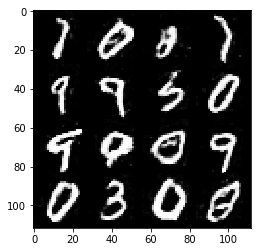

Epoch 6/10... Discriminator Loss: 0.2265... Generator Loss: 2.5073
Epoch 6/10... Discriminator Loss: 0.2348... Generator Loss: 2.6163
Epoch 6/10... Discriminator Loss: 0.4229... Generator Loss: 3.2069
Epoch 6/10... Discriminator Loss: 0.4051... Generator Loss: 1.8547
Epoch 6/10... Discriminator Loss: 0.3231... Generator Loss: 1.7411
Epoch 7/10... Discriminator Loss: 0.2386... Generator Loss: 3.0078
Epoch 7/10... Discriminator Loss: 0.5353... Generator Loss: 1.1671
Epoch 7/10... Discriminator Loss: 0.4441... Generator Loss: 2.0292
Epoch 7/10... Discriminator Loss: 0.3092... Generator Loss: 2.4134
Epoch 7/10... Discriminator Loss: 0.3247... Generator Loss: 1.8960


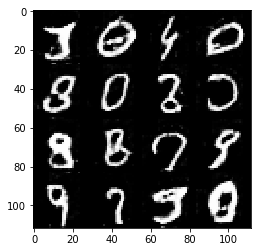

Epoch 7/10... Discriminator Loss: 0.5960... Generator Loss: 1.2587
Epoch 7/10... Discriminator Loss: 0.5691... Generator Loss: 1.5483
Epoch 7/10... Discriminator Loss: 0.4213... Generator Loss: 1.5568
Epoch 7/10... Discriminator Loss: 0.3050... Generator Loss: 2.5477
Epoch 7/10... Discriminator Loss: 0.2080... Generator Loss: 2.6253
Epoch 7/10... Discriminator Loss: 0.5397... Generator Loss: 1.5128
Epoch 7/10... Discriminator Loss: 0.3092... Generator Loss: 2.1061
Epoch 7/10... Discriminator Loss: 0.7938... Generator Loss: 0.8495
Epoch 7/10... Discriminator Loss: 0.4622... Generator Loss: 1.5366
Epoch 7/10... Discriminator Loss: 0.4869... Generator Loss: 1.4175


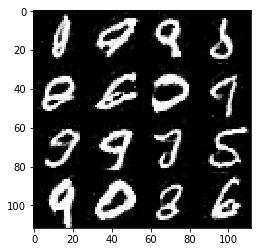

Epoch 7/10... Discriminator Loss: 0.2571... Generator Loss: 2.0698
Epoch 7/10... Discriminator Loss: 0.7719... Generator Loss: 0.9889
Epoch 7/10... Discriminator Loss: 0.4393... Generator Loss: 1.6560
Epoch 7/10... Discriminator Loss: 0.2887... Generator Loss: 2.2153
Epoch 7/10... Discriminator Loss: 0.5071... Generator Loss: 2.5386
Epoch 7/10... Discriminator Loss: 0.7525... Generator Loss: 1.2139
Epoch 7/10... Discriminator Loss: 0.4075... Generator Loss: 1.4648
Epoch 7/10... Discriminator Loss: 0.2672... Generator Loss: 2.3677
Epoch 7/10... Discriminator Loss: 0.2955... Generator Loss: 2.0073
Epoch 7/10... Discriminator Loss: 0.7348... Generator Loss: 0.9250


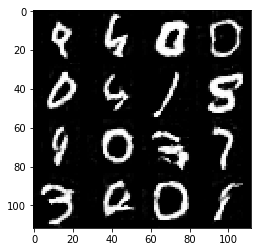

Epoch 7/10... Discriminator Loss: 0.3198... Generator Loss: 1.8307
Epoch 7/10... Discriminator Loss: 0.5029... Generator Loss: 1.5684
Epoch 7/10... Discriminator Loss: 0.4991... Generator Loss: 1.5585
Epoch 7/10... Discriminator Loss: 0.8959... Generator Loss: 0.7402
Epoch 7/10... Discriminator Loss: 0.5799... Generator Loss: 1.1100
Epoch 7/10... Discriminator Loss: 0.2430... Generator Loss: 2.2527
Epoch 7/10... Discriminator Loss: 0.7425... Generator Loss: 0.9691
Epoch 7/10... Discriminator Loss: 0.5612... Generator Loss: 1.3366
Epoch 7/10... Discriminator Loss: 0.3654... Generator Loss: 1.9001
Epoch 7/10... Discriminator Loss: 0.4992... Generator Loss: 1.3344


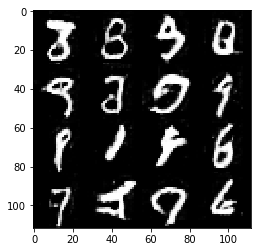

Epoch 7/10... Discriminator Loss: 0.3408... Generator Loss: 2.1416
Epoch 7/10... Discriminator Loss: 0.5047... Generator Loss: 2.6494
Epoch 7/10... Discriminator Loss: 0.5327... Generator Loss: 1.4444
Epoch 7/10... Discriminator Loss: 0.2934... Generator Loss: 1.9226
Epoch 7/10... Discriminator Loss: 0.3147... Generator Loss: 1.9940
Epoch 7/10... Discriminator Loss: 0.5789... Generator Loss: 1.0938
Epoch 7/10... Discriminator Loss: 0.2360... Generator Loss: 2.4281
Epoch 7/10... Discriminator Loss: 0.2928... Generator Loss: 2.2271
Epoch 7/10... Discriminator Loss: 0.9550... Generator Loss: 0.9463
Epoch 7/10... Discriminator Loss: 0.3940... Generator Loss: 1.6344


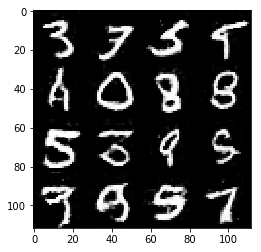

Epoch 7/10... Discriminator Loss: 0.5271... Generator Loss: 1.6178
Epoch 7/10... Discriminator Loss: 0.3309... Generator Loss: 2.1172
Epoch 7/10... Discriminator Loss: 0.4671... Generator Loss: 1.6921
Epoch 7/10... Discriminator Loss: 0.6237... Generator Loss: 1.3111
Epoch 7/10... Discriminator Loss: 0.3361... Generator Loss: 1.7291
Epoch 7/10... Discriminator Loss: 0.5712... Generator Loss: 1.3947
Epoch 7/10... Discriminator Loss: 0.3192... Generator Loss: 1.8569
Epoch 7/10... Discriminator Loss: 0.3246... Generator Loss: 2.0251
Epoch 7/10... Discriminator Loss: 0.5633... Generator Loss: 1.2836
Epoch 7/10... Discriminator Loss: 1.7615... Generator Loss: 0.4821


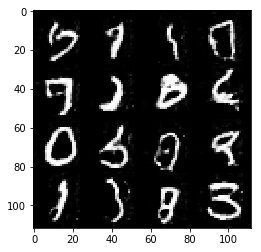

Epoch 7/10... Discriminator Loss: 1.1478... Generator Loss: 1.0550
Epoch 7/10... Discriminator Loss: 0.4873... Generator Loss: 1.8272
Epoch 7/10... Discriminator Loss: 0.5027... Generator Loss: 1.6565
Epoch 7/10... Discriminator Loss: 0.6458... Generator Loss: 1.2255
Epoch 7/10... Discriminator Loss: 0.4043... Generator Loss: 1.8872
Epoch 7/10... Discriminator Loss: 0.4341... Generator Loss: 1.7191
Epoch 7/10... Discriminator Loss: 0.5229... Generator Loss: 1.3574
Epoch 7/10... Discriminator Loss: 0.3609... Generator Loss: 2.3169
Epoch 7/10... Discriminator Loss: 0.3772... Generator Loss: 2.3407
Epoch 7/10... Discriminator Loss: 0.2466... Generator Loss: 2.5036


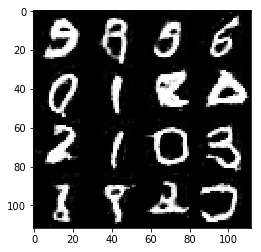

Epoch 7/10... Discriminator Loss: 0.3380... Generator Loss: 1.7054
Epoch 7/10... Discriminator Loss: 0.4501... Generator Loss: 2.4261
Epoch 7/10... Discriminator Loss: 0.6735... Generator Loss: 1.0335
Epoch 7/10... Discriminator Loss: 0.3438... Generator Loss: 1.8745
Epoch 7/10... Discriminator Loss: 0.2523... Generator Loss: 2.5449
Epoch 7/10... Discriminator Loss: 0.3560... Generator Loss: 1.8512
Epoch 7/10... Discriminator Loss: 0.2561... Generator Loss: 2.3012
Epoch 7/10... Discriminator Loss: 0.3872... Generator Loss: 1.9292
Epoch 7/10... Discriminator Loss: 0.4092... Generator Loss: 1.5013
Epoch 7/10... Discriminator Loss: 0.3455... Generator Loss: 1.8580


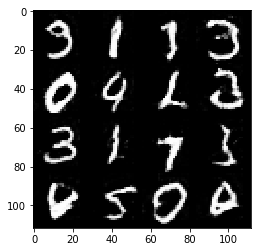

Epoch 7/10... Discriminator Loss: 0.1896... Generator Loss: 2.4478
Epoch 7/10... Discriminator Loss: 0.3932... Generator Loss: 1.6655
Epoch 7/10... Discriminator Loss: 0.3403... Generator Loss: 2.2959
Epoch 7/10... Discriminator Loss: 0.4585... Generator Loss: 1.7586
Epoch 7/10... Discriminator Loss: 1.0799... Generator Loss: 0.8140
Epoch 7/10... Discriminator Loss: 0.2630... Generator Loss: 2.1088
Epoch 7/10... Discriminator Loss: 0.3364... Generator Loss: 1.8062
Epoch 7/10... Discriminator Loss: 0.4489... Generator Loss: 1.7353
Epoch 7/10... Discriminator Loss: 0.3277... Generator Loss: 1.9029
Epoch 7/10... Discriminator Loss: 0.3777... Generator Loss: 2.7033


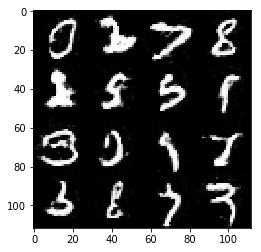

Epoch 7/10... Discriminator Loss: 0.3242... Generator Loss: 2.3795
Epoch 7/10... Discriminator Loss: 0.5015... Generator Loss: 1.2670
Epoch 7/10... Discriminator Loss: 0.5742... Generator Loss: 1.1714
Epoch 7/10... Discriminator Loss: 0.4108... Generator Loss: 1.6237
Epoch 7/10... Discriminator Loss: 0.2299... Generator Loss: 2.8831
Epoch 7/10... Discriminator Loss: 0.4647... Generator Loss: 1.6253
Epoch 7/10... Discriminator Loss: 0.3862... Generator Loss: 2.1078
Epoch 7/10... Discriminator Loss: 0.5090... Generator Loss: 1.8763
Epoch 7/10... Discriminator Loss: 0.3917... Generator Loss: 1.7246
Epoch 7/10... Discriminator Loss: 0.3860... Generator Loss: 2.1052


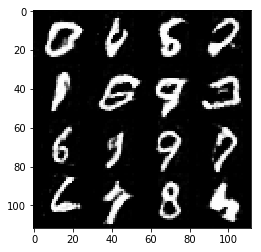

Epoch 7/10... Discriminator Loss: 0.4172... Generator Loss: 1.9080
Epoch 7/10... Discriminator Loss: 0.5085... Generator Loss: 1.4828
Epoch 7/10... Discriminator Loss: 0.3151... Generator Loss: 2.1281
Epoch 7/10... Discriminator Loss: 0.9178... Generator Loss: 0.7618
Epoch 7/10... Discriminator Loss: 0.2719... Generator Loss: 2.2594
Epoch 7/10... Discriminator Loss: 0.4073... Generator Loss: 1.8620
Epoch 7/10... Discriminator Loss: 0.4442... Generator Loss: 1.9203
Epoch 7/10... Discriminator Loss: 0.3891... Generator Loss: 2.2815
Epoch 7/10... Discriminator Loss: 0.5734... Generator Loss: 1.1865
Epoch 7/10... Discriminator Loss: 0.2706... Generator Loss: 2.1307


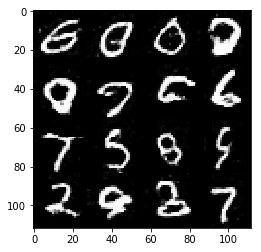

Epoch 7/10... Discriminator Loss: 0.5466... Generator Loss: 1.2188
Epoch 7/10... Discriminator Loss: 0.2847... Generator Loss: 2.1237
Epoch 7/10... Discriminator Loss: 0.5060... Generator Loss: 1.3678
Epoch 7/10... Discriminator Loss: 0.5181... Generator Loss: 1.4442
Epoch 7/10... Discriminator Loss: 0.2604... Generator Loss: 2.7201
Epoch 7/10... Discriminator Loss: 0.9039... Generator Loss: 0.9288
Epoch 7/10... Discriminator Loss: 0.3520... Generator Loss: 1.9812
Epoch 7/10... Discriminator Loss: 0.3476... Generator Loss: 2.0371
Epoch 7/10... Discriminator Loss: 0.4649... Generator Loss: 1.3702
Epoch 7/10... Discriminator Loss: 0.4637... Generator Loss: 1.7978


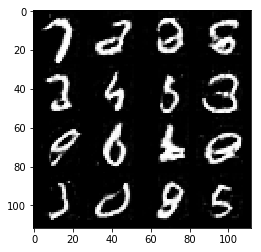

Epoch 7/10... Discriminator Loss: 0.3769... Generator Loss: 1.6582
Epoch 7/10... Discriminator Loss: 0.3872... Generator Loss: 1.9049
Epoch 7/10... Discriminator Loss: 0.4826... Generator Loss: 1.3834
Epoch 7/10... Discriminator Loss: 0.3396... Generator Loss: 1.6871
Epoch 7/10... Discriminator Loss: 0.4890... Generator Loss: 1.4027
Epoch 7/10... Discriminator Loss: 0.4868... Generator Loss: 1.7869
Epoch 7/10... Discriminator Loss: 0.4486... Generator Loss: 1.5990
Epoch 7/10... Discriminator Loss: 0.3375... Generator Loss: 1.7432
Epoch 7/10... Discriminator Loss: 0.3674... Generator Loss: 1.7333
Epoch 7/10... Discriminator Loss: 0.2886... Generator Loss: 2.2923


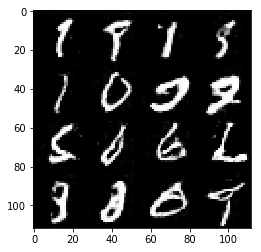

Epoch 7/10... Discriminator Loss: 0.2789... Generator Loss: 2.5835
Epoch 7/10... Discriminator Loss: 0.5100... Generator Loss: 1.3356
Epoch 7/10... Discriminator Loss: 0.2885... Generator Loss: 2.0966
Epoch 7/10... Discriminator Loss: 0.4484... Generator Loss: 1.4802
Epoch 7/10... Discriminator Loss: 0.5018... Generator Loss: 1.7314
Epoch 7/10... Discriminator Loss: 0.3106... Generator Loss: 2.8709
Epoch 7/10... Discriminator Loss: 0.6066... Generator Loss: 1.0889
Epoch 7/10... Discriminator Loss: 0.3775... Generator Loss: 1.7025
Epoch 7/10... Discriminator Loss: 0.3260... Generator Loss: 2.1965
Epoch 7/10... Discriminator Loss: 0.5097... Generator Loss: 3.2945


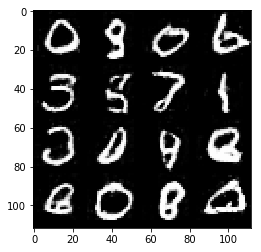

Epoch 7/10... Discriminator Loss: 1.2717... Generator Loss: 0.5866
Epoch 7/10... Discriminator Loss: 0.3412... Generator Loss: 2.3265
Epoch 7/10... Discriminator Loss: 0.3050... Generator Loss: 1.7846
Epoch 7/10... Discriminator Loss: 0.4425... Generator Loss: 1.5180
Epoch 7/10... Discriminator Loss: 0.4800... Generator Loss: 1.4825
Epoch 7/10... Discriminator Loss: 0.2886... Generator Loss: 2.0431
Epoch 7/10... Discriminator Loss: 0.4554... Generator Loss: 1.4078
Epoch 7/10... Discriminator Loss: 0.2812... Generator Loss: 2.8581
Epoch 7/10... Discriminator Loss: 0.3431... Generator Loss: 2.1668
Epoch 7/10... Discriminator Loss: 0.3981... Generator Loss: 1.5538


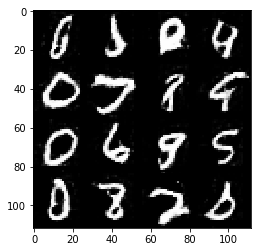

Epoch 7/10... Discriminator Loss: 0.2502... Generator Loss: 2.4722
Epoch 7/10... Discriminator Loss: 0.6544... Generator Loss: 1.2103
Epoch 7/10... Discriminator Loss: 0.4253... Generator Loss: 1.5226
Epoch 7/10... Discriminator Loss: 1.0981... Generator Loss: 0.6795
Epoch 7/10... Discriminator Loss: 0.3224... Generator Loss: 2.1478
Epoch 7/10... Discriminator Loss: 0.7291... Generator Loss: 1.0638
Epoch 7/10... Discriminator Loss: 0.2245... Generator Loss: 2.1815
Epoch 7/10... Discriminator Loss: 0.4183... Generator Loss: 1.7774
Epoch 7/10... Discriminator Loss: 0.3867... Generator Loss: 2.4428
Epoch 7/10... Discriminator Loss: 0.3116... Generator Loss: 2.0109


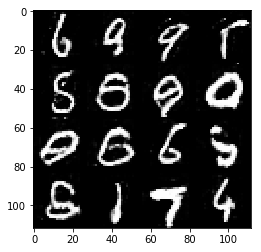

Epoch 7/10... Discriminator Loss: 0.4269... Generator Loss: 1.4180
Epoch 7/10... Discriminator Loss: 0.3721... Generator Loss: 1.9112
Epoch 7/10... Discriminator Loss: 0.4387... Generator Loss: 1.5859
Epoch 7/10... Discriminator Loss: 0.2525... Generator Loss: 2.4438
Epoch 7/10... Discriminator Loss: 0.3856... Generator Loss: 1.7608
Epoch 7/10... Discriminator Loss: 0.3386... Generator Loss: 2.0623
Epoch 7/10... Discriminator Loss: 0.7670... Generator Loss: 0.9165
Epoch 7/10... Discriminator Loss: 0.4117... Generator Loss: 1.5583
Epoch 7/10... Discriminator Loss: 0.2929... Generator Loss: 2.2409
Epoch 7/10... Discriminator Loss: 0.3719... Generator Loss: 1.8454


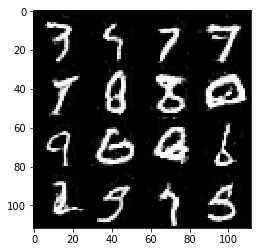

Epoch 7/10... Discriminator Loss: 0.2367... Generator Loss: 2.2827
Epoch 7/10... Discriminator Loss: 0.9309... Generator Loss: 0.7173
Epoch 7/10... Discriminator Loss: 0.1625... Generator Loss: 3.1861
Epoch 7/10... Discriminator Loss: 0.3526... Generator Loss: 2.2409
Epoch 7/10... Discriminator Loss: 0.5619... Generator Loss: 1.3972
Epoch 7/10... Discriminator Loss: 0.2586... Generator Loss: 2.4682
Epoch 7/10... Discriminator Loss: 0.4888... Generator Loss: 3.3702
Epoch 7/10... Discriminator Loss: 3.2486... Generator Loss: 7.2945
Epoch 7/10... Discriminator Loss: 1.1316... Generator Loss: 0.8789
Epoch 7/10... Discriminator Loss: 0.3475... Generator Loss: 2.6170


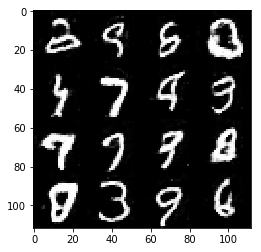

Epoch 7/10... Discriminator Loss: 0.4133... Generator Loss: 1.9190
Epoch 7/10... Discriminator Loss: 0.9393... Generator Loss: 0.7982
Epoch 7/10... Discriminator Loss: 0.4315... Generator Loss: 1.4868
Epoch 7/10... Discriminator Loss: 0.3796... Generator Loss: 2.2237
Epoch 7/10... Discriminator Loss: 0.2286... Generator Loss: 2.4625
Epoch 7/10... Discriminator Loss: 0.4847... Generator Loss: 1.5539
Epoch 7/10... Discriminator Loss: 0.2713... Generator Loss: 2.0874
Epoch 7/10... Discriminator Loss: 0.3877... Generator Loss: 2.1257
Epoch 7/10... Discriminator Loss: 0.3121... Generator Loss: 2.2067
Epoch 7/10... Discriminator Loss: 0.4375... Generator Loss: 1.7775


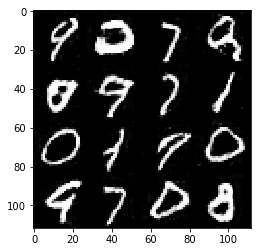

Epoch 7/10... Discriminator Loss: 0.4091... Generator Loss: 1.9723
Epoch 7/10... Discriminator Loss: 0.2864... Generator Loss: 2.2552
Epoch 8/10... Discriminator Loss: 0.3670... Generator Loss: 1.5715
Epoch 8/10... Discriminator Loss: 0.3660... Generator Loss: 1.8886
Epoch 8/10... Discriminator Loss: 0.2870... Generator Loss: 2.2061
Epoch 8/10... Discriminator Loss: 0.4760... Generator Loss: 2.0465
Epoch 8/10... Discriminator Loss: 0.3193... Generator Loss: 2.7080
Epoch 8/10... Discriminator Loss: 0.3576... Generator Loss: 1.8663
Epoch 8/10... Discriminator Loss: 0.4120... Generator Loss: 1.9053
Epoch 8/10... Discriminator Loss: 0.1764... Generator Loss: 3.0919


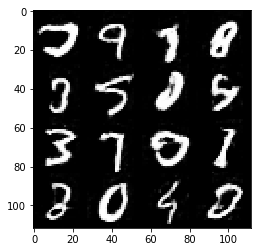

Epoch 8/10... Discriminator Loss: 0.4007... Generator Loss: 1.5074
Epoch 8/10... Discriminator Loss: 0.3846... Generator Loss: 1.8688
Epoch 8/10... Discriminator Loss: 0.3609... Generator Loss: 1.8692
Epoch 8/10... Discriminator Loss: 0.3008... Generator Loss: 1.9231
Epoch 8/10... Discriminator Loss: 0.5358... Generator Loss: 1.5440
Epoch 8/10... Discriminator Loss: 0.4325... Generator Loss: 1.5852
Epoch 8/10... Discriminator Loss: 1.9690... Generator Loss: 0.9296
Epoch 8/10... Discriminator Loss: 0.9895... Generator Loss: 0.8392
Epoch 8/10... Discriminator Loss: 0.3826... Generator Loss: 2.1337
Epoch 8/10... Discriminator Loss: 0.5354... Generator Loss: 2.3505


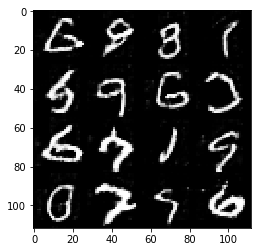

Epoch 8/10... Discriminator Loss: 0.3581... Generator Loss: 1.9564
Epoch 8/10... Discriminator Loss: 0.3469... Generator Loss: 2.1933
Epoch 8/10... Discriminator Loss: 0.4510... Generator Loss: 1.5533
Epoch 8/10... Discriminator Loss: 0.3353... Generator Loss: 1.9112
Epoch 8/10... Discriminator Loss: 0.2556... Generator Loss: 2.5247
Epoch 8/10... Discriminator Loss: 0.5244... Generator Loss: 1.2196
Epoch 8/10... Discriminator Loss: 0.3203... Generator Loss: 1.9526
Epoch 8/10... Discriminator Loss: 0.4048... Generator Loss: 2.1910
Epoch 8/10... Discriminator Loss: 0.3132... Generator Loss: 2.0601
Epoch 8/10... Discriminator Loss: 0.5618... Generator Loss: 1.2550


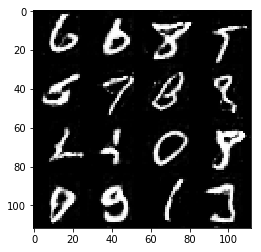

Epoch 8/10... Discriminator Loss: 0.2559... Generator Loss: 2.3326
Epoch 8/10... Discriminator Loss: 0.2820... Generator Loss: 3.1188
Epoch 8/10... Discriminator Loss: 0.3792... Generator Loss: 1.7192
Epoch 8/10... Discriminator Loss: 0.2702... Generator Loss: 2.0379
Epoch 8/10... Discriminator Loss: 0.3653... Generator Loss: 1.6898
Epoch 8/10... Discriminator Loss: 0.4016... Generator Loss: 2.4048
Epoch 8/10... Discriminator Loss: 0.2403... Generator Loss: 2.2455
Epoch 8/10... Discriminator Loss: 0.4633... Generator Loss: 1.5708
Epoch 8/10... Discriminator Loss: 0.4408... Generator Loss: 1.5241
Epoch 8/10... Discriminator Loss: 0.4343... Generator Loss: 1.6837


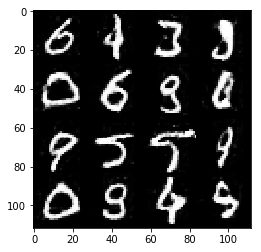

Epoch 8/10... Discriminator Loss: 0.2219... Generator Loss: 2.6515
Epoch 8/10... Discriminator Loss: 0.4327... Generator Loss: 1.9572
Epoch 8/10... Discriminator Loss: 0.3587... Generator Loss: 1.6548
Epoch 8/10... Discriminator Loss: 0.2710... Generator Loss: 2.2121
Epoch 8/10... Discriminator Loss: 0.3594... Generator Loss: 1.8634
Epoch 8/10... Discriminator Loss: 0.3039... Generator Loss: 2.0359
Epoch 8/10... Discriminator Loss: 0.2936... Generator Loss: 2.3518
Epoch 8/10... Discriminator Loss: 0.4364... Generator Loss: 1.4355
Epoch 8/10... Discriminator Loss: 0.3977... Generator Loss: 1.6599
Epoch 8/10... Discriminator Loss: 0.1428... Generator Loss: 3.1945


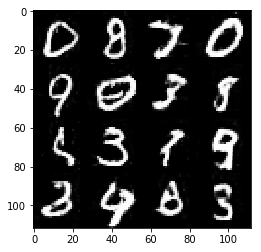

Epoch 8/10... Discriminator Loss: 0.3521... Generator Loss: 1.7570
Epoch 8/10... Discriminator Loss: 0.4409... Generator Loss: 1.6533
Epoch 8/10... Discriminator Loss: 0.2824... Generator Loss: 2.2103
Epoch 8/10... Discriminator Loss: 0.5051... Generator Loss: 1.5527
Epoch 8/10... Discriminator Loss: 0.3470... Generator Loss: 1.9557
Epoch 8/10... Discriminator Loss: 0.4626... Generator Loss: 1.8300
Epoch 8/10... Discriminator Loss: 0.3279... Generator Loss: 1.8656
Epoch 8/10... Discriminator Loss: 0.2900... Generator Loss: 2.4105
Epoch 8/10... Discriminator Loss: 0.2379... Generator Loss: 2.6475
Epoch 8/10... Discriminator Loss: 0.3726... Generator Loss: 2.6036


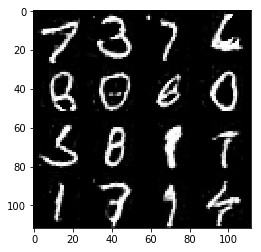

Epoch 8/10... Discriminator Loss: 0.3833... Generator Loss: 1.6796
Epoch 8/10... Discriminator Loss: 0.9018... Generator Loss: 0.8375
Epoch 8/10... Discriminator Loss: 0.5541... Generator Loss: 1.3122
Epoch 8/10... Discriminator Loss: 0.3187... Generator Loss: 1.7477
Epoch 8/10... Discriminator Loss: 0.3786... Generator Loss: 1.7866
Epoch 8/10... Discriminator Loss: 0.3458... Generator Loss: 2.0251
Epoch 8/10... Discriminator Loss: 0.2042... Generator Loss: 2.7375
Epoch 8/10... Discriminator Loss: 0.2781... Generator Loss: 1.9284
Epoch 8/10... Discriminator Loss: 0.6979... Generator Loss: 1.0027
Epoch 8/10... Discriminator Loss: 0.5183... Generator Loss: 1.2317


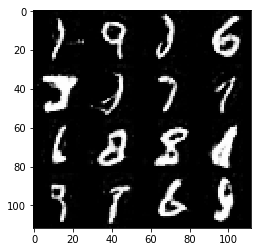

Epoch 8/10... Discriminator Loss: 0.4654... Generator Loss: 1.4941
Epoch 8/10... Discriminator Loss: 0.3089... Generator Loss: 2.1788
Epoch 8/10... Discriminator Loss: 0.2737... Generator Loss: 2.2437
Epoch 8/10... Discriminator Loss: 0.4313... Generator Loss: 1.6182
Epoch 8/10... Discriminator Loss: 0.4938... Generator Loss: 1.6129
Epoch 8/10... Discriminator Loss: 0.3733... Generator Loss: 2.1191
Epoch 8/10... Discriminator Loss: 0.1954... Generator Loss: 2.6305
Epoch 8/10... Discriminator Loss: 0.2383... Generator Loss: 2.2292
Epoch 8/10... Discriminator Loss: 0.8619... Generator Loss: 0.9679
Epoch 8/10... Discriminator Loss: 0.4385... Generator Loss: 1.4780


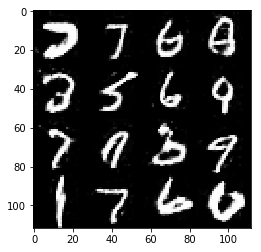

Epoch 8/10... Discriminator Loss: 0.4052... Generator Loss: 1.5671
Epoch 8/10... Discriminator Loss: 0.4762... Generator Loss: 1.8932
Epoch 8/10... Discriminator Loss: 5.5973... Generator Loss: 0.0153
Epoch 8/10... Discriminator Loss: 0.2977... Generator Loss: 3.3955
Epoch 8/10... Discriminator Loss: 0.7137... Generator Loss: 1.0626
Epoch 8/10... Discriminator Loss: 0.2406... Generator Loss: 2.9663
Epoch 8/10... Discriminator Loss: 0.3668... Generator Loss: 1.9825
Epoch 8/10... Discriminator Loss: 0.3088... Generator Loss: 2.1161
Epoch 8/10... Discriminator Loss: 0.4222... Generator Loss: 2.0362
Epoch 8/10... Discriminator Loss: 0.4262... Generator Loss: 1.5225


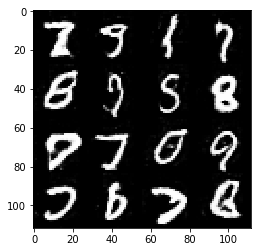

Epoch 8/10... Discriminator Loss: 0.3370... Generator Loss: 2.0124
Epoch 8/10... Discriminator Loss: 0.3325... Generator Loss: 2.0391
Epoch 8/10... Discriminator Loss: 0.3219... Generator Loss: 2.6721
Epoch 8/10... Discriminator Loss: 0.6586... Generator Loss: 1.2603
Epoch 8/10... Discriminator Loss: 0.3164... Generator Loss: 1.9114
Epoch 8/10... Discriminator Loss: 0.4179... Generator Loss: 1.8102
Epoch 8/10... Discriminator Loss: 0.4149... Generator Loss: 1.9637
Epoch 8/10... Discriminator Loss: 0.3538... Generator Loss: 2.0960
Epoch 8/10... Discriminator Loss: 0.6685... Generator Loss: 1.1513
Epoch 8/10... Discriminator Loss: 0.4234... Generator Loss: 2.2664


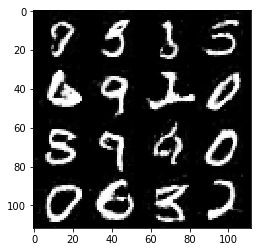

Epoch 8/10... Discriminator Loss: 0.4971... Generator Loss: 1.4832
Epoch 8/10... Discriminator Loss: 0.3314... Generator Loss: 1.8619
Epoch 8/10... Discriminator Loss: 0.3235... Generator Loss: 2.2966
Epoch 8/10... Discriminator Loss: 0.3916... Generator Loss: 1.6425
Epoch 8/10... Discriminator Loss: 0.4613... Generator Loss: 1.7036
Epoch 8/10... Discriminator Loss: 0.3241... Generator Loss: 1.8855
Epoch 8/10... Discriminator Loss: 0.7980... Generator Loss: 0.9806
Epoch 8/10... Discriminator Loss: 0.2470... Generator Loss: 2.4573
Epoch 8/10... Discriminator Loss: 0.3492... Generator Loss: 1.7276
Epoch 8/10... Discriminator Loss: 0.3355... Generator Loss: 1.7285


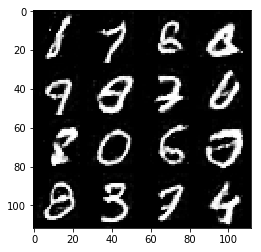

Epoch 8/10... Discriminator Loss: 0.2707... Generator Loss: 2.1332
Epoch 8/10... Discriminator Loss: 0.3491... Generator Loss: 2.1618
Epoch 8/10... Discriminator Loss: 0.4301... Generator Loss: 1.7599
Epoch 8/10... Discriminator Loss: 0.4098... Generator Loss: 1.6225
Epoch 8/10... Discriminator Loss: 0.3894... Generator Loss: 2.0754
Epoch 8/10... Discriminator Loss: 0.4174... Generator Loss: 2.1806
Epoch 8/10... Discriminator Loss: 0.3962... Generator Loss: 1.6091
Epoch 8/10... Discriminator Loss: 0.5260... Generator Loss: 1.3327
Epoch 8/10... Discriminator Loss: 0.4165... Generator Loss: 1.6934
Epoch 8/10... Discriminator Loss: 0.3220... Generator Loss: 1.9847


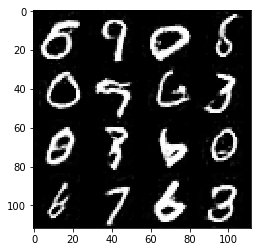

Epoch 8/10... Discriminator Loss: 0.2315... Generator Loss: 2.8547
Epoch 8/10... Discriminator Loss: 0.1986... Generator Loss: 2.7258
Epoch 8/10... Discriminator Loss: 0.3266... Generator Loss: 1.7960
Epoch 8/10... Discriminator Loss: 0.9368... Generator Loss: 0.8179
Epoch 8/10... Discriminator Loss: 0.4462... Generator Loss: 1.8663
Epoch 8/10... Discriminator Loss: 0.2815... Generator Loss: 2.3911
Epoch 8/10... Discriminator Loss: 0.4205... Generator Loss: 1.4315
Epoch 8/10... Discriminator Loss: 0.3949... Generator Loss: 2.1764
Epoch 8/10... Discriminator Loss: 0.3993... Generator Loss: 1.8824
Epoch 8/10... Discriminator Loss: 0.2950... Generator Loss: 1.8718


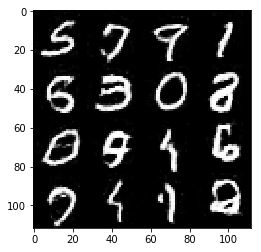

Epoch 8/10... Discriminator Loss: 0.4458... Generator Loss: 1.6385
Epoch 8/10... Discriminator Loss: 0.3676... Generator Loss: 2.3006
Epoch 8/10... Discriminator Loss: 0.5114... Generator Loss: 1.3255
Epoch 8/10... Discriminator Loss: 0.5649... Generator Loss: 1.1942
Epoch 8/10... Discriminator Loss: 0.3933... Generator Loss: 1.9510
Epoch 8/10... Discriminator Loss: 0.3555... Generator Loss: 1.8936
Epoch 8/10... Discriminator Loss: 0.4502... Generator Loss: 1.8229
Epoch 8/10... Discriminator Loss: 0.5580... Generator Loss: 1.3208
Epoch 8/10... Discriminator Loss: 0.3959... Generator Loss: 2.1683
Epoch 8/10... Discriminator Loss: 0.3147... Generator Loss: 2.3633


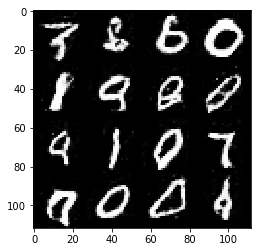

Epoch 8/10... Discriminator Loss: 0.1762... Generator Loss: 3.0830
Epoch 8/10... Discriminator Loss: 0.3296... Generator Loss: 1.7287
Epoch 8/10... Discriminator Loss: 0.1999... Generator Loss: 3.0557
Epoch 8/10... Discriminator Loss: 0.5407... Generator Loss: 1.4313
Epoch 8/10... Discriminator Loss: 0.4527... Generator Loss: 1.8647
Epoch 8/10... Discriminator Loss: 0.4207... Generator Loss: 1.5891
Epoch 8/10... Discriminator Loss: 0.3495... Generator Loss: 2.2918
Epoch 8/10... Discriminator Loss: 0.3614... Generator Loss: 2.2879
Epoch 8/10... Discriminator Loss: 0.2695... Generator Loss: 2.2102
Epoch 8/10... Discriminator Loss: 0.6040... Generator Loss: 1.3663


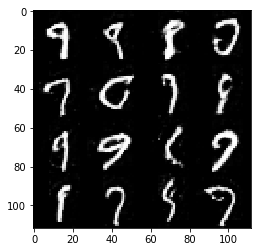

Epoch 8/10... Discriminator Loss: 0.2963... Generator Loss: 2.2448
Epoch 8/10... Discriminator Loss: 0.3815... Generator Loss: 2.2191
Epoch 8/10... Discriminator Loss: 0.4571... Generator Loss: 1.5506
Epoch 8/10... Discriminator Loss: 0.2133... Generator Loss: 2.5959
Epoch 8/10... Discriminator Loss: 0.4391... Generator Loss: 1.6784
Epoch 8/10... Discriminator Loss: 0.4980... Generator Loss: 1.4715
Epoch 8/10... Discriminator Loss: 0.5161... Generator Loss: 1.6259
Epoch 8/10... Discriminator Loss: 0.5524... Generator Loss: 3.1755
Epoch 8/10... Discriminator Loss: 0.3882... Generator Loss: 1.5376
Epoch 8/10... Discriminator Loss: 0.9850... Generator Loss: 0.8345


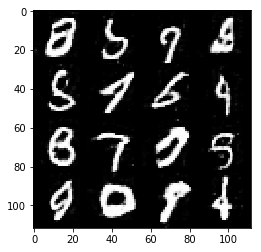

Epoch 8/10... Discriminator Loss: 2.1307... Generator Loss: 3.2513
Epoch 8/10... Discriminator Loss: 0.9218... Generator Loss: 3.1991
Epoch 8/10... Discriminator Loss: 0.7041... Generator Loss: 1.6250
Epoch 8/10... Discriminator Loss: 1.1525... Generator Loss: 3.1452
Epoch 8/10... Discriminator Loss: 0.3790... Generator Loss: 2.0779
Epoch 8/10... Discriminator Loss: 0.4740... Generator Loss: 2.0789
Epoch 8/10... Discriminator Loss: 0.4126... Generator Loss: 2.6430
Epoch 8/10... Discriminator Loss: 0.5272... Generator Loss: 1.8908
Epoch 8/10... Discriminator Loss: 0.2720... Generator Loss: 2.7235
Epoch 8/10... Discriminator Loss: 0.3211... Generator Loss: 2.5966


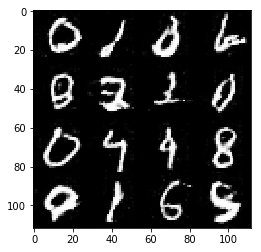

Epoch 8/10... Discriminator Loss: 0.4964... Generator Loss: 1.5653
Epoch 8/10... Discriminator Loss: 0.3327... Generator Loss: 2.2357
Epoch 8/10... Discriminator Loss: 0.4960... Generator Loss: 1.5700
Epoch 8/10... Discriminator Loss: 0.7478... Generator Loss: 1.0554
Epoch 8/10... Discriminator Loss: 0.4937... Generator Loss: 1.6895
Epoch 8/10... Discriminator Loss: 0.0621... Generator Loss: 4.2482
Epoch 8/10... Discriminator Loss: 0.4883... Generator Loss: 1.6722
Epoch 8/10... Discriminator Loss: 0.3496... Generator Loss: 2.1382
Epoch 8/10... Discriminator Loss: 0.7017... Generator Loss: 1.0771
Epoch 8/10... Discriminator Loss: 0.4920... Generator Loss: 1.6439


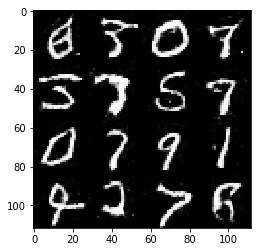

Epoch 8/10... Discriminator Loss: 0.4087... Generator Loss: 1.8831
Epoch 8/10... Discriminator Loss: 0.6281... Generator Loss: 1.1141
Epoch 8/10... Discriminator Loss: 0.6071... Generator Loss: 1.3032
Epoch 8/10... Discriminator Loss: 0.3846... Generator Loss: 1.7893
Epoch 8/10... Discriminator Loss: 0.5252... Generator Loss: 1.5087
Epoch 8/10... Discriminator Loss: 0.3310... Generator Loss: 2.3692
Epoch 8/10... Discriminator Loss: 0.2613... Generator Loss: 2.8032
Epoch 8/10... Discriminator Loss: 0.5059... Generator Loss: 1.9819
Epoch 8/10... Discriminator Loss: 0.5345... Generator Loss: 1.8399
Epoch 8/10... Discriminator Loss: 0.3411... Generator Loss: 1.9841


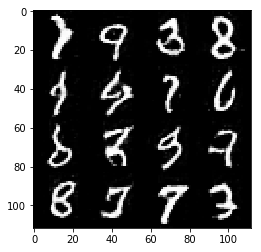

Epoch 9/10... Discriminator Loss: 0.3328... Generator Loss: 2.5420
Epoch 9/10... Discriminator Loss: 0.4345... Generator Loss: 2.1597
Epoch 9/10... Discriminator Loss: 0.2836... Generator Loss: 1.9593
Epoch 9/10... Discriminator Loss: 0.3319... Generator Loss: 2.0391
Epoch 9/10... Discriminator Loss: 0.3487... Generator Loss: 1.8962
Epoch 9/10... Discriminator Loss: 0.5820... Generator Loss: 1.3036
Epoch 9/10... Discriminator Loss: 0.5771... Generator Loss: 1.2058
Epoch 9/10... Discriminator Loss: 0.3605... Generator Loss: 1.8245
Epoch 9/10... Discriminator Loss: 0.2458... Generator Loss: 2.5722
Epoch 9/10... Discriminator Loss: 0.2230... Generator Loss: 2.3139


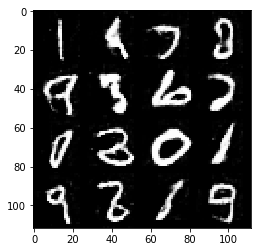

Epoch 9/10... Discriminator Loss: 0.6266... Generator Loss: 1.2082
Epoch 9/10... Discriminator Loss: 0.3021... Generator Loss: 2.2312
Epoch 9/10... Discriminator Loss: 0.8361... Generator Loss: 0.9763
Epoch 9/10... Discriminator Loss: 0.3572... Generator Loss: 1.9566
Epoch 9/10... Discriminator Loss: 0.3759... Generator Loss: 1.8703
Epoch 9/10... Discriminator Loss: 0.2967... Generator Loss: 1.7524
Epoch 9/10... Discriminator Loss: 0.7994... Generator Loss: 0.8587
Epoch 9/10... Discriminator Loss: 0.4312... Generator Loss: 2.0161
Epoch 9/10... Discriminator Loss: 0.3493... Generator Loss: 1.9040
Epoch 9/10... Discriminator Loss: 0.5294... Generator Loss: 1.4383


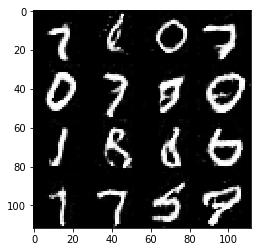

Epoch 9/10... Discriminator Loss: 0.9112... Generator Loss: 0.9873
Epoch 9/10... Discriminator Loss: 0.4020... Generator Loss: 1.7254
Epoch 9/10... Discriminator Loss: 0.1841... Generator Loss: 2.7343
Epoch 9/10... Discriminator Loss: 0.2715... Generator Loss: 2.5974
Epoch 9/10... Discriminator Loss: 0.4057... Generator Loss: 2.0565
Epoch 9/10... Discriminator Loss: 0.2872... Generator Loss: 2.0898
Epoch 9/10... Discriminator Loss: 0.3835... Generator Loss: 1.5709
Epoch 9/10... Discriminator Loss: 0.3615... Generator Loss: 2.2755
Epoch 9/10... Discriminator Loss: 0.7430... Generator Loss: 1.0173
Epoch 9/10... Discriminator Loss: 0.6811... Generator Loss: 1.2716


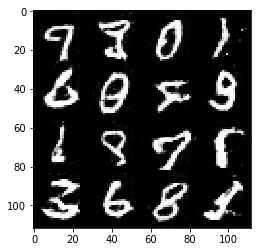

Epoch 9/10... Discriminator Loss: 0.3158... Generator Loss: 1.9450
Epoch 9/10... Discriminator Loss: 0.5889... Generator Loss: 1.2077
Epoch 9/10... Discriminator Loss: 0.5707... Generator Loss: 1.1608
Epoch 9/10... Discriminator Loss: 0.4496... Generator Loss: 2.1506
Epoch 9/10... Discriminator Loss: 0.2569... Generator Loss: 2.8007
Epoch 9/10... Discriminator Loss: 0.4972... Generator Loss: 1.3475
Epoch 9/10... Discriminator Loss: 0.4329... Generator Loss: 1.5368
Epoch 9/10... Discriminator Loss: 0.5772... Generator Loss: 1.5586
Epoch 9/10... Discriminator Loss: 0.3346... Generator Loss: 1.7659
Epoch 9/10... Discriminator Loss: 0.3763... Generator Loss: 1.9376


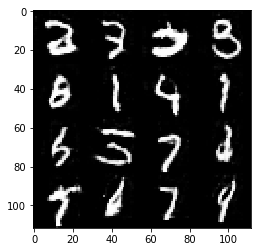

Epoch 9/10... Discriminator Loss: 0.7249... Generator Loss: 1.0300
Epoch 9/10... Discriminator Loss: 0.2742... Generator Loss: 2.2159
Epoch 9/10... Discriminator Loss: 0.2822... Generator Loss: 2.3408
Epoch 9/10... Discriminator Loss: 1.2433... Generator Loss: 0.6313
Epoch 9/10... Discriminator Loss: 0.4810... Generator Loss: 1.8916
Epoch 9/10... Discriminator Loss: 0.4315... Generator Loss: 1.8611
Epoch 9/10... Discriminator Loss: 0.3961... Generator Loss: 1.8126
Epoch 9/10... Discriminator Loss: 0.5355... Generator Loss: 1.2475
Epoch 9/10... Discriminator Loss: 0.5230... Generator Loss: 1.6166
Epoch 9/10... Discriminator Loss: 0.4238... Generator Loss: 1.8086


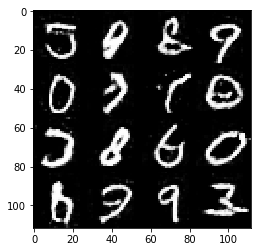

Epoch 9/10... Discriminator Loss: 0.6083... Generator Loss: 1.1665
Epoch 9/10... Discriminator Loss: 0.2650... Generator Loss: 2.3537
Epoch 9/10... Discriminator Loss: 0.4042... Generator Loss: 1.9634
Epoch 9/10... Discriminator Loss: 0.6645... Generator Loss: 0.9804
Epoch 9/10... Discriminator Loss: 0.4308... Generator Loss: 1.4255
Epoch 9/10... Discriminator Loss: 0.5302... Generator Loss: 1.2874
Epoch 9/10... Discriminator Loss: 0.4953... Generator Loss: 1.7094
Epoch 9/10... Discriminator Loss: 0.4509... Generator Loss: 1.5567
Epoch 9/10... Discriminator Loss: 0.2630... Generator Loss: 2.3884
Epoch 9/10... Discriminator Loss: 0.6150... Generator Loss: 1.2780


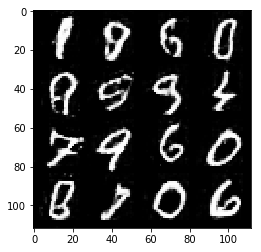

Epoch 9/10... Discriminator Loss: 0.4752... Generator Loss: 1.3451
Epoch 9/10... Discriminator Loss: 0.5375... Generator Loss: 1.2219
Epoch 9/10... Discriminator Loss: 0.3292... Generator Loss: 2.4600
Epoch 9/10... Discriminator Loss: 0.3345... Generator Loss: 2.1776
Epoch 9/10... Discriminator Loss: 0.2311... Generator Loss: 2.9827
Epoch 9/10... Discriminator Loss: 0.3651... Generator Loss: 2.6441
Epoch 9/10... Discriminator Loss: 0.5033... Generator Loss: 1.6731
Epoch 9/10... Discriminator Loss: 0.4861... Generator Loss: 1.4412
Epoch 9/10... Discriminator Loss: 0.3085... Generator Loss: 1.8518
Epoch 9/10... Discriminator Loss: 0.4570... Generator Loss: 2.2141


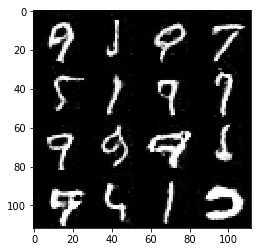

Epoch 9/10... Discriminator Loss: 0.4994... Generator Loss: 1.4270
Epoch 9/10... Discriminator Loss: 0.3188... Generator Loss: 2.2234
Epoch 9/10... Discriminator Loss: 0.3643... Generator Loss: 2.0121
Epoch 9/10... Discriminator Loss: 0.3684... Generator Loss: 1.9992
Epoch 9/10... Discriminator Loss: 0.3928... Generator Loss: 1.6128
Epoch 9/10... Discriminator Loss: 0.2729... Generator Loss: 2.6901
Epoch 9/10... Discriminator Loss: 0.3644... Generator Loss: 2.1944
Epoch 9/10... Discriminator Loss: 0.2731... Generator Loss: 3.0047
Epoch 9/10... Discriminator Loss: 0.4072... Generator Loss: 1.8673
Epoch 9/10... Discriminator Loss: 0.6097... Generator Loss: 1.2521


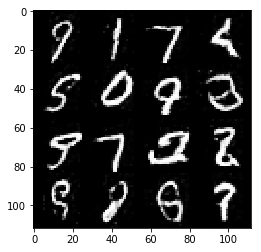

Epoch 9/10... Discriminator Loss: 0.1742... Generator Loss: 3.8062
Epoch 9/10... Discriminator Loss: 0.4461... Generator Loss: 1.7867
Epoch 9/10... Discriminator Loss: 0.4775... Generator Loss: 2.8015
Epoch 9/10... Discriminator Loss: 0.3240... Generator Loss: 1.8223
Epoch 9/10... Discriminator Loss: 0.3656... Generator Loss: 1.7832
Epoch 9/10... Discriminator Loss: 0.3853... Generator Loss: 1.8939
Epoch 9/10... Discriminator Loss: 0.5988... Generator Loss: 1.1478
Epoch 9/10... Discriminator Loss: 0.8722... Generator Loss: 1.0311
Epoch 9/10... Discriminator Loss: 0.2815... Generator Loss: 2.2626
Epoch 9/10... Discriminator Loss: 0.1861... Generator Loss: 2.5527


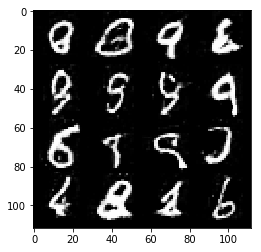

Epoch 9/10... Discriminator Loss: 0.5399... Generator Loss: 1.5163
Epoch 9/10... Discriminator Loss: 0.3083... Generator Loss: 2.4691
Epoch 9/10... Discriminator Loss: 0.4415... Generator Loss: 1.5416
Epoch 9/10... Discriminator Loss: 0.4302... Generator Loss: 1.7353
Epoch 9/10... Discriminator Loss: 0.4151... Generator Loss: 1.5713
Epoch 9/10... Discriminator Loss: 0.3362... Generator Loss: 2.0609
Epoch 9/10... Discriminator Loss: 0.5265... Generator Loss: 1.5684
Epoch 9/10... Discriminator Loss: 0.3622... Generator Loss: 1.9102
Epoch 9/10... Discriminator Loss: 0.5208... Generator Loss: 1.4772
Epoch 9/10... Discriminator Loss: 0.3725... Generator Loss: 1.8418


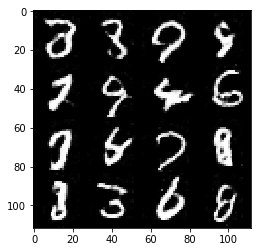

Epoch 9/10... Discriminator Loss: 0.4770... Generator Loss: 1.4953
Epoch 9/10... Discriminator Loss: 0.5691... Generator Loss: 1.4356
Epoch 9/10... Discriminator Loss: 0.3638... Generator Loss: 1.7847
Epoch 9/10... Discriminator Loss: 0.3853... Generator Loss: 1.9093
Epoch 9/10... Discriminator Loss: 0.2402... Generator Loss: 2.9707
Epoch 9/10... Discriminator Loss: 0.4149... Generator Loss: 1.6834
Epoch 9/10... Discriminator Loss: 0.2908... Generator Loss: 2.0423
Epoch 9/10... Discriminator Loss: 0.3623... Generator Loss: 2.0590
Epoch 9/10... Discriminator Loss: 0.3629... Generator Loss: 1.7958
Epoch 9/10... Discriminator Loss: 0.2960... Generator Loss: 2.6189


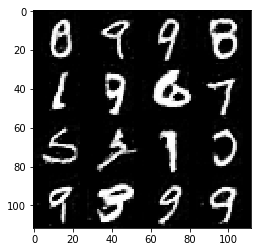

Epoch 9/10... Discriminator Loss: 0.9953... Generator Loss: 1.6673
Epoch 9/10... Discriminator Loss: 1.9308... Generator Loss: 4.2624
Epoch 9/10... Discriminator Loss: 0.5061... Generator Loss: 3.7602
Epoch 9/10... Discriminator Loss: 1.0568... Generator Loss: 1.0008
Epoch 9/10... Discriminator Loss: 0.3505... Generator Loss: 2.5382
Epoch 9/10... Discriminator Loss: 0.4293... Generator Loss: 1.7904
Epoch 9/10... Discriminator Loss: 0.4702... Generator Loss: 1.7472
Epoch 9/10... Discriminator Loss: 0.4957... Generator Loss: 1.6184
Epoch 9/10... Discriminator Loss: 0.4872... Generator Loss: 2.7252
Epoch 9/10... Discriminator Loss: 0.4053... Generator Loss: 1.7090


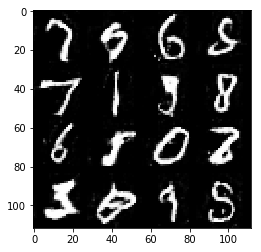

Epoch 9/10... Discriminator Loss: 0.5282... Generator Loss: 1.6307
Epoch 9/10... Discriminator Loss: 0.4953... Generator Loss: 1.5750
Epoch 9/10... Discriminator Loss: 0.4828... Generator Loss: 1.8115
Epoch 9/10... Discriminator Loss: 0.4585... Generator Loss: 1.8318
Epoch 9/10... Discriminator Loss: 0.2865... Generator Loss: 2.2159
Epoch 9/10... Discriminator Loss: 0.3007... Generator Loss: 2.4974
Epoch 9/10... Discriminator Loss: 0.3959... Generator Loss: 2.2651
Epoch 9/10... Discriminator Loss: 0.3280... Generator Loss: 2.4259
Epoch 9/10... Discriminator Loss: 0.8726... Generator Loss: 3.6817
Epoch 9/10... Discriminator Loss: 0.7876... Generator Loss: 1.0469


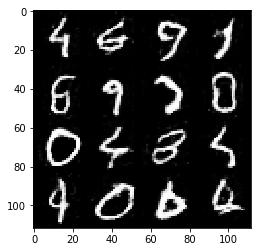

Epoch 9/10... Discriminator Loss: 0.3015... Generator Loss: 1.8347
Epoch 9/10... Discriminator Loss: 0.4643... Generator Loss: 1.7787
Epoch 9/10... Discriminator Loss: 0.5447... Generator Loss: 1.1930
Epoch 9/10... Discriminator Loss: 0.3539... Generator Loss: 2.5513
Epoch 9/10... Discriminator Loss: 0.4238... Generator Loss: 2.4571
Epoch 9/10... Discriminator Loss: 0.7895... Generator Loss: 1.5309
Epoch 9/10... Discriminator Loss: 0.3034... Generator Loss: 2.1351
Epoch 9/10... Discriminator Loss: 0.3118... Generator Loss: 2.4907
Epoch 9/10... Discriminator Loss: 0.3332... Generator Loss: 2.5084
Epoch 9/10... Discriminator Loss: 0.5386... Generator Loss: 1.3803


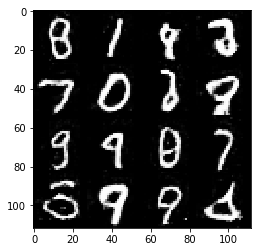

Epoch 9/10... Discriminator Loss: 0.3421... Generator Loss: 2.1102
Epoch 9/10... Discriminator Loss: 0.7663... Generator Loss: 0.9045
Epoch 9/10... Discriminator Loss: 0.4302... Generator Loss: 1.7118
Epoch 9/10... Discriminator Loss: 0.6019... Generator Loss: 1.2393
Epoch 9/10... Discriminator Loss: 0.4463... Generator Loss: 1.6382
Epoch 9/10... Discriminator Loss: 0.3898... Generator Loss: 1.8027
Epoch 9/10... Discriminator Loss: 1.1023... Generator Loss: 0.7179
Epoch 9/10... Discriminator Loss: 0.4613... Generator Loss: 1.4924
Epoch 9/10... Discriminator Loss: 1.1999... Generator Loss: 0.6380
Epoch 9/10... Discriminator Loss: 0.4145... Generator Loss: 1.7444


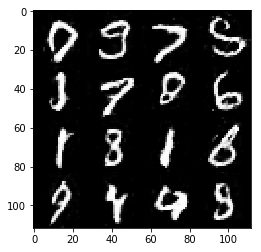

Epoch 9/10... Discriminator Loss: 0.5929... Generator Loss: 1.2065
Epoch 9/10... Discriminator Loss: 0.2852... Generator Loss: 2.1864
Epoch 9/10... Discriminator Loss: 0.4062... Generator Loss: 1.8759
Epoch 9/10... Discriminator Loss: 0.6612... Generator Loss: 1.1178
Epoch 9/10... Discriminator Loss: 0.4297... Generator Loss: 1.6484
Epoch 9/10... Discriminator Loss: 0.5415... Generator Loss: 2.2615
Epoch 9/10... Discriminator Loss: 0.3764... Generator Loss: 2.2449
Epoch 9/10... Discriminator Loss: 0.5460... Generator Loss: 1.4480
Epoch 9/10... Discriminator Loss: 0.4155... Generator Loss: 1.7973
Epoch 9/10... Discriminator Loss: 0.4307... Generator Loss: 1.9086


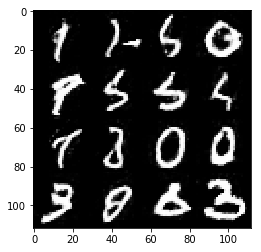

Epoch 9/10... Discriminator Loss: 0.4806... Generator Loss: 1.4842
Epoch 9/10... Discriminator Loss: 1.1010... Generator Loss: 0.6605
Epoch 9/10... Discriminator Loss: 0.4271... Generator Loss: 1.4853
Epoch 9/10... Discriminator Loss: 0.4530... Generator Loss: 1.5931
Epoch 9/10... Discriminator Loss: 0.3349... Generator Loss: 2.2519
Epoch 9/10... Discriminator Loss: 0.2844... Generator Loss: 2.4234
Epoch 9/10... Discriminator Loss: 0.9944... Generator Loss: 0.7008
Epoch 9/10... Discriminator Loss: 0.2600... Generator Loss: 2.2976
Epoch 9/10... Discriminator Loss: 0.5335... Generator Loss: 1.8560
Epoch 9/10... Discriminator Loss: 0.3907... Generator Loss: 1.6733


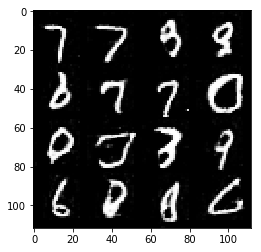

Epoch 9/10... Discriminator Loss: 0.4032... Generator Loss: 1.6198
Epoch 9/10... Discriminator Loss: 0.7527... Generator Loss: 1.2027
Epoch 9/10... Discriminator Loss: 0.8495... Generator Loss: 0.8419
Epoch 9/10... Discriminator Loss: 0.6098... Generator Loss: 1.2892
Epoch 9/10... Discriminator Loss: 0.4020... Generator Loss: 1.6290
Epoch 9/10... Discriminator Loss: 0.4591... Generator Loss: 1.6598
Epoch 9/10... Discriminator Loss: 0.6968... Generator Loss: 2.7350
Epoch 9/10... Discriminator Loss: 0.4117... Generator Loss: 1.6717
Epoch 9/10... Discriminator Loss: 0.3424... Generator Loss: 1.8714
Epoch 9/10... Discriminator Loss: 0.2978... Generator Loss: 1.7742


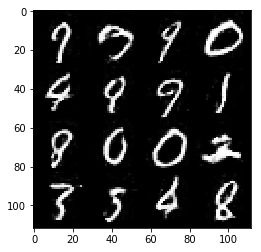

Epoch 9/10... Discriminator Loss: 0.4063... Generator Loss: 1.6474
Epoch 9/10... Discriminator Loss: 0.2700... Generator Loss: 2.1422
Epoch 9/10... Discriminator Loss: 0.4466... Generator Loss: 1.5090
Epoch 9/10... Discriminator Loss: 0.3969... Generator Loss: 1.5548
Epoch 9/10... Discriminator Loss: 0.4526... Generator Loss: 1.8684
Epoch 9/10... Discriminator Loss: 0.3810... Generator Loss: 2.0212
Epoch 9/10... Discriminator Loss: 0.2698... Generator Loss: 2.3542
Epoch 10/10... Discriminator Loss: 0.3643... Generator Loss: 2.8925
Epoch 10/10... Discriminator Loss: 0.4481... Generator Loss: 1.4806
Epoch 10/10... Discriminator Loss: 0.2739... Generator Loss: 2.3200


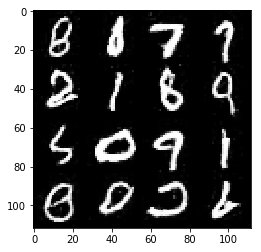

Epoch 10/10... Discriminator Loss: 3.3664... Generator Loss: 0.0801
Epoch 10/10... Discriminator Loss: 0.7456... Generator Loss: 2.4290
Epoch 10/10... Discriminator Loss: 0.6755... Generator Loss: 1.9900
Epoch 10/10... Discriminator Loss: 0.5524... Generator Loss: 1.6143
Epoch 10/10... Discriminator Loss: 0.3005... Generator Loss: 2.6839
Epoch 10/10... Discriminator Loss: 0.5811... Generator Loss: 1.7904
Epoch 10/10... Discriminator Loss: 0.4004... Generator Loss: 1.7510
Epoch 10/10... Discriminator Loss: 0.5438... Generator Loss: 1.2193
Epoch 10/10... Discriminator Loss: 0.3076... Generator Loss: 2.4349
Epoch 10/10... Discriminator Loss: 0.4264... Generator Loss: 1.6587


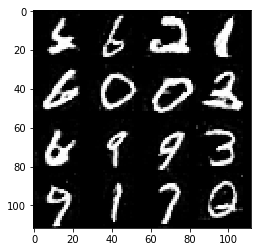

Epoch 10/10... Discriminator Loss: 0.4389... Generator Loss: 1.4731
Epoch 10/10... Discriminator Loss: 0.4539... Generator Loss: 1.7705
Epoch 10/10... Discriminator Loss: 0.6708... Generator Loss: 1.0838
Epoch 10/10... Discriminator Loss: 0.3626... Generator Loss: 2.0964
Epoch 10/10... Discriminator Loss: 0.4346... Generator Loss: 1.7844
Epoch 10/10... Discriminator Loss: 0.4060... Generator Loss: 1.9248
Epoch 10/10... Discriminator Loss: 0.3835... Generator Loss: 1.8065
Epoch 10/10... Discriminator Loss: 0.5108... Generator Loss: 1.7037
Epoch 10/10... Discriminator Loss: 0.3600... Generator Loss: 1.8145
Epoch 10/10... Discriminator Loss: 0.3299... Generator Loss: 2.0866


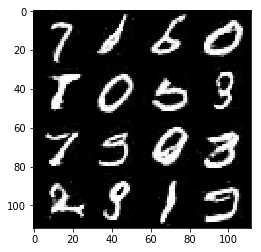

Epoch 10/10... Discriminator Loss: 0.8010... Generator Loss: 1.2483
Epoch 10/10... Discriminator Loss: 0.3619... Generator Loss: 1.8276
Epoch 10/10... Discriminator Loss: 0.4006... Generator Loss: 1.7995
Epoch 10/10... Discriminator Loss: 0.3578... Generator Loss: 2.0323
Epoch 10/10... Discriminator Loss: 0.7256... Generator Loss: 1.2541
Epoch 10/10... Discriminator Loss: 0.3532... Generator Loss: 1.9335
Epoch 10/10... Discriminator Loss: 0.3518... Generator Loss: 2.6493
Epoch 10/10... Discriminator Loss: 0.4682... Generator Loss: 1.8969
Epoch 10/10... Discriminator Loss: 0.2042... Generator Loss: 2.6478
Epoch 10/10... Discriminator Loss: 0.3748... Generator Loss: 1.9045


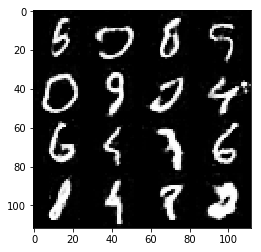

Epoch 10/10... Discriminator Loss: 0.3608... Generator Loss: 1.7540
Epoch 10/10... Discriminator Loss: 0.5622... Generator Loss: 3.8874
Epoch 10/10... Discriminator Loss: 0.4484... Generator Loss: 1.6744
Epoch 10/10... Discriminator Loss: 0.4769... Generator Loss: 1.6145
Epoch 10/10... Discriminator Loss: 0.4491... Generator Loss: 1.8226
Epoch 10/10... Discriminator Loss: 0.2993... Generator Loss: 2.3162
Epoch 10/10... Discriminator Loss: 0.4197... Generator Loss: 1.9027
Epoch 10/10... Discriminator Loss: 0.4454... Generator Loss: 1.4820
Epoch 10/10... Discriminator Loss: 0.3840... Generator Loss: 1.7265
Epoch 10/10... Discriminator Loss: 0.4873... Generator Loss: 1.6107


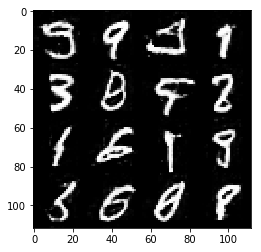

Epoch 10/10... Discriminator Loss: 0.3404... Generator Loss: 2.3982
Epoch 10/10... Discriminator Loss: 0.3224... Generator Loss: 2.4696
Epoch 10/10... Discriminator Loss: 0.4746... Generator Loss: 2.5290
Epoch 10/10... Discriminator Loss: 0.5937... Generator Loss: 1.3198
Epoch 10/10... Discriminator Loss: 0.2161... Generator Loss: 2.5088
Epoch 10/10... Discriminator Loss: 0.5302... Generator Loss: 1.5635
Epoch 10/10... Discriminator Loss: 0.4215... Generator Loss: 2.2358
Epoch 10/10... Discriminator Loss: 0.6301... Generator Loss: 1.1607
Epoch 10/10... Discriminator Loss: 0.3617... Generator Loss: 2.3556
Epoch 10/10... Discriminator Loss: 0.4747... Generator Loss: 1.4737


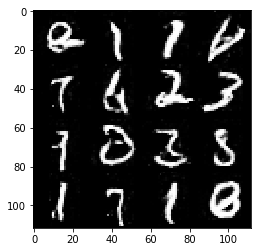

Epoch 10/10... Discriminator Loss: 0.4942... Generator Loss: 1.4455
Epoch 10/10... Discriminator Loss: 0.3219... Generator Loss: 1.8294
Epoch 10/10... Discriminator Loss: 0.2596... Generator Loss: 2.4398
Epoch 10/10... Discriminator Loss: 0.5201... Generator Loss: 3.1803
Epoch 10/10... Discriminator Loss: 0.3870... Generator Loss: 1.9927
Epoch 10/10... Discriminator Loss: 0.5343... Generator Loss: 1.6008
Epoch 10/10... Discriminator Loss: 0.5172... Generator Loss: 1.5046
Epoch 10/10... Discriminator Loss: 0.3680... Generator Loss: 2.2511
Epoch 10/10... Discriminator Loss: 0.4151... Generator Loss: 1.9424
Epoch 10/10... Discriminator Loss: 0.4800... Generator Loss: 1.7987


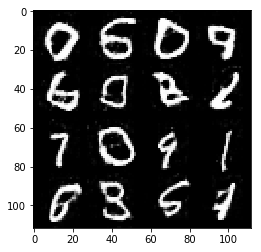

Epoch 10/10... Discriminator Loss: 0.3521... Generator Loss: 2.0840
Epoch 10/10... Discriminator Loss: 0.2350... Generator Loss: 2.2867
Epoch 10/10... Discriminator Loss: 0.3629... Generator Loss: 1.8173
Epoch 10/10... Discriminator Loss: 0.8360... Generator Loss: 1.0461
Epoch 10/10... Discriminator Loss: 0.4179... Generator Loss: 1.7220
Epoch 10/10... Discriminator Loss: 0.5885... Generator Loss: 1.2293
Epoch 10/10... Discriminator Loss: 0.2767... Generator Loss: 2.0260
Epoch 10/10... Discriminator Loss: 0.2730... Generator Loss: 2.2934
Epoch 10/10... Discriminator Loss: 0.4853... Generator Loss: 1.4747
Epoch 10/10... Discriminator Loss: 0.4291... Generator Loss: 1.6851


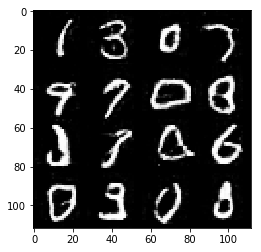

Epoch 10/10... Discriminator Loss: 0.3421... Generator Loss: 1.9804
Epoch 10/10... Discriminator Loss: 0.2566... Generator Loss: 2.1669
Epoch 10/10... Discriminator Loss: 0.2968... Generator Loss: 2.7080
Epoch 10/10... Discriminator Loss: 0.6731... Generator Loss: 1.0587
Epoch 10/10... Discriminator Loss: 0.3511... Generator Loss: 1.7975
Epoch 10/10... Discriminator Loss: 0.6913... Generator Loss: 3.3155
Epoch 10/10... Discriminator Loss: 0.3868... Generator Loss: 1.7393
Epoch 10/10... Discriminator Loss: 0.8473... Generator Loss: 3.9300
Epoch 10/10... Discriminator Loss: 1.4882... Generator Loss: 3.2807
Epoch 10/10... Discriminator Loss: 1.7467... Generator Loss: 0.7488


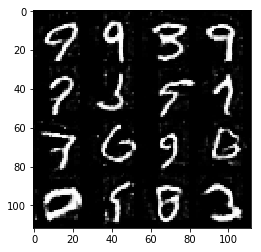

Epoch 10/10... Discriminator Loss: 0.4521... Generator Loss: 2.4100
Epoch 10/10... Discriminator Loss: 0.5626... Generator Loss: 1.4866
Epoch 10/10... Discriminator Loss: 0.6610... Generator Loss: 1.9777
Epoch 10/10... Discriminator Loss: 0.4441... Generator Loss: 1.8782
Epoch 10/10... Discriminator Loss: 0.4469... Generator Loss: 1.8665
Epoch 10/10... Discriminator Loss: 0.3646... Generator Loss: 2.0039
Epoch 10/10... Discriminator Loss: 0.4447... Generator Loss: 2.0729
Epoch 10/10... Discriminator Loss: 0.2544... Generator Loss: 2.8469
Epoch 10/10... Discriminator Loss: 0.4475... Generator Loss: 1.7009
Epoch 10/10... Discriminator Loss: 0.4190... Generator Loss: 2.1502


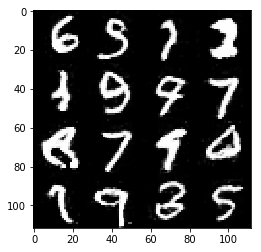

Epoch 10/10... Discriminator Loss: 0.4372... Generator Loss: 1.7939
Epoch 10/10... Discriminator Loss: 0.5589... Generator Loss: 1.5885
Epoch 10/10... Discriminator Loss: 0.4717... Generator Loss: 1.9536
Epoch 10/10... Discriminator Loss: 0.4980... Generator Loss: 1.8023
Epoch 10/10... Discriminator Loss: 0.5508... Generator Loss: 1.4958
Epoch 10/10... Discriminator Loss: 0.4498... Generator Loss: 1.4562
Epoch 10/10... Discriminator Loss: 0.4568... Generator Loss: 1.4509
Epoch 10/10... Discriminator Loss: 0.2695... Generator Loss: 2.2241
Epoch 10/10... Discriminator Loss: 0.4315... Generator Loss: 1.9886
Epoch 10/10... Discriminator Loss: 0.4828... Generator Loss: 1.3273


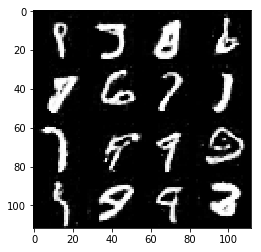

Epoch 10/10... Discriminator Loss: 0.3014... Generator Loss: 1.9283
Epoch 10/10... Discriminator Loss: 0.8576... Generator Loss: 0.8996
Epoch 10/10... Discriminator Loss: 0.2627... Generator Loss: 2.4602
Epoch 10/10... Discriminator Loss: 0.5389... Generator Loss: 1.4196
Epoch 10/10... Discriminator Loss: 0.3284... Generator Loss: 1.9580
Epoch 10/10... Discriminator Loss: 0.3626... Generator Loss: 1.9811
Epoch 10/10... Discriminator Loss: 0.5326... Generator Loss: 1.6160
Epoch 10/10... Discriminator Loss: 0.5919... Generator Loss: 1.3222
Epoch 10/10... Discriminator Loss: 0.5848... Generator Loss: 1.5376
Epoch 10/10... Discriminator Loss: 0.4860... Generator Loss: 1.4046


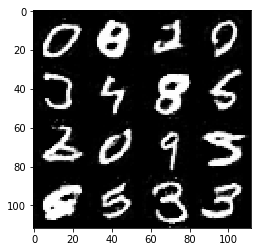

Epoch 10/10... Discriminator Loss: 0.5296... Generator Loss: 1.5149
Epoch 10/10... Discriminator Loss: 0.4008... Generator Loss: 1.6147
Epoch 10/10... Discriminator Loss: 0.4440... Generator Loss: 1.8628
Epoch 10/10... Discriminator Loss: 0.6238... Generator Loss: 1.1939
Epoch 10/10... Discriminator Loss: 0.3010... Generator Loss: 2.3958
Epoch 10/10... Discriminator Loss: 0.2787... Generator Loss: 2.0872
Epoch 10/10... Discriminator Loss: 0.2507... Generator Loss: 2.2080
Epoch 10/10... Discriminator Loss: 0.4065... Generator Loss: 2.0744
Epoch 10/10... Discriminator Loss: 0.8193... Generator Loss: 0.8126
Epoch 10/10... Discriminator Loss: 0.3321... Generator Loss: 2.0768


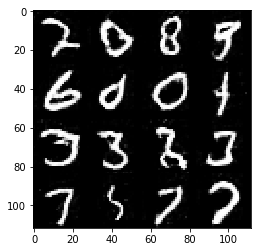

Epoch 10/10... Discriminator Loss: 0.4987... Generator Loss: 2.9317
Epoch 10/10... Discriminator Loss: 0.4890... Generator Loss: 1.5007
Epoch 10/10... Discriminator Loss: 0.6107... Generator Loss: 1.2330
Epoch 10/10... Discriminator Loss: 0.5356... Generator Loss: 1.6929
Epoch 10/10... Discriminator Loss: 0.4962... Generator Loss: 1.6115
Epoch 10/10... Discriminator Loss: 0.5041... Generator Loss: 1.6752
Epoch 10/10... Discriminator Loss: 0.5060... Generator Loss: 1.3038
Epoch 10/10... Discriminator Loss: 0.5867... Generator Loss: 1.1960
Epoch 10/10... Discriminator Loss: 0.6431... Generator Loss: 1.0952
Epoch 10/10... Discriminator Loss: 0.3302... Generator Loss: 2.1605


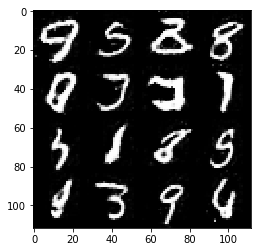

Epoch 10/10... Discriminator Loss: 0.3233... Generator Loss: 2.0297
Epoch 10/10... Discriminator Loss: 0.6546... Generator Loss: 1.2096
Epoch 10/10... Discriminator Loss: 0.5196... Generator Loss: 1.8244
Epoch 10/10... Discriminator Loss: 0.9020... Generator Loss: 3.6475
Epoch 10/10... Discriminator Loss: 0.3687... Generator Loss: 1.6706
Epoch 10/10... Discriminator Loss: 0.2136... Generator Loss: 2.6090
Epoch 10/10... Discriminator Loss: 0.3839... Generator Loss: 2.4524
Epoch 10/10... Discriminator Loss: 0.5196... Generator Loss: 1.7177
Epoch 10/10... Discriminator Loss: 0.7875... Generator Loss: 0.9692
Epoch 10/10... Discriminator Loss: 0.4018... Generator Loss: 2.2389


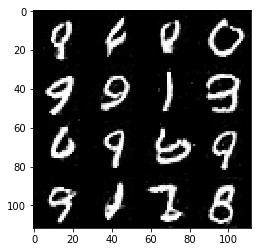

Epoch 10/10... Discriminator Loss: 0.4419... Generator Loss: 1.9420
Epoch 10/10... Discriminator Loss: 0.3655... Generator Loss: 2.2523
Epoch 10/10... Discriminator Loss: 0.5001... Generator Loss: 1.5700
Epoch 10/10... Discriminator Loss: 0.3141... Generator Loss: 2.0138
Epoch 10/10... Discriminator Loss: 0.4795... Generator Loss: 1.9536
Epoch 10/10... Discriminator Loss: 0.3324... Generator Loss: 1.8268
Epoch 10/10... Discriminator Loss: 0.3712... Generator Loss: 1.9278
Epoch 10/10... Discriminator Loss: 0.5691... Generator Loss: 1.3604
Epoch 10/10... Discriminator Loss: 0.1720... Generator Loss: 2.7559
Epoch 10/10... Discriminator Loss: 0.3729... Generator Loss: 1.7579


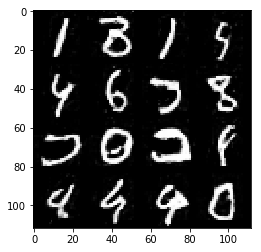

Epoch 10/10... Discriminator Loss: 0.3754... Generator Loss: 1.7884
Epoch 10/10... Discriminator Loss: 0.5629... Generator Loss: 1.3211
Epoch 10/10... Discriminator Loss: 0.4836... Generator Loss: 1.9525
Epoch 10/10... Discriminator Loss: 0.4396... Generator Loss: 1.7869
Epoch 10/10... Discriminator Loss: 0.9659... Generator Loss: 0.8520
Epoch 10/10... Discriminator Loss: 0.6086... Generator Loss: 1.0962
Epoch 10/10... Discriminator Loss: 0.3144... Generator Loss: 2.3361
Epoch 10/10... Discriminator Loss: 0.3016... Generator Loss: 2.2116
Epoch 10/10... Discriminator Loss: 0.3830... Generator Loss: 1.8571
Epoch 10/10... Discriminator Loss: 0.3523... Generator Loss: 1.9814


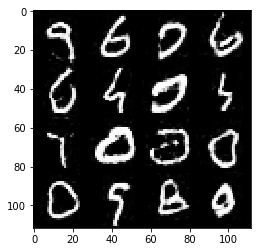

Epoch 10/10... Discriminator Loss: 0.3828... Generator Loss: 2.5637
Epoch 10/10... Discriminator Loss: 0.4563... Generator Loss: 3.0732
Epoch 10/10... Discriminator Loss: 0.4414... Generator Loss: 1.4283
Epoch 10/10... Discriminator Loss: 0.3377... Generator Loss: 2.0389
Epoch 10/10... Discriminator Loss: 0.3818... Generator Loss: 1.7357
Epoch 10/10... Discriminator Loss: 0.5546... Generator Loss: 1.2670
Epoch 10/10... Discriminator Loss: 0.3505... Generator Loss: 2.0786
Epoch 10/10... Discriminator Loss: 0.3482... Generator Loss: 2.0761
Epoch 10/10... Discriminator Loss: 0.9922... Generator Loss: 0.7365
Epoch 10/10... Discriminator Loss: 0.6325... Generator Loss: 1.3687


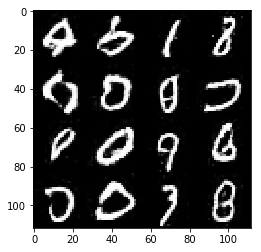

Epoch 10/10... Discriminator Loss: 0.3049... Generator Loss: 2.3946
Epoch 10/10... Discriminator Loss: 0.3675... Generator Loss: 1.8847
Epoch 10/10... Discriminator Loss: 0.3937... Generator Loss: 1.8127
Epoch 10/10... Discriminator Loss: 0.6873... Generator Loss: 1.0956
Epoch 10/10... Discriminator Loss: 0.4692... Generator Loss: 1.5144
Epoch 10/10... Discriminator Loss: 0.6841... Generator Loss: 1.0840
Epoch 10/10... Discriminator Loss: 0.7981... Generator Loss: 0.8361
Epoch 10/10... Discriminator Loss: 0.5628... Generator Loss: 1.3827
Epoch 10/10... Discriminator Loss: 0.4846... Generator Loss: 1.5678
Epoch 10/10... Discriminator Loss: 0.4014... Generator Loss: 1.7202


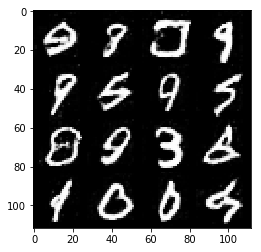

Epoch 10/10... Discriminator Loss: 0.3387... Generator Loss: 2.8248
Epoch 10/10... Discriminator Loss: 0.5103... Generator Loss: 1.3462
Epoch 10/10... Discriminator Loss: 0.6136... Generator Loss: 1.3707
Epoch 10/10... Discriminator Loss: 0.4628... Generator Loss: 1.7177
Epoch 10/10... Discriminator Loss: 0.2694... Generator Loss: 2.1320
00:15:28


In [26]:
import time

batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

start_time = time.time()

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5421... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.3580... Generator Loss: 1.6211
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 1.6624
Epoch 1/1... Discriminator Loss: 0.3069... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 0.2494... Generator Loss: 2.1082
Epoch 1/1... Discriminator Loss: 0.3555... Generator Loss: 1.6599
Epoch 1/1... Discriminator Loss: 0.2559... Generator Loss: 2.0204
Epoch 1/1... Discriminator Loss: 0.2240... Generator Loss: 2.1579
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 2.0235


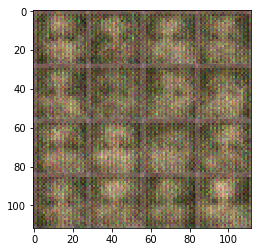

Epoch 1/1... Discriminator Loss: 0.9564... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.6391... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 0.5496... Generator Loss: 1.8949
Epoch 1/1... Discriminator Loss: 0.6414... Generator Loss: 2.5983
Epoch 1/1... Discriminator Loss: 0.5646... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 0.6892... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 1.9144
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 0.4647... Generator Loss: 2.0880


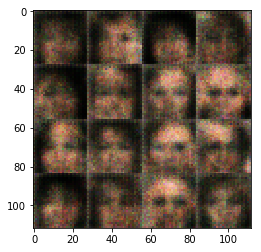

Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 2.4879
Epoch 1/1... Discriminator Loss: 0.4334... Generator Loss: 1.5997
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 1.4365
Epoch 1/1... Discriminator Loss: 0.5578... Generator Loss: 1.8191
Epoch 1/1... Discriminator Loss: 0.6422... Generator Loss: 1.5070
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.5771
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 0.7271... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.7672


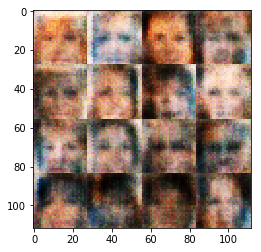

Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.4059
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.4765
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2941
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.2969
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.3591


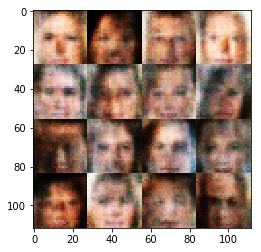

Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 0.9567... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.8320... Generator Loss: 1.0062
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.0280
Epoch 1/1... Discriminator Loss: 0.7683... Generator Loss: 1.3606
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9101


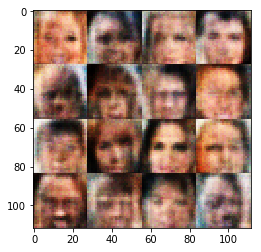

Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.1321
Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.1888
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.3213
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.8994


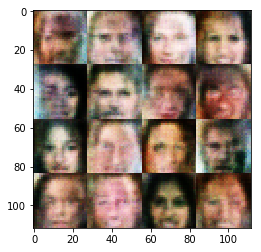

Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.5985... Generator Loss: 1.5611
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.7666... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 0.5696... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.8476... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.7195... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.2538


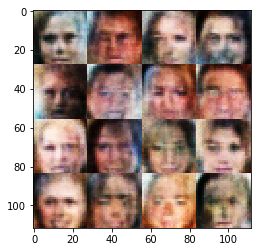

Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.4658
Epoch 1/1... Discriminator Loss: 0.5736... Generator Loss: 1.6539
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.3781
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.6030
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0918


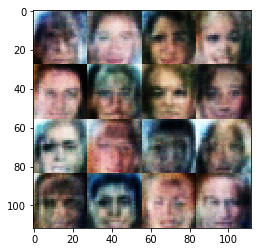

Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 0.7745... Generator Loss: 1.0795
Epoch 1/1... Discriminator Loss: 0.7369... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.6777
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 0.4753... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.1337


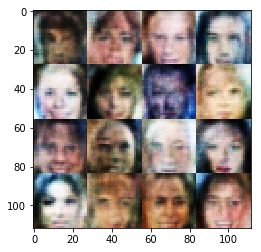

Epoch 1/1... Discriminator Loss: 0.6732... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.5984... Generator Loss: 1.3920
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 0.9473


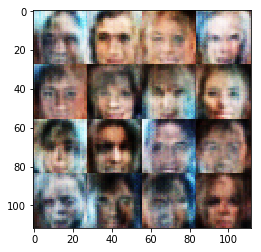

Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.3885
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 0.8613... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.8158
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.7825


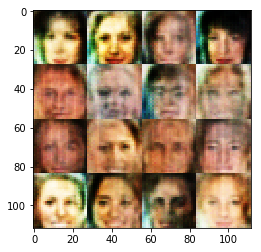

Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 0.8789
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.0631
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.7883


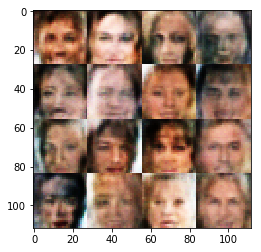

Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.2284
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.3248
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 0.9632... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 1.0271


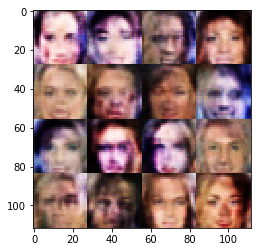

Epoch 1/1... Discriminator Loss: 0.8382... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 1.0281


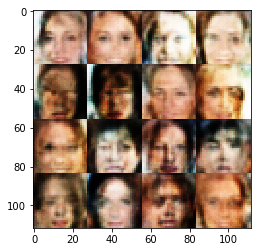

Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.8957
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 0.9007... Generator Loss: 1.0240


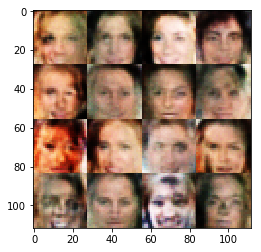

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8338


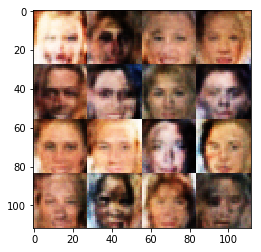

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 0.9141... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 0.9080


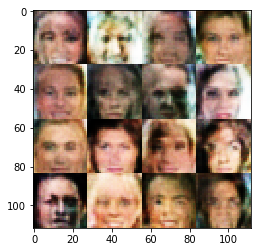

Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.1712
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 1.0191
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2927... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0459


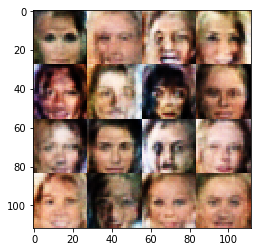

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9413
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 1.4071
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.2837
Epoch 1/1... Discriminator Loss: 0.9194... Generator Loss: 1.1856
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.4628
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.1749


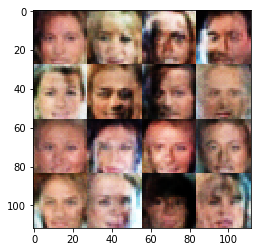

Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.8248... Generator Loss: 1.1665
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0467
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1801


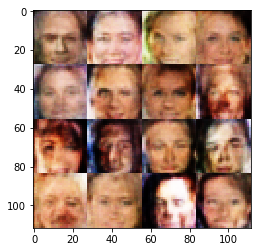

Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 1.0750
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 0.6027


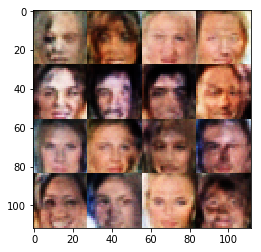

Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.9973
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 0.9570... Generator Loss: 1.1562


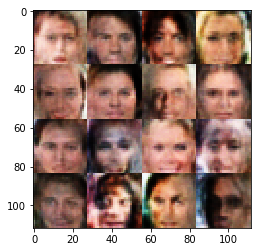

Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.1523... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0643
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.9923


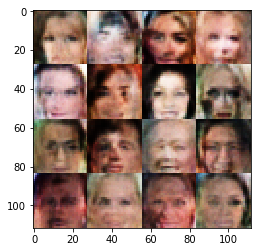

Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1838
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.1601


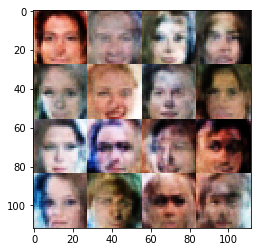

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.1570
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.0048


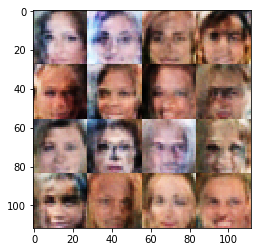

Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.2987
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.1058
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 0.8925... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.7478


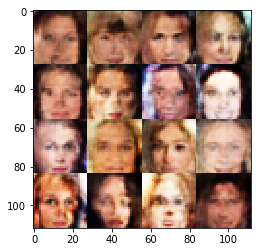

Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.2562
Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.0250... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 0.8332... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.2042
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 1.0255


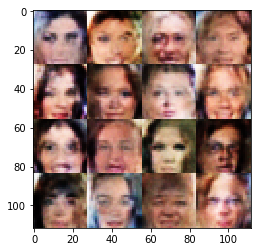

Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.2936
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 0.8127


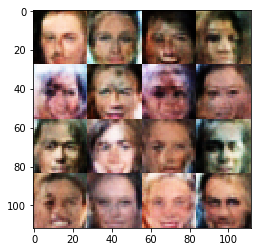

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.0894
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.9020
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8184


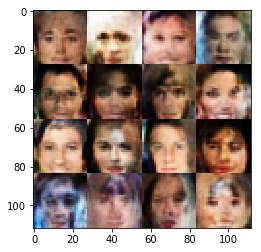

Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 1.3474
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.3631
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 1.4130
Epoch 1/1... Discriminator Loss: 0.9280... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 0.9833... Generator Loss: 1.0800


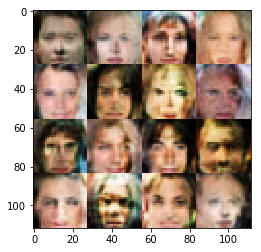

Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 0.8189... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5903


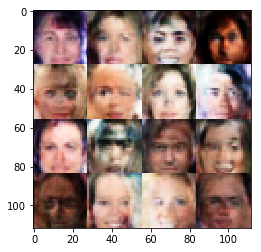

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.4144
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.0924
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1577... Generator Loss: 0.6859


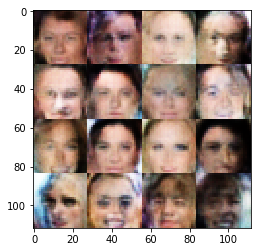

Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.1428... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.1117


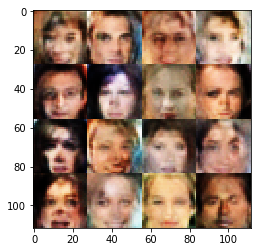

Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.1125... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.0514... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.8788
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.0494


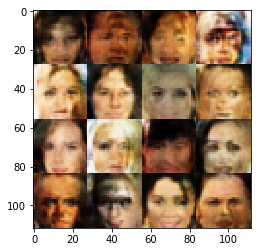

Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.2877
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 1.3373
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.2218
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 1.0726


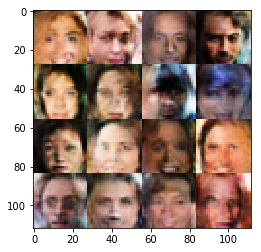

Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.1887
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 1.1637
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 0.9281
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.0476


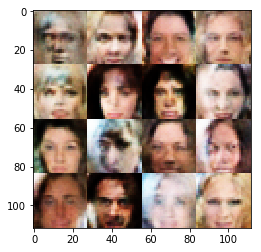

Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 0.9604
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.1313
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7863


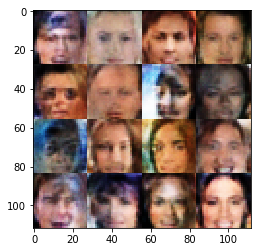

Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.9176
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.3127
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.7944... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.5472
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.8912


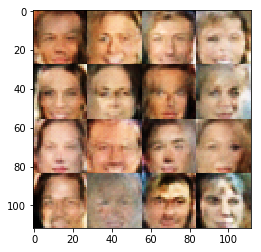

Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 0.7490... Generator Loss: 1.1757
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.0825


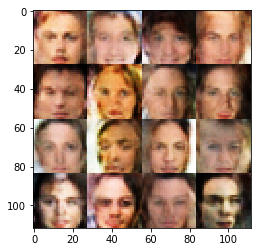

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.1326
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 0.6085... Generator Loss: 1.5172
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.4049
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 0.9511
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.3525


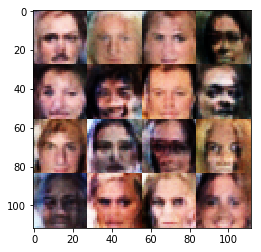

Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.7357


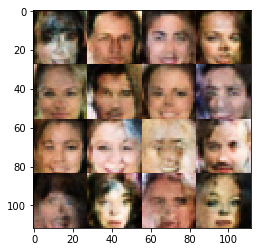

Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.1192


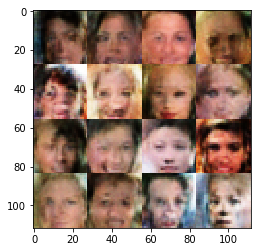

Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.0751
Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.1080... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.3128
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.5617


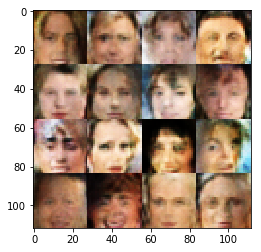

Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 0.9756... Generator Loss: 0.7830


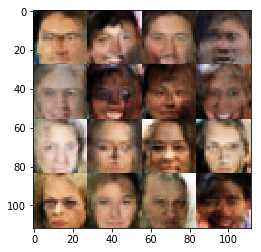

Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 0.7899... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.4846
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.1634
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.7687


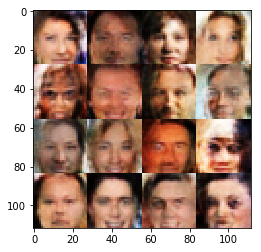

Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.0695
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 0.7108... Generator Loss: 1.5232
Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.7701


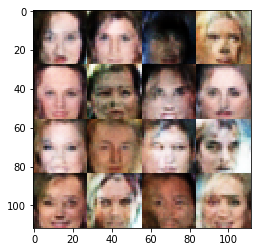

Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 1.0022
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.9405
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 1.2027


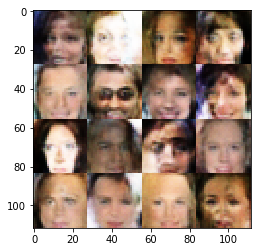

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.0858
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 0.5834... Generator Loss: 1.6852
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.7233
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 0.9641
Epoch 1/1... Discriminator Loss: 0.6212... Generator Loss: 1.1877


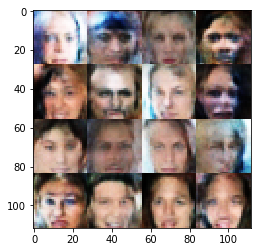

Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.0894... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 0.6411... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.9944... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.7520


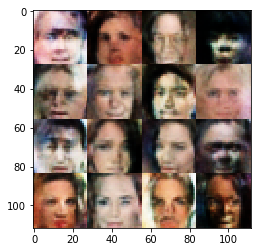

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 0.9824... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.0239


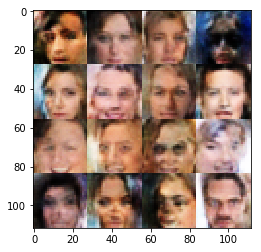

Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 0.9689... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.2779
Epoch 1/1... Discriminator Loss: 0.7251... Generator Loss: 1.5163
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9965


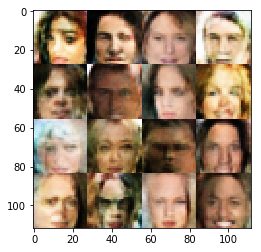

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.2843


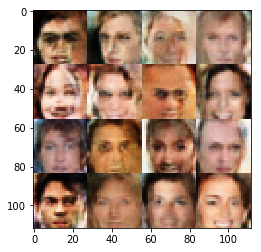

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.5051
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.4431
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2171


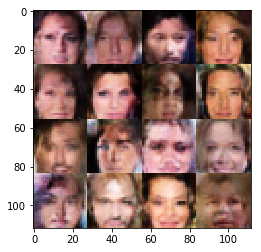

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.3953
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0111
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1917... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.1575
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 0.9471


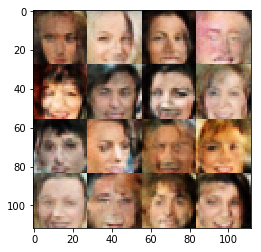

Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.1702
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 0.6963... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.8248


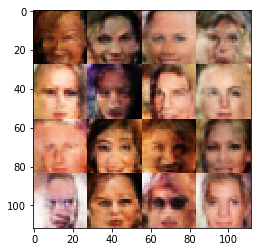

Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9171
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.4857


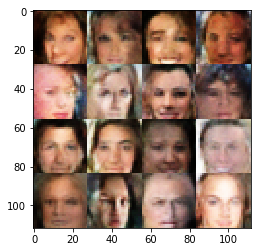

Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 0.6620... Generator Loss: 1.2675
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 1.2380
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.4196


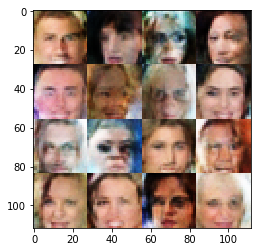

Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 0.6905... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.0965
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.4998


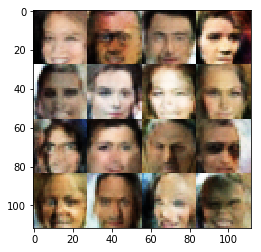

Epoch 1/1... Discriminator Loss: 0.7550... Generator Loss: 1.4063
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.2077
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 1.0646


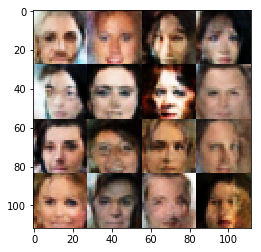

Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.2384
Epoch 1/1... Discriminator Loss: 0.6900... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.0028... Generator Loss: 0.9083
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 1.1701
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6865


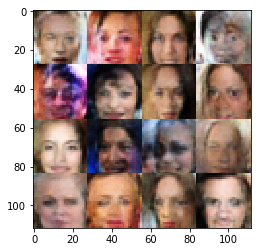

Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.0835
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 0.8604... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.6965


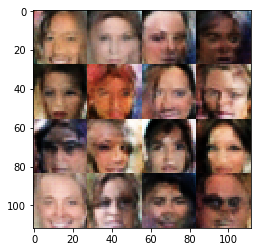

Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 0.9423... Generator Loss: 1.2365
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.5530
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.3908
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 0.8053


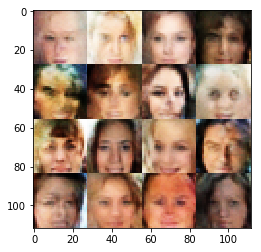

Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.0982
Epoch 1/1... Discriminator Loss: 0.7220... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9479


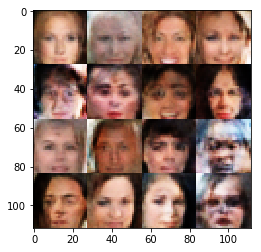

Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.3735
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 0.9103
00:13:34


In [24]:
import time


batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

start_time = time.time()

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

execution_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(execution_time)))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.